# Imports and dependencies

In [ ]:
pip install matplotlib==3.4.2

In [ ]:
!pip install pyssim

  Created wheel for pyssim: filename=pyssim-0.4-py2.py3-none-any.whl size=5813 sha256=4dd400bbc21283022594eae9df7ead1783f73ca93777ce5945494e63a3eeb0f4
  Stored in directory: /root/.cache/pip/wheels/d0/ea/0c/ba94e2becf14fe426dbc21148ff8b792e25318e8e911c8e52c
Successfully built pyssim


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import keras
from keras import Sequential

from time import sleep
from operator import itemgetter
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time 
import timeit
import progressbar
import pandas as pd

from skimage.transform import resize
from skimage.transform import rotate
from skimage import transform as trfm
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage import io
from skimage import color
import ssim.ssimlib as pyssim
import PIL


from scipy.optimize import minimize_scalar
from scipy.io import loadmat
from scipy import stats
from scipy.cluster.hierarchy import dendrogram

import ipywidgets as ipw
from IPython.core.display import HTML, display, clear_output
from ipywidgets import widgets,interact, interactive, fixed, interact_manual

In [ ]:
%pip freeze > requirements.txt

# Models

In [ ]:
# Modelo convolucional simple
#define the convnet
def convnet_simple(num_classes,input_shape):
  
  model = Sequential()
  # CONV => RELU => CONV => RELU => POOL => DROPOUT
  model.add(Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=input_shape))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # CONV => RELU => CONV => RELU => POOL => DROPOUT
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # FLATTERN => DENSE => RELU => DROPOUT
  model.add(Flatten())
  model.add(Dense(512, activation ='relu'))
  model.add(Dropout(0.5))
  # a softmax classifier
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  return model

In [ ]:

from keras.activations import relu
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers


class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(64)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x



In [ ]:
import keras.backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.utils import get_file


import keras
from distutils.version import StrictVersion

if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras.applications.imagenet_utils import obtain_input_shape


def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

# default parameters for convolution and batchnorm layers of ResNet models
# parameters are obtained from MXNet converted model

def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params

def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params


def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    input_shape = obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    
    inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model


weights_collection = [
    # ResNet34
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },

    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    },
]


def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, 'resnet34', dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))


def ResNet34_V2(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    #model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model

from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0      
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

# Functions


## GradCAM

In [ ]:
def grad_cam_plus(img, model,  layer_name, label_name=None, category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor) # De aqui se obtiene (8,8,640)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)


    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    
    # Aqui se computa el valor alpha, que yo he llamado pixel importance weight 
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10) # Esto no se que es lo que hace
       
    # Ahora junta numerador y denominador, pero luego hace una normalizacion que no entiendo por que la hace
    alphas = alpha_num/alpha_denom  # (8,8,640)
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas = tf.math.divide_no_nan(alphas,alpha_normalization_constant) # Esta normalizacion tambien la hacen en el codigo original del paper, es para evitar que los feature maps que son 0 no den el fallo de que se dividan por 0 a si mismos.
    #alphas /= alpha_normalization_constant 
    weights = np.maximum(conv_first_grad[0], 0.0) # ReLU a los gradientes. Demostrado empiricamente que funciona mejor

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1)) # Los Neuron Importance Weights de GradCAM
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2) # Computa el mapa haciendo el sumatorio de cada mapa por su w

    # Se queda solo con los valores positivos y para la visualizacion normaliza
    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    #if max_heat == 0: # Para evitar NaN, asi que uso la funcion de tf especifica
    #    max_heat = 1e-10
    heatmap = tf.math.divide_no_nan(heatmap, max_heat) 

    return heatmap


def grad_cam(img,model, 
             layer_name="block5_conv3", label_name=None,
             category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    #print(tf.math.reduce_max(grads,axis=(0,1,2)))
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

## Visualizations

In [ ]:
# Funcion que hace plot del entrenamiento, donde se ve la acc vs loss
def plot_historia(history):
  
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[         'loss' ]
  val_loss = history.history[     'val_loss' ]

  epochs    = range(1,len(acc)+1,1) # obtener número de epochs del eje X

  plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
  plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
  plt.title ('Training and Validation Accuracy')
  plt.ylabel('acc')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()


  plt.plot  ( epochs,     loss, 'r--', label='Training loss'  )
  plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.title ('Training and Validation Loss'   )
  plt.ylabel('loss')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()


# Funcion que hace plot de los heatmaps creados
def plot_heatmaps(rows, cols, inicio, layer_names, preds, test_images, test_labels,top_pred_index=None, numero=None, img_resize=True):
  """
  En cada columna va una instacia de test_images
  En cada fila se representa lo siguiente:
    1) La imagen del numero
    2) El GradCAM heatmap
    3) El Saliency map
    4) GrandCAM + Numero superpuestos
    5) Saliency Map + Numero superpuestos

  Si se proporciona un numero, solo hace el plot de dicho numero
  """
  if numero != None:
    indices = buscar_num(numero,cols,test_labels,inicio) # Los indices del número que has definido que hay que buscar
  else:
    indices = [r for r in range(inicio,inicio+cols)] # En caso de no definir un numero simplemente hace plot desde la pos inicio
  for j in range(cols):
    grad_cam_hm, saliency = make_gradcam_heatmap_V2(np.expand_dims(test_images[indices[j]],axis=0),model, 'conv2d_1', layer_names)
    img = test_images[indices[j],:,:,0]
    ax[0,j].imshow(img, cmap='binary')
    set_axis_props(0,j,np.argmax(preds[indices[j]]))
    if img_resize == True:
      ax[1,j].imshow(resize(grad_cam_hm, (28,28)))
    else:
      ax[1,j].imshow(grad_cam_hm)
    set_axis_props(1,j)
    if img_resize == True:
      ax[2,j].imshow(resize(saliency, (28,28)))
    else:
      ax[2,j].imshow(saliency)
    set_axis_props(2,j)
    subplt_hotmap(3,j,img,grad_cam_hm)
    set_axis_props(3,j)
    subplt_hotmap(4,j,img,saliency)
    set_axis_props(4,j)
  fig.show()


# Funcion para definir las propiedades de un subplot
def set_axis_props(i,j, title=None):
  ax[i,j].set_xticks([])
  ax[i,j].set_yticks([])
  if title != None:
    ax[i,j].set_title(title, fontsize=30)


# Hace plot del heatmap en el axes le pases
def plot_heatmap(axes,i,j,heatmap,resize_img=False,title=None,superimposed_img=False,imagen=None):
  if imagen.ndim !=2:
    imagen = imagen.squeeze()
  if superimposed_img == True:
    axes[i,j].imshow(imagen,vmin=0,vmax=1)
    axes[i,j].imshow(resize(heatmap,(train_images.shape[1:3])),alpha=0.6,cmap='jet',vmin=0,vmax=1)
  elif resize_img == False:
    axes[i,j].imshow(heatmap,cmap='jet',vmin=0,vmax=1)
  else:
    axes[i,j].imshow(resize(heatmap,train_images.shape[1:3]),vmin=0,vmax=1)
  axes[i,j].set_xticks([])
  axes[i,j].set_yticks([])
  if title != None:
    axes[i,j].set_title(title, fontsize=30)
  return axes

def search_index_of_class(clase, n_times, labels, ini=0):
  '''
  Funcion que encuentra un num las n_veces que quieras en 
  un conjunto de imagenes de numeros (empezando a buscar desde la pos que indiques) 
  develve una lista con los indices de los números
  '''
  lista_indices = []
  n=0
  i=0
  while n < n_times:
    if clase == np.argmax(labels[ini+i]):
      lista_indices.append(ini+i)
      n = n+1
    i = i+1
  return lista_indices


# Funcion que encuentra un num las n_veces-1 que quieras en un conjunto de imagenes de numeros (empezando a buscar desde la pos que indiques) develve una lista con los indices de los números.
# Para ello hay que proporcionar el número que buscas, cuantas veces lo quieres, el vector con las etiquetas y la posicion en la que quieres que empiece a buscar
def buscar_num(num, n_veces, labels, pos=0):
  '''
  Funcion que encuentra un num las n_veces que quieras en 
  un conjunto de imagenes de numeros (empezando a buscar desde la pos que indiques) 
  develve una lista con los indices de los números
  '''
  lista_indices = []
  n=0
  i=0
  while n <= n_veces:
    if num == np.argmax(labels[pos+i]):
      lista_indices.append(pos+i)
      n = n+1
    i = i+1
  return lista_indices


def buscar_num_bien_pred(num, n_veces, labels, preds, pos=0):
  '''
  Funcion que encuentra un num las n_veces que quieras en 
  un conjunto de imagenes de numeros (empezando a buscar desde la pos que indiques) 
  develve una lista con los indices de los números
  '''
  lista_indices = []
  n=0
  i=0
  while n <= n_veces:
    if num == np.argmax(labels[pos+i]):
      if np.argmax(labels[pos+i]) == preds[pos+i]:
        lista_indices.append(pos+i)
        n = n+1
    i = i+1
  return lista_indices


def diferencia_cdf(x,kde_ascending,kde_descending):
  '''
  Function that calculates the difference between two kdes
  '''
  cdf_ascending = []
  x_0 = np.linspace(-1,1,100)
  for i in x_0:
    cdf_ascending.append(kde_ascending.integrate_box_1d(-1,i))

  y_0 = x_0[::-1]
  cdf_descending = []
  for i in y_0:
    cdf_descending.append(kde_descending.integrate_box_1d(i,1))

  diferencia = cdf_ascending[int(x)] - cdf_descending[int(99-x)]
  
  return abs(diferencia)


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



## Heatmap creation and manipulation


In [ ]:
def n_heatmaps_x_clase_guidedbackprop(n_htmaps,instances,labels):
  '''
  Funcion que genera N heatmaps para cada clase del dataset que le proporciones

  '''
  upsample_size = instances.shape[1:3]
  guidedBP = GuidedBackprop(model=model,layerName=last_conv_layer)

  # Array inizialization
  a_heatmaps = np.empty((num_clases,n_htmaps,upsample_size[0],upsample_size[1]))

  for num_clase in tqdm(range(num_clases)):

    # Creas una lista con los indices del numero
    i_nums = buscar_num(num_clase,n_htmaps-1,labels)
    
    for i,indice_num in enumerate(i_nums):

      # Grad-CAM++
      heatmap_gcam = resize(grad_cam_plus(instances[indice_num],model,last_conv_layer,category_id=np.argmax(labels[indice_num])).numpy(),upsample_size)

      # Guided backprop
      gb = guidedBP.guided_backprop(np.expand_dims(instances[indice_num],axis=0), upsample_size)
      gb_im = deprocess_image(gb)
      gb_im = gb_im.astype('float32')/255

      # Rellenas el array con los heatmaps
      a_heatmaps[num_clase,i] = deprocess_image(gb_im*heatmap_gcam).astype('float32') / 255


  return a_heatmaps


def n_heatmaps_x_clase(n_htmaps,instances,labels):
  '''
  Funcion que genera N heatmaps para cada clase del dataset que le proporciones

  '''
  a_heatmaps = np.empty((num_clases,n_htmaps,model.get_layer(last_conv_layer).output.shape[1],model.get_layer(last_conv_layer).output.shape[2]))

  for num_clase in tqdm(range(num_clases)):

    # Creas una lista con los indices del numero
    i_nums = buscar_num(num_clase,n_htmaps-1,labels)
    
    for i,indice_num in enumerate(i_nums):

      # Rellenas el array con los heatmaps
      a_heatmaps[num_clase,i] = grad_cam_plus(instances[indice_num],model,last_conv_layer,category_id=np.argmax(labels[indice_num]))

  return a_heatmaps


def n_heatmaps_x_clase_bien_predichos(n_htmaps,instances,labels,preds):
  '''
  Funcion que genera N heatmaps para cada clase del dataset que le proporciones

  '''
  a_heatmaps = np.empty((num_clases,n_htmaps,model.get_layer(last_conv_layer).output.shape[1],model.get_layer(last_conv_layer).output.shape[2]))

  for num_clase in tqdm(range(num_clases)):

    # Creas una lista con los indices del numero
    i_nums = buscar_num_bien_pred(num_clase,n_htmaps-1,labels,preds)
    
    for i,indice_num in enumerate(i_nums):

      # Rellenas el array con los heatmaps
      a_heatmaps[num_clase,i] = grad_cam_plus(instances[indice_num],model,last_conv_layer,category_id=np.argmax(labels[indice_num]))

  return a_heatmaps


def calculo_htmaps_promedio_mediana(a_heatmaps,modo='mediana'):
  '''
  Funcion que devuelve una lista con el heatmap promedio
  del array de heatmaps proporcionado
  '''
  
  
  if modo == 'mediana':

    htmap_prom_med = np.median(a_heatmaps,axis=0)

  if modo == 'promedio':

    # Inicializamos un heatmap que contendrá la suma y otr
    htmap_suma = np.zeros((a_heatmaps.shape[1],a_heatmaps.shape[2]),dtype='float32') 
    htmap_prom_med = np.zeros((a_heatmaps.shape[1],a_heatmaps.shape[2]),dtype='float32')

    # Sumamos todos los heatmaps del numero pixel a pixel
    for htmap in a_heatmaps:
      np.add(htmap_suma,htmap,out=htmap_suma)

    # Calculamos la media pixel a pixel 
    htmap_prom_med = htmap_suma/len(a_heatmaps)

  return  htmap_prom_med


def htmap_promedio(a_heatmaps):

  # Inicializar un array vacío 
  htmap_suma = np.zeros((a_heatmaps.shape[1],a_heatmaps.shape[2]),dtype='float32') 
  htmap_prom = np.zeros((a_heatmaps.shape[1],a_heatmaps.shape[2]),dtype='float32')

  # Sumamos todos los heatmaps del numero pixel a pixel
  for htmap in a_heatmaps:
    np.add(htmap_suma,htmap,out=htmap_suma)

  # Calculamos la media pixel a pixel
  htmap_prom = htmap_suma/a_heatmaps.shape[0]

  return htmap_prom


def htmap_mediana(a_heatmaps):

  return np.median(a_heatmaps,axis=0)



def calculo_htmaps_x_cluster(a_indice_clust, a_heatmaps,modo='promedio',cuantiles=[0,0.25,0.50,0.75,1]):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  Devuelve:
  - Htmaps promedio o mediana por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  ''' 
  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(a_indice_clust, return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico

  if modo == 'cuantiles':
    a_htmaps_prom_x_cluster = np.empty((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
  else:
    a_htmaps_prom_x_cluster = np.empty((len(unique),a_heatmaps.shape[1],a_heatmaps.shape[2]))

  # Para cada cluster
  for i_unique,cluster in enumerate(unique):

    # Capturamos los indices de los heatmaps que pertenecen a ese cluster
    a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

    # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
    a_aux_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for i,i_un_cluster in enumerate(a_indices_un_cluster):
      a_aux_htmaps[i] = a_heatmaps[int(i_un_cluster)]

    # En función del modo hacemos promedio o mediana
    if modo == 'promedio':
      htmap_prom_un_cluster = htmap_promedio(a_aux_htmaps)

    elif modo == 'mediana':
      htmap_prom_un_cluster = htmap_mediana(a_aux_htmaps)

    elif modo == 'cuantiles':
      '''
      # Reinicializamos el array, para que sea de la forma (n_clusters,n_cuantiles,h,w)
      a_htmaps_prom_x_cluster = np.zeros((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
      '''
      # Calculamos la mediana 
      htmap_mediana_cluster = htmap_mediana(a_aux_htmaps)
      
      # Creamos una lista que contendrá los heatmaps y su distancia a la mediana de su cluster
      l_todos_htmaps_y_dist_a_mediana = []
      l_htmaps_y_dist_a_mediana       = []

      # Hacemos SSIM de todos los demas contra la mediana y nos quedamos con los valores de los cuantiles
      for htmap in a_aux_htmaps:
        l_htmaps_y_dist_a_mediana = []
        l_htmaps_y_dist_a_mediana.append(ssim(htmap_mediana_cluster, htmap))
        l_htmaps_y_dist_a_mediana.append(htmap)
        l_todos_htmaps_y_dist_a_mediana.append(l_htmaps_y_dist_a_mediana)

      # Ordenamos la lista para poder coger sus cuantiles
      l_todos_htmaps_y_dist_a_mediana = sorted(l_todos_htmaps_y_dist_a_mediana,reverse=True, key=itemgetter(0))
      
      # Creamos el array con la mediana y los cuantiles de distancia respecto de la mediana
      htmap_prom_un_cluster = np.zeros((len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
      for j in range(len(cuantiles)):

        if j == 0:
          htmap_prom_un_cluster[j] = htmap_mediana_cluster
          
        else:
          indice_c = int(cuantiles[j]*len(l_todos_htmaps_y_dist_a_mediana))-1
          htmap_prom_un_cluster[j] = l_todos_htmaps_y_dist_a_mediana[indice_c][1]
          '''
          plt.imshow(htmap_prom_un_cluster[j],vmin=0,vmax=1)
          plt.show() 
          '''


    # Por cada cluster añadimos un htmap promedio o mediana
    a_htmaps_prom_x_cluster[i_unique] = htmap_prom_un_cluster
    
  return a_htmaps_prom_x_cluster


def calculo_htmaps_x_cluster_similares(a_indice_clust, a_heatmaps,modo='promedio',cuantiles=[0,0.25,0.50,0.75,1],thr=None):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  - thr = porcentaje de heatmaps cercanos que se cogen
  Devuelve:
  - Htmaps promedio o mediana por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  ''' 
  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(a_indice_clust, return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico

  if modo == 'cuantiles':
    a_htmaps_prom_x_cluster = np.empty((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
  else:
    a_htmaps_prom_x_cluster = np.empty((len(unique),a_heatmaps.shape[1],a_heatmaps.shape[2]))

  # Para cada cluster
  for i_unique,cluster in enumerate(unique):

    # Capturamos los indices de los heatmaps que pertenecen a ese cluster
    a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

    # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
    a_aux_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for i,i_un_cluster in enumerate(a_indices_un_cluster):
      a_aux_htmaps[i] = a_heatmaps[int(i_un_cluster)]

    if thr is not None:
      if len(a_aux_htmaps) > 39:
        ssimAccum = []
        for indexImage1 in range(len(a_aux_htmaps)):
            intraSSIM = []
            for indexImage2 in range(len(a_aux_htmaps)):
                intraSSIM.append(ssim(a_aux_htmaps[indexImage1],a_aux_htmaps[indexImage2]))
            ssimAccum.append(np.mean(intraSSIM))
      
        indicesImagesSortedAsPerSSIM = np.argsort(ssimAccum)[::-1]
        indicesForMedianComputation = indicesImagesSortedAsPerSSIM[0:int(thr*len(ssimAccum))]

        htmap_prom_un_cluster = np.median(a_aux_htmaps[indicesForMedianComputation],axis=0)

      else:
        htmap_prom_un_cluster = np.median(a_aux_htmaps,axis=0)
   
    else:
      # En función del modo hacemos promedio o mediana
      if modo == 'promedio':
        htmap_prom_un_cluster = htmap_promedio(a_aux_htmaps)

      elif modo == 'mediana':
        htmap_prom_un_cluster = htmap_mediana(a_aux_htmaps)

      elif modo == 'cuantiles':
        '''
        # Reinicializamos el array, para que sea de la forma (n_clusters,n_cuantiles,h,w)
        a_htmaps_prom_x_cluster = np.zeros((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
        '''
        # Calculamos la mediana 
        htmap_mediana_cluster = htmap_mediana(a_aux_htmaps)
        
        # Creamos una lista que contendrá los heatmaps y su distancia a la mediana de su cluster
        l_todos_htmaps_y_dist_a_mediana = []
        l_htmaps_y_dist_a_mediana       = []

        # Hacemos SSIM de todos los demas contra la mediana y nos quedamos con los valores de los cuantiles
        for htmap in a_aux_htmaps:
          l_htmaps_y_dist_a_mediana = []
          l_htmaps_y_dist_a_mediana.append(ssim(htmap_mediana_cluster, htmap))
          l_htmaps_y_dist_a_mediana.append(htmap)
          l_todos_htmaps_y_dist_a_mediana.append(l_htmaps_y_dist_a_mediana)

        # Ordenamos la lista para poder coger sus cuantiles
        l_todos_htmaps_y_dist_a_mediana = sorted(l_todos_htmaps_y_dist_a_mediana,reverse=True, key=itemgetter(0))
        
        # Creamos el array con la mediana y los cuantiles de distancia respecto de la mediana
        htmap_prom_un_cluster = np.zeros((len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
        for j in range(len(cuantiles)):

          if j == 0:
            htmap_prom_un_cluster[j] = htmap_mediana_cluster
            
          else:
            indice_c = int(cuantiles[j]*len(l_todos_htmaps_y_dist_a_mediana))-1
            htmap_prom_un_cluster[j] = l_todos_htmaps_y_dist_a_mediana[indice_c][1]
            '''
            plt.imshow(htmap_prom_un_cluster[j],vmin=0,vmax=1)
            plt.show() 
            '''


    # Por cada cluster añadimos un htmap promedio o mediana
    a_htmaps_prom_x_cluster[i_unique] = htmap_prom_un_cluster
    
  return a_htmaps_prom_x_cluster


def quantile_class_heatmap_calculation(a_indice_clust, a_heatmaps,modo='mediana',quantiles=[0,0.25,0.50,0.75,1]):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  Devuelve:
  - Htmaps promedio o mediana por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  ''' 
  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(a_indice_clust, return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico

  # Array que contendrá los heatmaps quantiles de cada cluster para una clase
  a_htmaps_prom_x_cluster = np.empty((len(unique),len(quantiles)-1,a_heatmaps.shape[1],a_heatmaps.shape[2]))

  # Para cada cluster
  for i_unique,cluster in enumerate(unique):

    # Capturamos los indices de los heatmaps que pertenecen a ese cluster
    a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

    # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
    a_cluster_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for i,i_un_cluster in enumerate(a_indices_un_cluster):
      a_cluster_htmaps[i] = a_heatmaps[int(i_un_cluster)]

    
    '''
    # Reinicializamos el array, para que sea de la forma (n_clusters,n_cuantiles,h,w)
    a_htmaps_prom_x_cluster = np.zeros((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    '''
    # Calculamos la mediana 
    htmap_mediana_cluster = np.median(a_cluster_htmaps,axis=0)
    
    # Creamos una lista que contendrá los heatmaps y su distancia a la mediana de su cluster
    ssimAgainstMedian       = []

    # Hacemos SSIM de todos los demas contra la mediana
    for htmap in a_cluster_htmaps:
      ssimAgainstMedian.append(ssim(htmap_mediana_cluster, htmap))
      
    # Ordenamos la lista para poder coger sus cuantiles
    indicesHtmapSortedAsPerSSIM = np.argsort(ssimAgainstMedian)[::-1]
    
    # Creamos el array con los cuantiles de similaridad respecto de la mediana
    quantileHtmapsCluster = np.zeros((len(quantiles)-1,a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for j in range(len(quantiles)-1):

      indicesForMedianComputation = indicesHtmapSortedAsPerSSIM[int(quantiles[j]*len(ssimAgainstMedian)):int(quantiles[j+1]*len(ssimAgainstMedian))]
      if modo == 'mediana':
        quantileHtmapsCluster[j] = np.median(a_cluster_htmaps[indicesForMedianComputation],axis=0)
      
      elif modo =='promedio':
        quantileHtmapsCluster[j] = np.mean(a_cluster_htmaps[indicesForMedianComputation],axis=0)

      else:
        print('Modo seleccionado no disponible')
          
    # Por cada cluster añadimos un htmap promedio o mediana
    a_htmaps_prom_x_cluster[i_unique] = quantileHtmapsCluster
    
  return a_htmaps_prom_x_cluster


  
def calculo_htmaps(a_imagenes,preds):
  '''
  Calcula los heatmaps de un array de imagenes contra la neurona predicha
  '''
  a_htmaps = np.zeros((a_imagenes.shape[0],model.get_layer(last_conv_layer).output.shape[1],model.get_layer(last_conv_layer).output.shape[2]))

  # Para cada imagen
  for i,imagen in enumerate(a_imagenes):
    
    # Calculamos htmap
    a_htmaps[i] = grad_cam_plus(imagen,model,last_conv_layer,category_id=preds[i])

  return a_htmaps


def aplicar_threshold_a_htmap(heatmap_introducido,thr):
  '''
  Funcion que devuelve el heatmap proporcionado pero valiendo 1 los pixeles mayores 
  que el threshold y 0 los menores que el threshold
  '''
  heatmap = heatmap_introducido.copy()
  for j in range(heatmap.shape[1]):
    for i in range(heatmap.shape[0]):
      if heatmap[i,j] > thr:
        heatmap[i,j] = 1
      else:
        heatmap[i,j] = 0

  return heatmap

## SSIM related functions

In [ ]:

def cw_ssim(img1, img2):
  '''
  Function that receives two numpy array images and computes CW-SSIM
  '''
  img1 = PIL.Image.fromarray(np.uint8(img1*255))
  img2 = PIL.Image.fromarray(np.uint8(img2*255))
  # FOR EXPERIMENTS ONLY!
  # Very slow algorithm - up to 50x times slower than SIFT or SSIM.
  # Optimization using CUDA or Cython code should be explored in the future.
  return pyssim.SSIM(img1).cw_ssim_value(img2)


def matriz_ssim_x_pares(a_heatmaps):
  '''
  Crea una matriz triangular superior con las distancias a pares de entre cada heatmap del array proporcionado
  '''
  m_ssim = np.zeros((len(a_heatmaps),len(a_heatmaps)))

  # Para cada heatmap en el array 
  for i,htmap in enumerate(a_heatmaps):
    
    # Recorremos todas las columnas NO OCUPADAS(de ahi el j+1) para dicha fila y comparamos el
    # heatmap de la fila contra cada uno de los htmaps correspodondiente a cada columna
    for j in range(i+1,len(a_heatmaps)):
      
      m_ssim[i,j] = dist_ssim(htmap,a_heatmaps[j])
      #m_ssim[j,i] = m_ssim[i,j]


  return m_ssim

def dist_ssim(img1,img2):
  '''
  Calcula la Dssim entre dos imagenes, que es: Dssim = (1 - SSIM)/2 , para que así la distancia sea entre [0,1]
  '''  
  return (1-ssim(img1,img2))/2


def calculo_ssim_prom_med(a_htmap_imagenes,preds,l_htmaps_prom_x_clase,modo='SSIM'):
  '''
  Calcula el SSIM de los heatmaps contra el promedio o mediana de la clase predicha
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))
  # Para cada predicción

  if modo == 'SSIM':

    for indice,label_pred in enumerate(preds):
      a_ssim_x_imagen[indice,0] = ssim(l_htmaps_prom_x_clase[label_pred],a_htmap_imagenes[indice])
      a_ssim_x_imagen[indice,1] = label_pred

  elif modo == 'CW-SSIM':

    for indice,label_pred in enumerate(preds):
      a_ssim_x_imagen[indice,0] = cw_ssim(l_htmaps_prom_x_clase[label_pred],a_htmap_imagenes[indice])
      a_ssim_x_imagen[indice,1] = label_pred
  
  else:
    raise NameError()

  return a_ssim_x_imagen



def ssimVsAllHeatmaps(a_htmapsImagenes,preds,a_htmapsTrainPerClass):
  '''
  Receives: 
  - Array with all the heatmaps to be compared (nHeatmaps,heigth,with)
  - Predictions of the images source of the heatmaps
  - Array with the heatmaps used to train the OD detector
  Returns:
  - Array with the mayor ssim of each heatmap comapred to each heatmap of the training array and the prediction
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssimPerImage = np.empty((len(a_htmapsImagenes),2))
  # Para cada predicción
  for index,label_pred in tqdm(enumerate(preds)):
    
    # Initialize the list where each ssim against all the train instances is going to be stored
    l_ssimPerHeatmap = [] 

    # Iterate all the train heatmaps to compare each against the incoming heatmap
    for heatmap in a_htmapsTrainPerClass[label_pred]:
      # Save each SSIM value in a list
      l_ssimPerHeatmap.append(ssim(a_htmapsImagenes[index],heatmap))

    # The SSIM value of each heatmap is the maximum SSIM value (maximum likelihood)
    a_ssimPerImage[index,0] = max(l_ssimPerHeatmap)
    a_ssimPerImage[index,1] = label_pred 

  return a_ssimPerImage


def calculo_ssim(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  en base a los heatmaps promedio por cluster proporcionados
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice])
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred 

  return a_ssim_x_imagen


def calculo_ssim_reescalado(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Input:
  - Array con heatmaps de las imagenes
  - Predicciones de dichas imagenes
  - Lista con los heatmaps de cada clase y cluster
  Output:
  - SSIM de todos los heatmaps contra el heatmap reescalado de su cluster que más se parezca
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Rango del reescalado
    rango_reesc = [np.min(a_htmap_imagenes[indice]),np.max(a_htmap_imagenes[indice])]

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):

      # Calculo del SSIM contra el heatmap REESCALADO
      htmap_cluster_reescalado = np.interp(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],
                                           (l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].min(), 
                                            l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].max()),
                                            (rango_reesc))
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(htmap_cluster_reescalado,a_htmap_imagenes[indice])
      #print(a_ssim_para_cada_htmap_cluster[i_htmap_cluster]-ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice]))
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred 

  return a_ssim_x_imagen


def calculo_ssim_reescalado_a_input(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Input:
  - Array con heatmaps de las imagenes
  - Predicciones de dichas imagenes
  - Lista con los heatmaps de cada clase y cluster
  Output:
  - SSIM de todos los heatmaps contra el heatmap reescalado de su cluster que más se parezca
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Inicializar los heatmaps reescalados
  a_htmap_imagenes_reesc = np.zeros(a_htmap_imagenes.shape)

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))    

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      
      # Rango del reescalado
      rango_reesc = [np.min(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster]),np.max(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster])]

      # Calculo del SSIM contra el heatmap input REESCALADO
      htmap_imagen_reescalado = np.interp(a_htmap_imagenes[indice], (a_htmap_imagenes[indice].min(), a_htmap_imagenes[indice].max()), (rango_reesc))
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],htmap_imagen_reescalado)
      #print(a_ssim_para_cada_htmap_cluster[i_htmap_cluster]-ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice]))
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred

    # Creamos el array con los heatmaps de las imagenes en el rango del cluster mas cercano de su correspondiente clase
    rango_reesc_htmap = [np.min(l_htmaps_prom_x_clase_cluster[label_pred][np.argmax(a_ssim_para_cada_htmap_cluster)]),np.max(l_htmaps_prom_x_clase_cluster[label_pred][np.argmax(a_ssim_para_cada_htmap_cluster)])]
    a_htmap_imagenes_reesc[indice] = np.interp(a_htmap_imagenes[indice], (a_htmap_imagenes[indice].min(), a_htmap_imagenes[indice].max()), (rango_reesc_htmap))

  return a_ssim_x_imagen,a_htmap_imagenes_reesc



def calculo_distancia_htmap_cercano(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster,a_heatmaps_x_clase,a_labels_cluster,metodo='ssim'):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  calculando el cluster más cercano de la clase predicha y despues cogiendo el htmap 
  más cercano de dicho cluster (medido con SSIM)
  '''
  # Inicializar el array que tendra las distancias y prediciones de cada imagen
  a_dist_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,clase_pred in enumerate(preds):
    
    # Inicilizar el array que contiene la distancia para cada cluster
    a_dist_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[clase_pred].shape[0]))

    if metodo == 'ssim':
      # Para cada htmap promedio de la clase predicha
      for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[clase_pred].shape[0]):

        # Calculamos cual las distancias a cada cluster y nos quedamos con el heatmap mas cercano del cluster mas cercano
        a_dist_para_cada_htmap_cluster[i_htmap_cluster] = ssim(a_htmap_imagenes[indice],l_htmaps_prom_x_clase_cluster[clase_pred][i_htmap_cluster])
        cluster_mas_cercano                             = np.argmax(a_dist_para_cada_htmap_cluster)

      # Obtengo los indices de los heatmaps que pertenecen al cluster mas cercano
      a_indices_htmaps_cluster_cercano = np.asarray(np.asarray(a_labels_cluster[clase_pred] == cluster_mas_cercano).nonzero()[0])

      # Computamos las distancias a cada heatmap del cluster más cercano
      # Primero inicializamos el array que contendrá todas las distancias a los heatmaps del cluster más cercano
      a_dist_para_cada_htmap_cluster_cercano = np.zeros((len(a_indices_htmaps_cluster_cercano)))
      
      for i,i_label_cercano in enumerate(a_indices_htmaps_cluster_cercano):
        a_dist_para_cada_htmap_cluster_cercano[i] = ssim(a_htmap_imagenes[indice],a_heatmaps_x_clase[clase_pred,i_label_cercano])

      # Finalmente, la similaridad es la mayor de todas las calculadas. También adjuntamos en el array el label predicho.
      a_dist_x_imagen[indice,0] = np.max(a_dist_para_cada_htmap_cluster_cercano) 
      a_dist_x_imagen[indice,1] = clase_pred 

  return a_dist_x_imagen



def calculo_mse(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  en base a los heatmaps promedio por cluster proporcionados
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_mse_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_mse_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      a_mse_para_cada_htmap_cluster[i_htmap_cluster] = mean_squared_error(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice])
    
    a_mse_x_imagen[indice,0] = np.max(a_mse_para_cada_htmap_cluster) 
    a_mse_x_imagen[indice,1] = label_pred 

  return a_mse_x_imagen


def calculo_ssim_vmin_vmax(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Calcula SSIM contra el más cercano de los clusters pero definiendo vmin y vmax para el SSIM
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice],
                                                             data_range=l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].max() - l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].min())
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred 

  return a_ssim_x_imagen
  


def calculo_distancia_htmap_cuantiles(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster_cuantil,metodo='ssim'):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  calculando el cluster más cercano de la clase predicha y despues cogiendo los heatmaps 
  de los cuantiles que se indiquen en la lista cuantiles
  '''
  # Inicializar el array que tendra las distancias y prediciones de cada imagen
  a_dist_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Indice del cuantil que es la mediana. La idea es que SIEMPRE venga como el PRIMERO, luego es 0
  i_cuantil_mediana = 0

  # Para cada predicción
  for indice,clase_pred in enumerate(preds):
    
    # Inicilizar el array que contiene la distancia para cada cluster
    a_dist_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster_cuantil[clase_pred].shape[0]))

    if metodo == 'ssim':
      # Para cada grupo de htmaps de cada cluster de la clase predicha
      for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster_cuantil[clase_pred].shape[0]):

        # Calculamos cuales son las distancias a cada cluster y nos quedamos con el heatmap mas cercano del cluster mas cercano
        a_dist_para_cada_htmap_cluster[i_htmap_cluster] = ssim(a_htmap_imagenes[indice],l_htmaps_prom_x_clase_cluster_cuantil[clase_pred][i_htmap_cluster,i_cuantil_mediana])
        cluster_mas_cercano                             = np.argmax(a_dist_para_cada_htmap_cluster)

      # Computamos las distancias a cada heatmap cuantil del cluster más cercano
      # Primero inicializamos el array que contendrá todas las distancias a los heatmaps cuantiles cluster más cercano
      a_dist_para_cada_cuantil_htmap_cluster_cercano = np.zeros((l_htmaps_prom_x_clase_cluster_cuantil[clase_pred].shape[1]))
      
      for i,htmap_cuantil_cercano in enumerate(l_htmaps_prom_x_clase_cluster_cuantil[clase_pred][cluster_mas_cercano]):
        a_dist_para_cada_cuantil_htmap_cluster_cercano[i] = ssim(a_htmap_imagenes[indice],htmap_cuantil_cercano)

      # Finalmente, la similaridad es la mayor de todas las calculadas. También adjuntamos en el array el label predicho.
      a_dist_x_imagen[indice,0] = np.max(a_dist_para_cada_cuantil_htmap_cluster_cercano) 
      a_dist_x_imagen[indice,1] = clase_pred 

  return a_dist_x_imagen


def similaridad(thr,clusters_htmap_orig,method='SSIM'):
  '''
  Función a la que le proporcionas un cluster de htmaps y un threshold y aplica el threshold a los heatmaps
  y calcula su SIMILARIDAD o su -DIFERENCIA para poder ser minimizado 
  '''
  
  clusters_htmaps = clusters_htmap_orig.copy()
  if clusters_htmaps.shape[0] == 1:
    m_similarity = np.zeros((1,1))
    
  m_similarity = np.zeros((clusters_htmaps.shape[0],clusters_htmaps.shape[0]))
  # Primero aplicar el threshold definido a los heatmaps
  for indice in range(clusters_htmaps.shape[0]):

    clusters_htmaps[indice] = aplicar_threshold_a_htmap(clusters_htmaps[indice],thr)

  # En función del método realizamos una diferencia u otra
  if method == 'ssim':

    # Segundo, calculamos la diferencia de cada uno con el resto. Vamos a rellenar una matriz triangular superior
    m_similarity = np.zeros((clusters_htmaps.shape[0],clusters_htmaps.shape[0]))
    for i in range(clusters_htmaps.shape[0]):
      for j in range(i+1,clusters_htmaps.shape[0]):
        
        m_similarity[i,j] = ssim(clusters_htmaps[i],clusters_htmaps[j])

  if method == 'hamming':

    # Segundo, calculamos la diferencia de cada uno con el resto. Vamos a rellenar una matriz triangular superior
    m_similarity = np.zeros((clusters_htmaps.shape[0],clusters_htmaps.shape[0]))
    for i in range(clusters_htmaps.shape[0]):
      for j in range(i+1,clusters_htmaps.shape[0]):
        
        m_similarity[i,j] = -distance.hamming(clusters_htmaps[i].flatten(),clusters_htmaps[j].flatten())

  if clusters_htmaps.shape[0] == 1:
    m_similarity = np.zeros((1,1))

  return np.sum(m_similarity)


def distancia_hamming(a_htmaps_imagenes_thr,preds,l_htmaps_prom_x_clase_cluster_threshold):
  '''
  Funcion que calcula la distancia hamming entre los arrays cluster thresholdeados y
  el array de heatmaps thresholdeado proporcionado
  '''
  # Inicializar el array donde irán las distancias hamming y la clas predicha
  a_hamming_x_imagen = np.empty((a_htmaps_imagenes_thr.shape[0],2))

  for indice,label_pred in enumerate(preds):

    # Inicilizar el array que contiene las distancias para cada cluster
    a_hamming_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster_threshold[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster_threshold[label_pred].shape[0]):
     
      # Calcular la distancia hamming 
      a_hamming_para_cada_htmap_cluster[i_htmap_cluster] = distance.hamming(l_htmaps_prom_x_clase_cluster_threshold[label_pred][i_htmap_cluster].flatten(),a_htmaps_imagenes_thr[indice].flatten())
    
    # Seleccionar solo la menor distancia
    a_hamming_x_imagen[indice,0] = np.min(a_hamming_para_cada_htmap_cluster) 
    a_hamming_x_imagen[indice,1] = label_pred 

  return a_hamming_x_imagen

## Thresholding of SSIM for OOD detection

In [ ]:
def calculo_kde_thresholds(tpr,df_calc_thr,modo='SSIM'):
  '''
  Devuelve el KDE fitting y el threshold para cada clase
  en función del TPR (True Positive Rate) indicado
  usando el LogPDF
  '''
  # Inicialización
  l_kde_threshold = [] #Será de la forma: [ [kde,thr] , [kde,thr] , ...]

  for num in range(10):
    
    if modo == 'LogPDF' or modo == 'PDF':
    # KDE fitting
      kde_sci = stats.gaussian_kde(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num]))

      if modo =='LogPDF':
        # Calculo del threshold
        serie = pd.Series(kde_sci.logpdf(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num]))).sort_values(ascending=False,ignore_index=True)
        threshold = serie[int(len(serie)*tpr)]

      if modo == 'PDF':
        serie = pd.Series(kde_sci.pdf(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num]))).sort_values(ascending=False,ignore_index=True)
        threshold = serie[int(len(serie)*tpr)]
      

    elif modo == 'SSIM':

      # Hago una serie con todos los valores y los ordeno en función del SSIM
      serie = pd.Series(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num])).sort_values(ascending=False,ignore_index=True)
      if tpr == 1:
        threshold = serie[len(serie)-1]
      else:  
        threshold = serie[int(len(serie)*tpr)]

    else:
      print('ERROR, MODO MAL INTRODUCIDO')

    # Calculo de KDE fitting y lo metemos en una lista
    l_kde_threshold.append([stats.gaussian_kde(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num])),threshold])

  return l_kde_threshold

def comprobacion_OOD(ssim,kde_thr,threshold,modo='SSIM'):
  '''
 
  A partir de un SSIM y el kde y el thr correspondiente a lo predicho 
  Devuelve True si el heatmap es IN-DISTRIBUTION y False si es OoD
  '''

  if modo == 'SSIM':
    if ssim < threshold: 
      in_dist_sample = False
    else:
      in_dist_sample = True

  elif modo =='LogPDF':
    if kde_thr[0].logpdf(ssim)[0] < threshold: 
      in_dist_sample = False
    else:
      in_dist_sample = True

  elif modo =='PDF':
    if kde_thr[0].pdf(ssim)[0] < threshold: 
      in_dist_sample = False
    else:
      in_dist_sample = True

  else:
    print('MODO MAL INTRODUCIDO')

  return in_dist_sample

## Dataset loading functions

In [ ]:
def load_svhn(image_dir, image_file):
        print ('Loading SVHN dataset.')
           
        image_dir = os.path.join(image_dir, image_file)
        svhn = loadmat(image_dir)
        images = np.transpose(svhn['X'], [3, 0, 1, 2]).astype('float32')/255
        labels = svhn['y']
        labels[np.where(labels==10)] = 0
        labels = to_categorical(labels)
        return images, labels

## Dunn Index

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']


def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    try:
      min_distance = min(ic_distances[ic_distances.nonzero()])
    except:
      min_distance = 0
    max_diameter = max(diameter(labels, distances, diameter_method))

    return min_distance / max_diameter


if __name__ == '__main__':
    from sklearn.metrics.pairwise import euclidean_distances
    from sklearn.datasets import load_iris
    from sklearn.cluster import KMeans

    data = load_iris()
    kmeans = KMeans(n_clusters=3)
    c = data['target']
    x = data['data']
    k = kmeans.fit_predict(x)
    d = euclidean_distances(x)

    for diameter_method in DIAMETER_METHODS:
        for cdist_method in CLUSTER_DISTANCE_METHODS:
            dund = dunn(c, d, diameter_method, cdist_method)
            dunk = dunn(k, d, diameter_method, cdist_method)
            print(diameter_method, cdist_method, dund, dunk)

mean_cluster nearest 0.007755741819770544 0.008390418222076819
mean_cluster farthest 0.1387389273995431 0.1268512000653646
farthest nearest 0.05848053214719967 0.09880739332808611
farthest farthest 1.0461315619318827 1.493827373946541


# Dataset and model selection


Execute the below cells and chose the In-Distribution Dataset, the OD Dataset and the model

In [ ]:
#@title Click Play to select the In-Distribution Dataset
greyChannelDatasets = ['MNIST','Fashion_MNIST']
colorDatasets       = ['Cifar10','Cifar100','SVHN_Cropped']
datasetOptions = greyChannelDatasets + colorDatasets
selectedDataset = widgets.Combobox(
    placeholder='Choose the In-Distribution dataset',
    options=datasetOptions,
    description='In-Distribution Dataset:',
    ensure_option=True,
    disabled=False,
    layout = ipw.Layout(width='325px')
)
selectedDataset

Combobox(value='', description='In-Distribution Dataset:', ensure_option=True, layout=Layout(width='325px'), o…

In [ ]:
#@title Click Play to select the Out-Distribution Dataset
odDatasetsOptions_color = ['MNIST_color','Fashion_MNIST_color','SVHN_cropped', 'Cifar10']
odDatasetsOptions_grey_mnist  = ['MNIST','Fashion_MNIST','SVHN_cropped','Cifar10_grey']
odDatasetsOptions_grey_fashion  = ['MNIST','Fashion_MNIST','SVHN_cropped','Cifar10_grey']
if selectedDataset.value in greyChannelDatasets:
  if selectedDataset.value == greyChannelDatasets[0]:
    OD_dataset  = widgets.Combobox(
        placeholder='Choose the Out-Distribution dataset',
        options=odDatasetsOptions_grey_mnist,
        description='Out-Distribution Dataset:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width='325px')
    )
  else:
    OD_dataset  = widgets.Combobox(
        placeholder='Choose the Out-Distribution dataset',
        options=odDatasetsOptions_grey_fashion,
        description='Out-Distribution Dataset:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width='325px')
    )
else:
  OD_dataset  = widgets.Combobox(
      placeholder='Choose the Out-Distribution dataset',
      options=odDatasetsOptions_color,
      description='Out-Distribution Dataset:',
      ensure_option=True,
      disabled=False,
      layout = ipw.Layout(width='325px')
  )
OD_dataset

Combobox(value='', description='Out-Distribution Dataset:', ensure_option=True, layout=Layout(width='325px'), …

In [ ]:
#@title Click Play to chose the model
greyModelOptions  = ['Custom_ConvNet','LeNet']
colorModelOptions = ['ResNet32v1','LeNet','WideResnet_28_10','VGG16','Resnet50_imagenet','Resnet34_V2','Conv_simple']

if selectedDataset.value in greyChannelDatasets:

    selectedModel = widgets.Combobox(
        placeholder='Choose the Model',
        options=greyModelOptions,
        description='Models:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width='325px')
        )

else:
  selectedModel = widgets.Combobox(
      placeholder='Choose the Model',
      options=colorModelOptions,
      description='Models:',
      ensure_option=True,
      disabled=False,
      layout = ipw.Layout(width='325px')
      )

selectedModel

Combobox(value='', description='Models:', ensure_option=True, layout=Layout(width='325px'), options=('Custom_C…

# Dataset and model loading

In [ ]:
dataset = selectedDataset.value

if dataset == 'Cifar10':
  cifar = tf.keras.datasets.cifar10
  (train_images, train_labels_clases), (test_images, test_labels_clases) = cifar.load_data()

  # Damos el formato correspondiente a las imagenes
  train_images = train_images.reshape(50000, 32, 32, 3)
  train_images = train_images.astype('float32') / 255

  test_images = test_images.reshape(10000, 32, 32, 3)
  test_images = test_images.astype('float32') / 255

  # Pasamos a categorical los labels
  train_labels = to_categorical(train_labels_clases)
  test_labels = to_categorical(test_labels_clases)

  # Definicion de variables del dataset
  class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
  num_clases = len(class_names)
  input_shape = train_images.shape[1:]

elif dataset == 'SVHN_Cropped':
  
  train_images, train_labels = load_svhn('/content/drive/MyDrive/Drive_Datasets/SVHN_Cropped/', 'train_32x32.mat')
  test_images, test_labels = load_svhn('/content/drive/MyDrive/Drive_Datasets/SVHN_Cropped/','test_32x32.mat')

  # Definicion de variables del dataset
  class_names = list(np.linspace(0,9,10).astype('int'))
  class_names = [str(i) for i in class_names]
  num_clases = len(class_names)
  input_shape = train_images.shape[1:]

elif dataset == 'MNIST':

  #Cargamos el dataset
  (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

  #Reducimos el rango de los valores a entre 0 y 1
  train_images = train_images/255
  test_images = test_images/255

  #Añadimos la informacion de que se trata de un solo canal (y no 3 como en el caso de RGB)
  train_images = train_images.reshape(60000,28,28,1)
  train_images = train_images.astype('float32')

  test_images = test_images.reshape(10000,28,28,1)
  test_images = test_images.astype('float32')

  #Transformamos los vectores con las etiquetas a categoricos, representando la posicion del 1 en el vector al numero correpondiente
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)
  class_names = list(np.linspace(0,9,10).astype('int'))
  class_names = [str(i) for i in class_names]
  num_clases = len(class_names)
  

elif dataset == 'Fashion_MNIST':

  # Load F_MNIST dataset
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  #Reducimos el rango de los valores a entre 0 y 1
  train_images = train_images/255
  test_images = test_images/255

  #Añadimos la informacion de que se trata de un solo canal (y no 3 como en el caso de RGB)
  train_images = train_images.reshape(60000,28,28,1)
  train_images = train_images.astype('float32')

  test_images = test_images.reshape(10000,28,28,1)
  test_images = test_images.astype('float32')

  #Transformamos los vectores con las etiquetas a categoricos, representando la posicion del 1 en el vector al numero correpondiente
  from tensorflow.keras.utils import to_categorical
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)

  class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  num_clases = len(class_names)


else:
  raise NameError('Dataset name not found in the dataset options')

  '''
  #Reducimos el rango de los valores a entre 0 y 1
  train_images = train_images/255
  test_images = test_images/255
  
  # Para hacer solo entrenable la capa densa
  for layer in model.layers[:-1]:
      layer.trainable = False
  '''

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# We choose the model by changing the name of this variable
modelo = selectedModel.value 
# The input shape of the dataset
input_shape = (train_images[0].shape)

if dataset in greyChannelDatasets:

  if modelo == 'Custom_ConvNet':
    model = keras.Sequential(
          [
          keras.layers.InputLayer(input_shape=input_shape),
          keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv2d'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d'),
          keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2d_1'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d_1'),
          keras.layers.Dropout(0.25,name='dropout'),
          keras.layers.Flatten(name='flatten'),
          keras.layers.Dense(64,activation='relu',name='dense'),
          keras.layers.Dropout(0.25,name='dropout_1'),
          keras.layers.Dense(10, activation="softmax", name='softmax'),
          ]
          )

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  elif modelo == 'LeNet':
    model = keras.Sequential(
        [
          keras.layers.InputLayer(input_shape=input_shape),
          keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv2d'),
          keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2d_1'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d_1'),
          keras.layers.Dropout(0.25,name='dropout'),
          keras.layers.Flatten(name='flatten'),
          keras.layers.Dense(128,activation='relu',name='dense'),
          keras.layers.Dropout(0.25,name='dropout_1'),
          keras.layers.Dense(10, activation="softmax", name='softmax'),

        ]
    )

    # As in the github example
    def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * 0.7

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

else:
    
  if  modelo == 'WideResnet_28_10':

    %cd /content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Models
    model = tf.keras.models.load_model('WRSNT_28_10')

    # Creamos la intancia de ImageDataGenerator que procesará las imagenes de entrada
    # La ZCA whitening sobreescribe el Featureweise_std_norm por lo que no importa que sea True o False
    test_datagen = keras.preprocessing.image.ImageDataGenerator(
                        featurewise_center=True,
                        featurewise_std_normalization=False, 
                        zca_whitening=True)
    test_datagen.fit(train_images)

    # Creation of the arrays with preprocessed train and test split
    batch_size_img_preprocesor = 100
    seed_img_preprocessor      = 5

    # Creation of the object containing the batches of (images, labels)
    batches = test_datagen.flow(train_images,train_labels,seed=seed_img_preprocessor,shuffle=True,batch_size=batch_size_img_preprocesor)

    # Loop for extracting all the batches of train
    for i in range(int(len(train_images)/batch_size_img_preprocesor)): #1st batch is alread fetched before the for loop
      imgs, labels = next(batches)
      train_images[i:i+batch_size_img_preprocesor] = imgs
      train_labels[i:i+batch_size_img_preprocesor] = labels

    # Same for test
    batches = test_datagen.flow(test_images,test_labels,seed=seed_img_preprocessor,shuffle=True,batch_size=batch_size_img_preprocesor)

    for i in range(int(len(test_images)/batch_size_img_preprocesor)):
      imgs, labels = next(batches)
      test_images[i:i+batch_size_img_preprocesor] = imgs
      test_labels[i:i+batch_size_img_preprocesor] = labels

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)


  elif modelo == 'VGG16':

    model = tf.keras.applications.VGG16(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(train_images.shape[1:]),
      pooling=None,
      classes=1000,
      classifier_activation="softmax"
    )


  elif modelo == 'Resnet50_imagenet':

    model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(train_images[0].shape),
    pooling=None)

  elif modelo =='ResNet32v1':

    # Clone the repository with the model
    %cd /content/
    !git clone https://github.com/aitor-martinez-seras/CNN-models.git
    %cd /content/CNN-models/resnet-32/

    # Install the dependency
    !pip install download

    # Import the function to create the model and create it
    from resnet_32 import create_model
    model = create_model((32,32,3),10,'ResNet32v1')

    # Load the model weights and define the 
    model.load_weights('/content/CNN-models/resnet-32/ResNet32_Keras_pretrained.h5')
    '''
    for layer in model.layers[::-1]:
      if isinstance(layer,keras.layers.merge.Add):
      last_conv_layer = layer.name
      break
    '''
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])
    %cd /content/

  elif modelo == 'Resnet34_V2':

    model = ResNet34_V2(input_shape, input_tensor=None, weights='imagenet', classes=1000, include_top=False)
    # build model
    base_model = model
    for layer in base_model.layers:
      layer.trainable = False
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = keras.layers.Dense(num_clases, activation='softmax')(x)
    model = keras.models.Model(inputs=[base_model.input], outputs=[output])
    
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

  elif modelo == 'Conv_simple':

    train_images /= 255
    test_images /= 255

    model = convnet_simple(num_clases,input_shape)

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
  elif modelo == 'LeNet':
    model = keras.Sequential(
        [
          keras.layers.InputLayer(input_shape=input_shape),
          keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv2d'),
          keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2d_1'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d_1'),
          keras.layers.Dropout(0.25,name='dropout'),
          keras.layers.Flatten(name='flatten'),
          keras.layers.Dense(128,activation='relu',name='dense'),
          keras.layers.Dropout(0.25,name='dropout_1'),
          keras.layers.Dense(10, activation="softmax", name='softmax'),

        ]
    )

    # As in the github example
    def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * 0.7

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


  else:
    raise NameError('The name of the searched model does not exist')

# Guardamos el nombre de la ultima capa convolucional
for layer in model.layers[::-1]:
  if isinstance(layer,(keras.layers.Conv2D,keras.layers.merge.Add)):
    last_conv_layer = layer.name
    break



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

# Model training or loading (if needed)

Loading

In [ ]:
# Training of the models taking into account what model you have chosen
if modelo == 'Conv_simple':
  pass 

elif modelo == 'Resnet34_V2':
  pass
elif modelo == "LeNet": 

  if dataset == 'MNIST':
    model.load_weights('/content/drive/MyDrive/Doctorado/Proyectos/OOD_XAI/Official_benchmak/MNIST/LeNet/MNIST_LeNet.h5')
  
  if dataset == 'Fashion_MNIST':
    model.load_weights('/content/drive/MyDrive/Doctorado/Proyectos/OOD_XAI/Official_benchmak/Fashion_MNIST/LeNet/Fashion_MNIST_LeNet.h5')

  if dataset == 'SVHN_Cropped':

    model.load_weights('/content/drive/MyDriveS/Doctorado/Proyectos/OOD_XAI/Official_benchmak/Paper_Benchmak/SVHN_Cropped/LeNet/SVHN_Cropped_LeNet.h5')

elif modelo == "Custom_ConvNet":

  # Train
  batch_size = 64
  epochs     = 8
  history=model.fit(train_images, train_labels, batch_size ,epochs ,verbose=1, validation_split=0.1)

elif modelo == "ResNet32v1": 

  if dataset == 'SVHN_Cropped':

    model.load_weights('/content/drive/MyDrive/Doctorado/Proyectos/OOD_XAI/Official_benchmak/Paper_Benchmak/SVHN_Cropped/SVHN_Cropped_ResNet32v1.h5')

Training

In [ ]:
# Training of the models taking into account what model you have chosen
if modelo == 'Conv_simple':
  # Hyperparameters
  batch_size        = 100
  epochs            = 70
  data_augmentation = False

  # Training
  history = None  # For recording the history of trainning process.
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(train_images, train_labels,
                batch_size=batch_size,
                validation_split = 0.02,
                epochs=epochs,
                shuffle=True)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = tf.keras.preprocessing.image.ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.02)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(train_images)

      # Fit the model on the batches generated by datagen.flow().
      history = model.fit(datagen.flow(train_images,train_labels,batch_size=batch_size,shuffle=True,subset='training'),
                                      epochs=epochs,
                                      validation_data=datagen.flow(train_images,train_labels,batch_size=10,shuffle=True,subset='validation'),
                                      )
      

elif modelo == 'Resnet34_V2':

  # Scheduler
  def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * 0.9
  batch_size = 64
  epochs = 20
  callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  history=model.fit(train_images, train_labels, batch_size ,epochs ,verbose=1, callbacks=[callback] ,validation_split=0.05)



elif modelo == "LeNet": 

  # Train with the lr scheduler and with parameters as in the github FSSD_OoD
  batch_size = 64
  epochs = 14
  callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  history=model.fit(train_images, train_labels, batch_size ,epochs ,verbose=1, callbacks=[callback] ,validation_split=0.05)

elif modelo == "Custom_ConvNet":

  # Train
  batch_size = 64
  epochs     = 8
  history=model.fit(train_images, train_labels, batch_size ,epochs ,verbose=1, validation_split=0.1)


elif modelo == "ResNet32v1":

  # Import the function to create the model and create it
  from resnet_32 import create_model
  model = create_model((32,32,3),10,'ResNet32v1')

  '''
  for layer in model.layers[::-1]:
  if isinstance(layer,keras.layers.merge.Add):
  last_conv_layer = layer.name
  break
  '''
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])


  history = model.fit(train_images,train_labels, batch_size=250,epochs = 50, validation_split=0.2)


model.save_weights('{}_{}.h5'.format(dataset,modelo))

Epoch 1/14
1088/1088 [==============================] - 6s 5ms/step - loss: 1.0060 - accuracy: 0.6811 - val_loss: 0.5458 - val_accuracy: 0.8504
Epoch 2/14
1088/1088 [==============================] - 5s 4ms/step - loss: 0.5779 - accuracy: 0.8255 - val_loss: 0.4623 - val_accuracy: 0.8578
Epoch 3/14
1088/1088 [==============================] - 5s 4ms/step - loss: 0.5045 - accuracy: 0.8472 - val_loss: 0.4162 - val_accuracy: 0.8793
Epoch 4/14
1088/1088 [==============================] - 5s 4ms/step - loss: 0.4631 - accuracy: 0.8596 - val_loss: 0.3889 - val_accuracy: 0.8853
Epoch 5/14
1088/1088 [==============================] - 5s 4ms/step - loss: 0.4296 - accuracy: 0.8687 - val_loss: 0.3727 - val_accuracy: 0.8886
Epoch 6/14
1088/1088 [==============================] - 5s 4ms/step - loss: 0.4008 - accuracy: 0.8761 - val_loss: 0.3686 - val_accuracy: 0.8853
Epoch 7/14
1088/1088 [==============================] - 5s 4ms/step - loss: 0.3794 - accuracy: 0.8809 - val_loss: 0.3546 - val_accuracy:

# Select the layer to perform GradCAM++

In [ ]:
#@title Click Play to select the layer to perform GradCAM
layersOptions = ['add_14','add_9','conv2d_20']
selectedLayer = widgets.Combobox(
    placeholder='Choose the Layer',
    options=layersOptions,
    description='Layer to perform GradCam:',
    ensure_option=True,
    disabled=False,
    layout = ipw.Layout(width='325px')
)
selectedLayer

Combobox(value='', description='Layer to perform GradCam:', ensure_option=True, layout=Layout(width='325px'), …

In [ ]:
# Execute this code for aplying the selected layer
last_conv_layer = selectedLayer.value

# Training of the OOD detector


In [ ]:
!git clone https://github.com/nguyenhoa93/GradCAM_and_GuidedGradCAM_tf2.git

Cloning into 'GradCAM_and_GuidedGradCAM_tf2'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 112 (delta 33), reused 68 (delta 19), pack-reused 26
Receiving objects: 100% (112/112), 118.45 MiB | 39.94 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [ ]:
%cd /content/GradCAM_and_GuidedGradCAM_tf2/
from src.gradcam import GradCAM, overlay_gradCAM
from src.guidedBackprop import GuidedBackprop, deprocess_image
from src.utils import preprocess, predict, SAMPLE_DIR, array2bytes, DECODE, INV_MAP

/content/GradCAM_and_GuidedGradCAM_tf2


In [ ]:
x.shape[0:2]

(28, 28)

In [ ]:
x = train_images[5]
chosen_class = np.argmax(train_labels[5])
upsample_size = x.shape[0:2]
gradCAM  = GradCAM(model=model,layerName=last_conv_layer)
guidedBP = GuidedBackprop(model=model,layerName=last_conv_layer)


In [ ]:
G

In [ ]:
guidedBP.build_guided_model()

In [ ]:
import cv2

In [ ]:
x = train_images[5]
chosen_class = np.argmax(train_labels[5])
upsample_size = x.shape[0:2]
gradCAM  = GradCAM(model=model,layerName=last_conv_layer)
guidedBP = GuidedBackprop(model=model,layerName=last_conv_layer)

x
cv2.imwrite('sample.png',x*255)
img = cv2.imread('sample.png')

cam3 = gradCAM.compute_heatmap(image=np.expand_dims(x,axis=0), classIdx=chosen_class, upsample_size=upsample_size)
gradcam = overlay_gradCAM(img, cam3)
gradcam = cv2.cvtColor(gradcam, cv2.COLOR_BGR2GRAY)
# Guided backprop
gb = guidedBP.guided_backprop(np.expand_dims(x,axis=0), upsample_size)
gb_im = deprocess_image(gb)
#gb_im = cv2.cvtColor(gb_im, cv2.COLOR_BGR2RGB)
# Guided GradCAM
guided_gradcam = deprocess_image(gb_im*cam3)
guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_BGR2RGB)

In [ ]:
gb_im.max()

255

In [ ]:
gb_im.shape

(32, 32, 3)

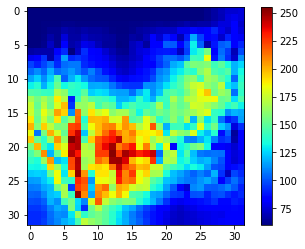

In [ ]:
plt.imshow(np.mean(guided_gradcam,axis=2),cmap='jet')
plt.colorbar()

In [ ]:
x = od_test_images[4]
chosen_class = np.argmax(train_labels[5])
upsample_size = x.shape[0:2]
guidedBP = GuidedBackprop(model=model,layerName=last_conv_layer)

cv2.imwrite('sample.png',x*255)
img = cv2.imread('sample.png')

gb = guidedBP.guided_backprop(np.expand_dims(x,axis=0), upsample_size)
gb_im = deprocess_image(gb)
gb_im = gb_im.astype('float32')/255

heatmap_gcam = resize(grad_cam_plus(x,model,last_conv_layer).numpy(),upsample_size)
#np.expand_dims(color.rgb2gray(gb_im),axis=3)

#guided_GCAMplus = gb_im*np.tile(np.expand_dims(heatmap_gcam,2),3)
guided_GCAMplus = color.rgb2gray(gb_im)*heatmap_gcam

In [ ]:
heatmap_gcam.dtype

dtype('float32')

In [ ]:
guided_GCAMplus.min()

0.0

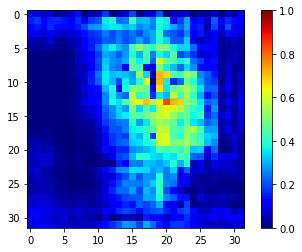

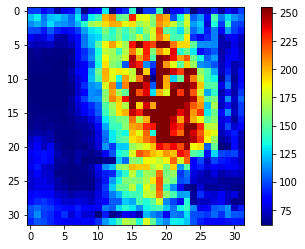

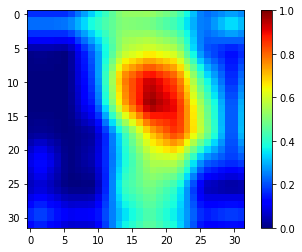

In [ ]:
plt.imshow(guided_GCAMplus,vmin=0,vmax=1,cmap='jet')
plt.colorbar()
plt.show()
plt.imshow(deprocess_image(guided_GCAMplus),cmap='jet')
plt.colorbar()
plt.show()
plt.imshow(heatmap_gcam,vmin=0,vmax=1,cmap='jet')
plt.colorbar()
plt.show()

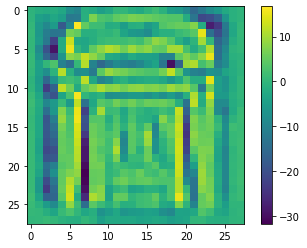

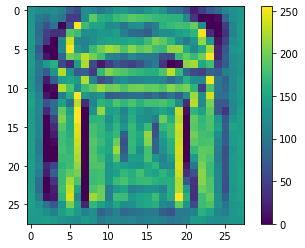

In [ ]:
plt.imshow(gb)
plt.colorbar()
plt.show()
plt.imshow(gb_im)
plt.colorbar()
plt.show()

(28, 28)

### Creation of Heatmaps for each class

In [ ]:
model.evaluate(test_images,test_labels)

313/313 [==============================] - 16s 2ms/step - loss: 0.0403 - accuracy: 0.9881


[0.04030995815992355, 0.988099992275238]

In [ ]:
# Creamos una copiar de train pero shuffleada, y aquí será donde busquemos las 1000 imagenes por clase para 
seed = 8
train_images_shuffled, train_labels_shuffled = shuffle(train_images,train_labels,random_state=seed)

In [ ]:
from src.gradcam import GradCAM, overlay_gradCAM
from src.guidedBackprop import GuidedBackprop, deprocess_image
from src.utils import preprocess, predict, SAMPLE_DIR, array2bytes, DECODE, INV_MAP

# Creación de array con N heatmaps por clase, para realizar clusterización sobre ellos (15 mins wide Resntet). Shape = (clases,num_heatmaps,height,width)
n_instancias = 1000
array_heatmaps_train_x_clase = n_heatmaps_x_clase_guidedbackprop(n_instancias,train_images_shuffled,train_labels_shuffled) 
cop_seg_array_heatmaps_train_x_clase = array_heatmaps_train_x_clase.copy()

Option 1: Randomly

In [ ]:
# Creación de array con N heatmaps por clase, para realizar clusterización sobre ellos (15 mins wide Resntet). Shape = (clases,num_heatmaps,height,width)
n_instancias = 1000
array_heatmaps_train_x_clase = n_heatmaps_x_clase(n_instancias,train_images_shuffled,train_labels_shuffled) 
cop_seg_array_heatmaps_train_x_clase = array_heatmaps_train_x_clase.copy()

100%|██████████| 10/10 [03:02<00:00, 18.27s/it]


Optiong 2: Only if the image was correctly predicted will be used for representing the dataset

In [ ]:
# Creación de array con N heatmaps por clase, para realizar clusterización sobre ellos SOLO SI ESTAN BIEN PREDICHOS (3-4 mins)
n_instancias = 1000
predicciones_train_shuffled = np.argmax(model.predict(train_images_shuffled),axis=1)
array_heatmaps_train_x_clase_preds_buenas = n_heatmaps_x_clase_bien_predichos(n_instancias,train_images_shuffled,train_labels_shuffled,predicciones_train_shuffled)
array_heatmaps_train_x_clase = array_heatmaps_train_x_clase_preds_buenas
cop_seg_array_heatmaps_train_x_clase_preds_buenas = array_heatmaps_train_x_clase_preds_buenas.copy()

100%|██████████| 10/10 [03:15<00:00, 19.52s/it]


In [ ]:
array_heatmaps_train_x_clase = cop_seg_array_heatmaps_train_x_clase

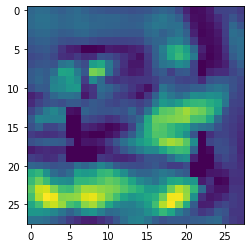

In [ ]:
plt.imshow(array_heatmaps_train_x_clase[2,25])

In [ ]:
array_heatmaps_train_x_clase[2,999].max()

1.0

## General Approach 1: Heatmaps mean/median for each class. Calculation 

In [ ]:
# Creamos una lista con los heatmaps PROMEDIO o MEDIANA de cada clase
lista_htmaps_prom_x_clase  = []
modo_prom_med              = 'mediana'
for clase in range(num_clases):
  lista_htmaps_prom_x_clase.append(calculo_htmaps_promedio_mediana(array_heatmaps_train_x_clase[clase],modo=modo_prom_med))

### Plotting the heatmaps for each class

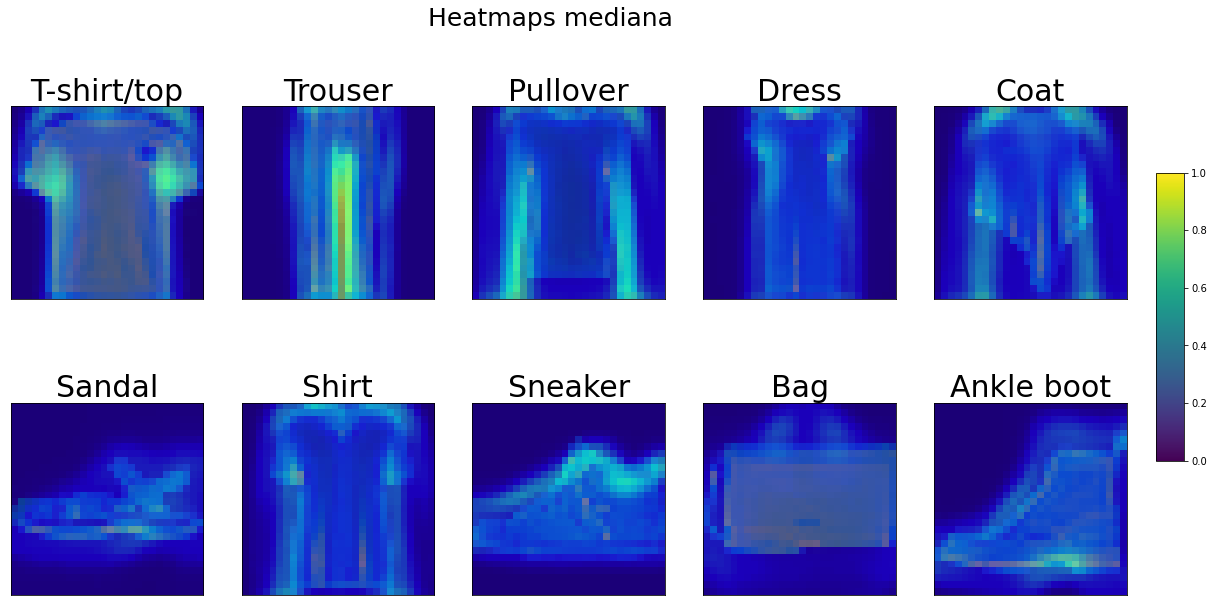

In [ ]:
# Definimos si queremos reescalar el heatmap o no y si queremos representar algun numero debajo o no
rescalar_img = True
htmap_superpuestos = True

# Representamos cada uno de los heatmaps en orden
fig, ax = plt.subplots(2, 5, clear=True, figsize=[20,10])
fig.suptitle('Heatmaps {}'.format(modo_prom_med), fontsize=25)

for i in range(2):
  for j in range(5):
    indice_num = buscar_num(j+i*(5),0,train_labels_shuffled)
    img = plot_heatmap(ax,i,j,lista_htmaps_prom_x_clase[j+i*(5)],rescalar_img,title=class_names[j+i*(5)], superimposed_img = htmap_superpuestos,imagen=train_images_shuffled[indice_num,:,:,0])


cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.4])
fig.colorbar(img[0][0].get_images()[0], cax=cbar_ax)

plt.savefig('./Heatmaps_{}_x_clase.pdf'.format(modo_prom_med))

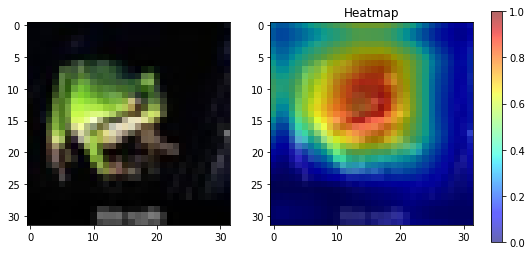

In [ ]:
clase = 6
indi = 456
pos = buscar_num(clase,0,train_labels_shuffled,indi)

fig , ax = plt.subplots(1,2,figsize=(8,16))
plt.subplot(121).imshow(train_images_shuffled[pos[0]],vmin=0,vmax=1)
plt.subplot(122).imshow(train_images_shuffled[pos[0]],vmin=0,vmax=1)
im = plt.subplot(122).imshow(resize(array_heatmaps_train_x_clase[clase,indi],(32,32)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
plt.subplot(122).set_title('Heatmap')
cbar_ax = fig.add_axes([0.93, 0.4, 0.02, 0.2])
plt.colorbar(im,cax=cbar_ax)

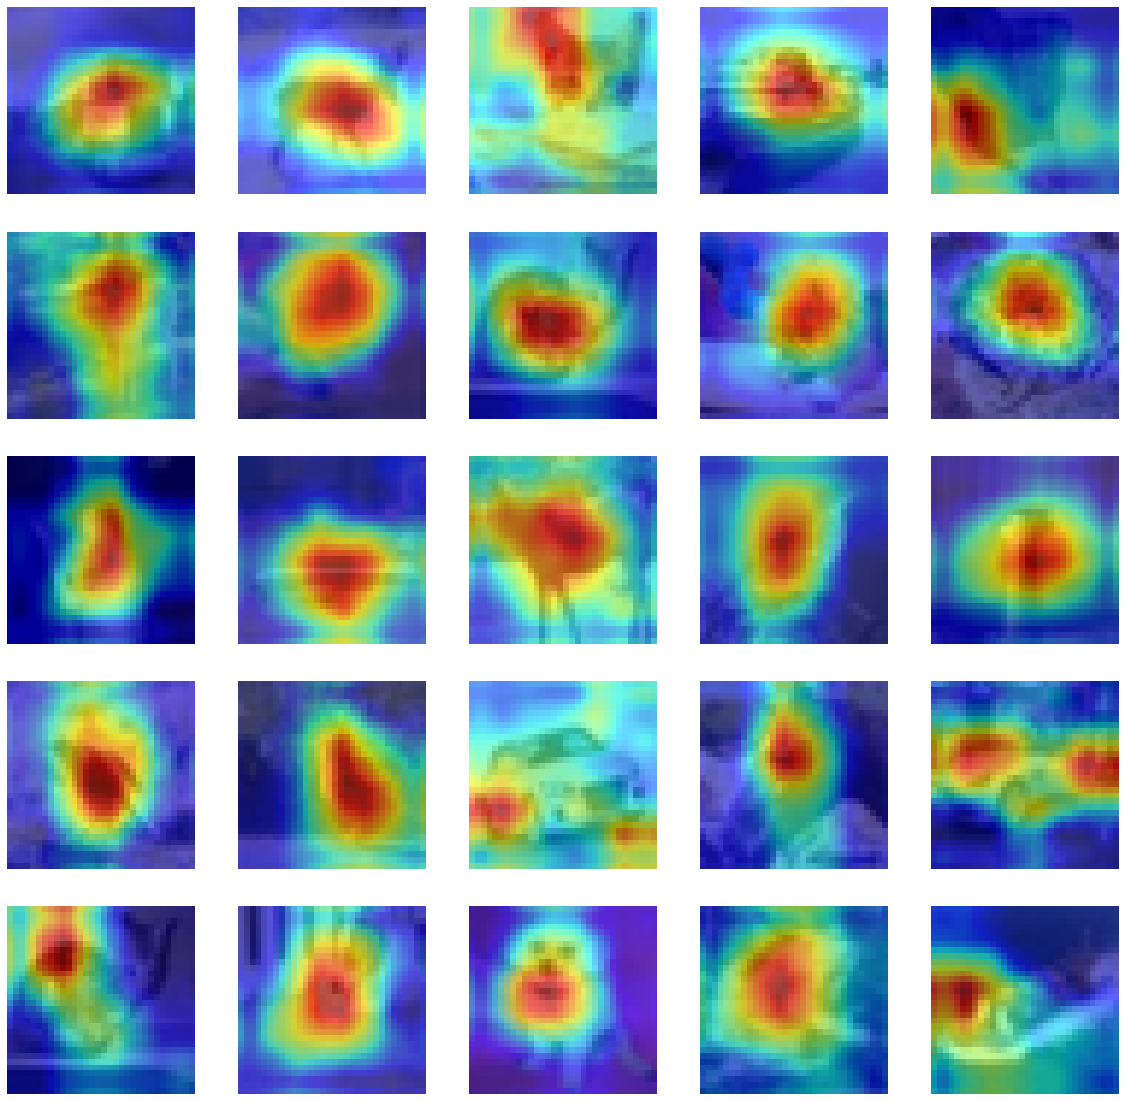

In [ ]:
rows = 5
fig, axes1 = plt.subplots(rows,rows,figsize=(20,20))
for j in range(rows):
    for k in range(rows):
        i  = np.random.choice(range(len(array_heatmaps_train_x_clase[0])))
        cl = np.random.choice(range(len(array_heatmaps_train_x_clase)))
        pos = buscar_num(cl,0,train_labels_shuffled,i)
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(train_images_shuffled[pos[0]:pos[0]+1][0])
        axes1[j][k].imshow(resize(array_heatmaps_train_x_clase[cl][i],(32,32),),alpha=0.6,vmax=1,vmin=0,cmap='jet')


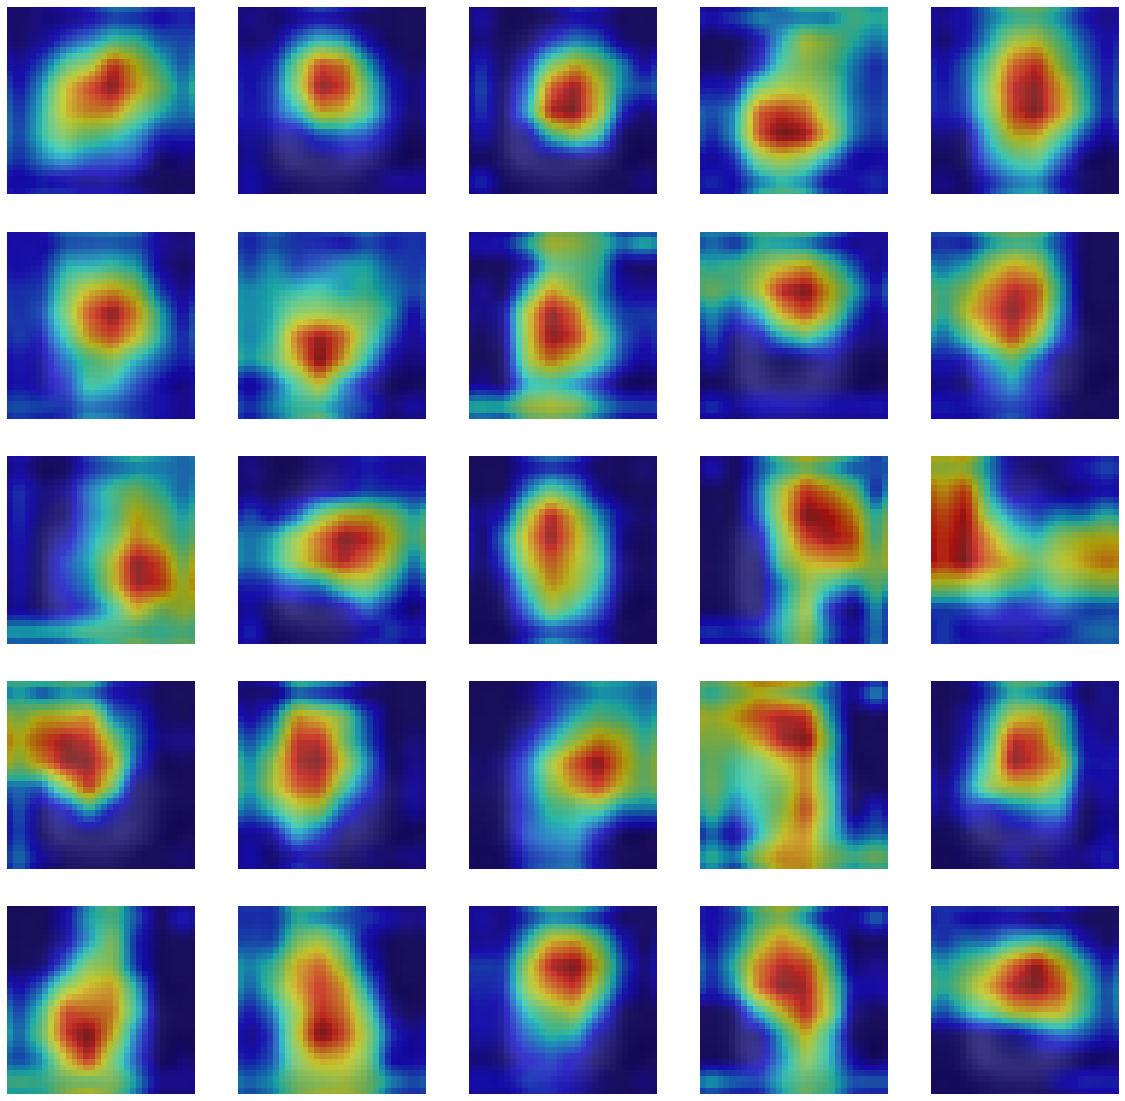

In [ ]:
rows = 5
fig, axes1 = plt.subplots(rows,rows,figsize=(20,20))
for j in range(rows):
    for k in range(rows):
        i  = np.random.choice(range(len(od_test_images)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(od_test_images[pos[0]:pos[0]+1][0])
        axes1[j][k].imshow(resize(array_htmaps_od[i],(32,32),),alpha=0.6,vmax=1,vmin=0,cmap='jet')

Label:		 1
Prediccion:	 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


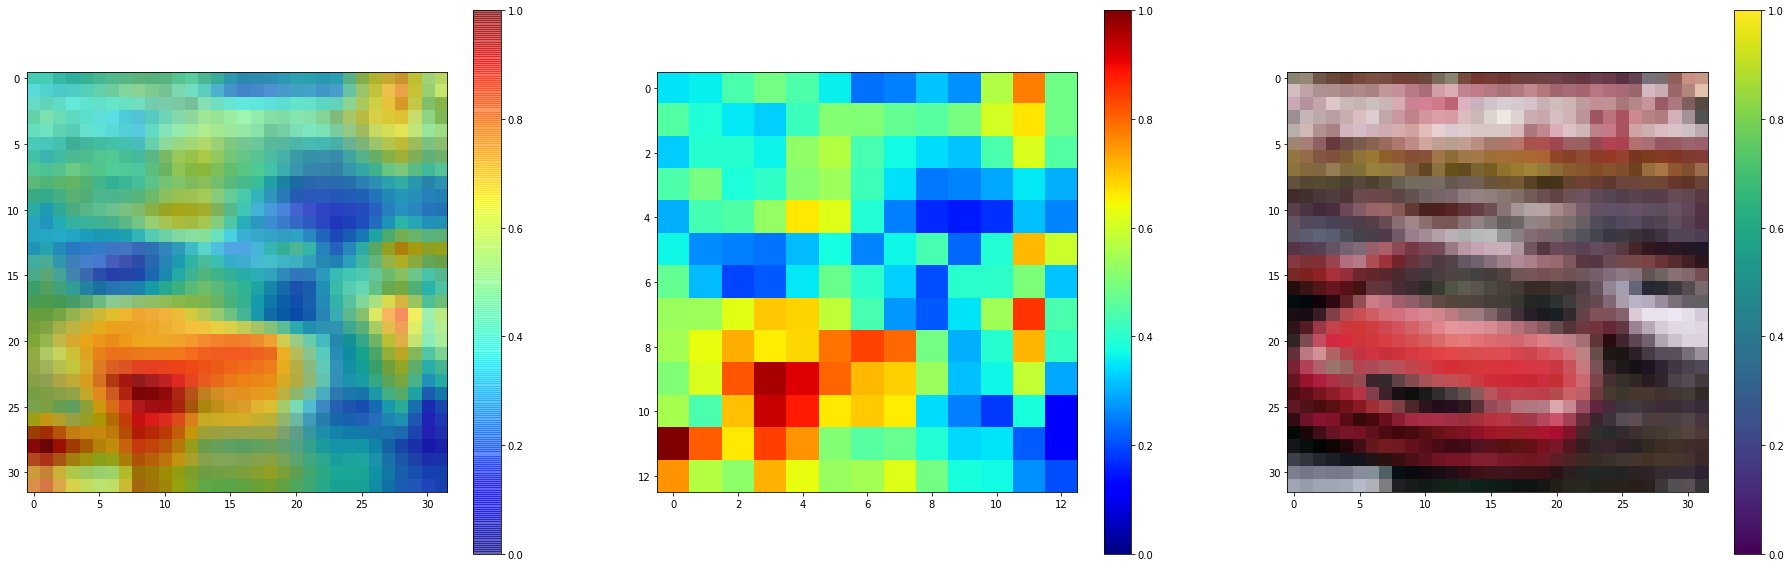

In [ ]:
pos = 1543
print('Label:\t\t',np.argmax(train_labels_shuffled[pos]))
print('Prediccion:\t',np.argmax(model.predict(np.expand_dims(train_images_shuffled[pos],axis=0))))
plt.subplots(1,3,figsize=(32,10))
plt.subplot(131).imshow(train_images_shuffled[pos],vmin=0,vmax=1)
im = plt.subplot(131).imshow(resize(grad_cam_plus(train_images_shuffled[pos],model,last_conv_layer,category_id=np.argmax(train_labels_shuffled[pos])),(32,32)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
plt.colorbar(im)
im = plt.subplot(132).imshow(grad_cam_plus(train_images_shuffled[pos],model,last_conv_layer,category_id=np.argmax(train_labels_shuffled[pos])),cmap='jet',vmin=0,vmax=1)
plt.colorbar(im)
im = plt.subplot(133).imshow(train_images_shuffled[pos],vmin=0,vmax=1)
plt.colorbar(im)

plt.show()

## General Approach 2: Clusters for each class

Calculation of SSIM distances between the heatmaps of each class for clustering

In [ ]:
# Creación de la matriz con los valores de SSIM por pares. Creamos matriz triangular superior (15 mins aprox)
matriz_ssim_completa = np.zeros((num_clases,array_heatmaps_train_x_clase.shape[1],array_heatmaps_train_x_clase.shape[1])) 
for clase in range(num_clases):
  matriz_ssim_completa[clase] = matriz_ssim_x_pares(array_heatmaps_train_x_clase[clase])
  print('Clase {} terminada'.format(class_names[clase]))

Clase 0 terminada
Clase 1 terminada
Clase 2 terminada
Clase 3 terminada
Clase 4 terminada
Clase 5 terminada
Clase 6 terminada
Clase 7 terminada
Clase 8 terminada
Clase 9 terminada


In [ ]:
# Creamos matriz completa
matriz_ssim_completa_triang_sup = matriz_ssim_completa.copy()
for clase in range(num_clases):
  for i in range(matriz_ssim_completa[clase].shape[0]):

    for j in range(i+1,matriz_ssim_completa[clase].shape[0]):
      matriz_ssim_completa[clase,j,i] = matriz_ssim_completa[clase,i,j]

  print('Clase {} terminada'.format(class_names[clase]))

Clase 0 terminada
Clase 1 terminada
Clase 2 terminada
Clase 3 terminada
Clase 4 terminada
Clase 5 terminada
Clase 6 terminada
Clase 7 terminada
Clase 8 terminada
Clase 9 terminada


In [ ]:
# Comprobacion
print(matriz_ssim_completa[5]-np.transpose(matriz_ssim_completa[5]))
matriz_ssim_completa_triang_sup[1,25]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.24231854, 0.32169531, 0.22146614, 0.29513895,
       0.37099911, 0.23835914, 0.18535639, 0.32475081, 0.29316731,
       0.23495357, 0.36343325, 0.25602129, 0.36095309, 0.32466246,
       0.26725382, 0.3786861 , 0.38947032, 0.2723391 , 0.32343554,
       0.33642235, 0.3873701 , 0.36302201, 0.2694114 , 0.20325302,
       0.30842723, 0.2882198 , 0.34628198, 0.21630011, 0.32977365,
       0.3770201 , 0.32867341, 0.32300844, 0.2950694 , 0.33896892,
       0.20729313, 0.39315021, 0.24090949, 0.23406078, 0.34615249,
       0.26411308, 0.38061955, 0.36255814, 0.21015175, 0.34310498,
       0.39874653, 0.14350295, 0.34417382, 0.38660826, 0.10179

### Option 1: Hierarchical clustering

Same threshold for all the clases

In [ ]:
# Same distance threshold for each class
distance_threshold=0.71

In [ ]:
# Select a distance threshold for each class
distance_threshold = []
dist_thrs          = np.linspace(0.45,0.90,60)
silhScoresPerClass = []
array_labels_agg_x_clase = np.zeros((num_clases,matriz_ssim_completa.shape[1]))

for clase in range(num_clases):
  dunnIndexes = []
  silh_scores = []
  for dist in tqdm(dist_thrs):
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=dist)
    cluster_model.fit(matriz_ssim_completa[clase])
    array_labels_agg_x_clase[clase] = cluster_model.labels_
    #dunnIndexes.append(dunn(array_labels_agg_x_clase[clase],matriz_ssim_completa[clase],diameter_method='farthest',cdist_method='nearest'))
    try:
      silh_scores.append(silhouette_score(matriz_ssim_completa[clase],array_labels_agg_x_clase[clase],metric='precomputed'))
    except:
      silh_scores.append(0)
  
  silhScoresPerClass.append(silh_scores)

  for i,score in enumerate(silh_scores[::-1]):
    if i != 0:
      if score < score_anterior:
        # Nos quedamos con el indice del numero que está justo antes de que la pendiente descienda (más abajo los plots)
        distance_threshold.append(dist_thrs[len(silh_scores)-(i)])
        break
    score_anterior = score
  '''
  # Coge el dunn index anterior a que se convierta en 0
  for i,index in enumerate(dunnIndexes[::-1]):
    if index != 0:
      # Nos quedamos con el indice anterior al frontera con el dunn = 0
      distance_threshold.append(dist_thrs[len(dunnIndexes)-1-(i+1)])
      break
  '''

100%|██████████| 60/60 [00:01<00:00, 41.30it/s]


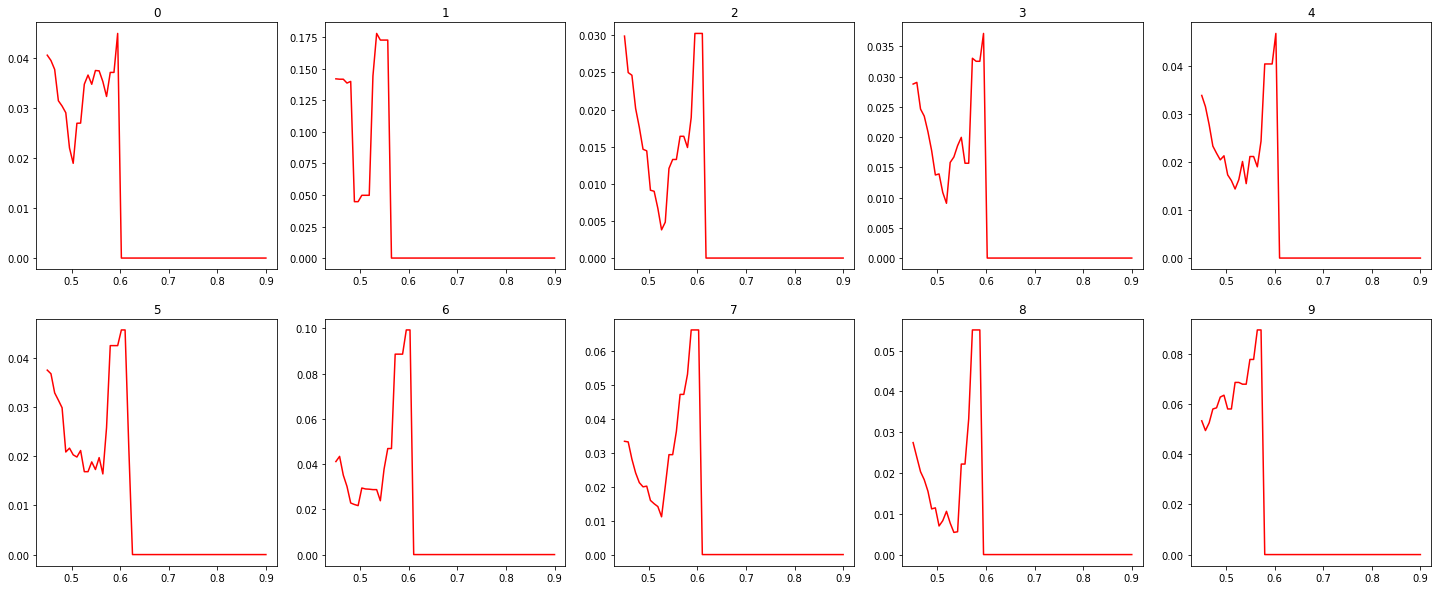

In [ ]:
# Plot to see the silhouette scores
plt.subplots(2,5,figsize=(25,10))
for clase,pos in enumerate(range(1,11)):
  plt.subplot(2,5,pos).plot(dist_thrs,silhScoresPerClass[clase],color='red')
  plt.title(class_names[clase])
plt.savefig('silhouetteScores.pdf')

In [ ]:
distance_threshold

[0.5949152542372882,
 0.5338983050847458,
 0.5949152542372882,
 0.5949152542372882,
 0.6025423728813559,
 0.6025423728813559,
 0.5949152542372882,
 0.5872881355932204,
 0.5720338983050848,
 0.5644067796610169]

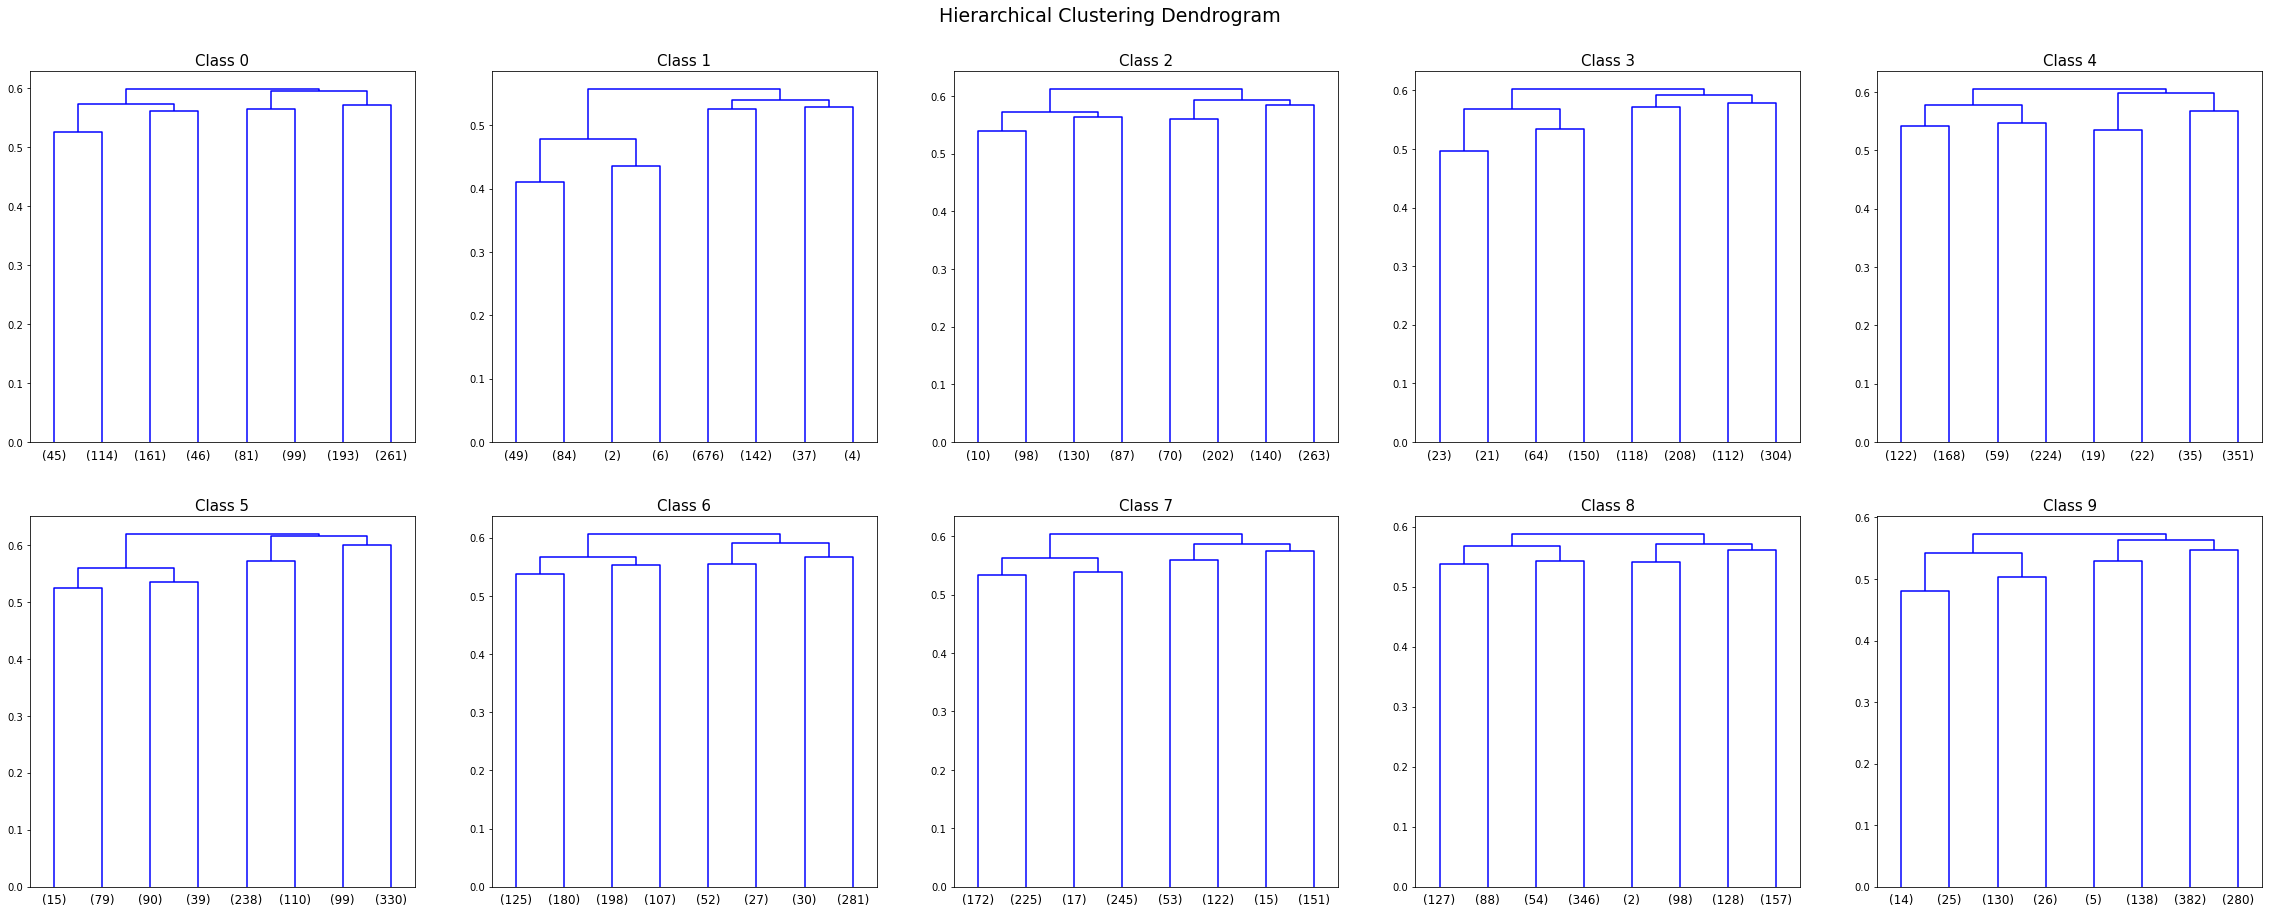

In [ ]:
# Function that creates de clusters of each class

# Initialization of the array containing the labels of the labels for each image in each class
array_labels_agg_x_clase = np.zeros((num_clases,matriz_ssim_completa.shape[1]))

# plot the top three levels of the dendrogram
w = 40
h = 15
fig,ax = plt.subplots(2,5,figsize=(w,h))
fig.suptitle('Hierarchical Clustering Dendrogram',fontsize = h + w*0.1,y=0.94)
#fig.supxlabel('X axis: Number of points in node (index of the number if not in parenthesis)',fontsize = h + w*0.1,y=0.065)
for clase in range(num_clases):
  if isinstance(distance_threshold,list):
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=distance_threshold[clase])
  else:
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=distance_threshold)
  cluster_model.fit(matriz_ssim_completa_triang_sup[clase])
  array_labels_agg_x_clase[clase] = cluster_model.labels_

  # Para que se realize el dendrograma
  if clase < 5:
    i = 0
    j = clase
  else:
    i = 1
    j = clase - 5

  plot_dendrogram(cluster_model, truncate_mode='level', p=2, ax=ax[i,j])
  ax[i,j].set_title('Class {}'.format(class_names[clase]),fontsize = h)
  #ax[i,j].set_xlabel("Number of points in node",fontsize=h)

plt.savefig('DendrogramPerClass.pdf')
fig.show()

In [ ]:
for clase in range(num_clases):
  a = array_labels_agg_x_clase[clase]
  unique, counts = np.unique(a, return_counts=True)
  print('Clase',class_names[clase].ljust(15),'\t',dict(zip(unique, counts)))
  print('-'*75)

Clase 0               	 {0.0: 634, 1.0: 366}
---------------------------------------------------------------------------
Clase 1               	 {0.0: 41, 1.0: 141, 2.0: 818}
---------------------------------------------------------------------------
Clase 2               	 {0.0: 675, 1.0: 325}
---------------------------------------------------------------------------
Clase 3               	 {0.0: 742, 1.0: 258}
---------------------------------------------------------------------------
Clase 4               	 {0.0: 427, 1.0: 573}
---------------------------------------------------------------------------
Clase 5               	 {0.0: 429, 1.0: 223, 2.0: 348}
---------------------------------------------------------------------------
Clase 6               	 {0.0: 390, 1.0: 610}
---------------------------------------------------------------------------
Clase 7               	 {0.0: 341, 1.0: 659}
---------------------------------------------------------------------------
Clase 8      

### Trying to optimize the clustering

Find the threshold for each class that maximizes the Dunn index or the Silhouette score

In [ ]:
def clusters_score_AgglomerativeClustering(distance_threshold,m_ssim_completaUnaClase,score_method,linkage='complete',diameter_method='farthest',cdist_method='nearest'):
  '''
  Function that returns the Dunn or Silhouette score for a give distance matrix of a given class
  '''
  # Clustering
  cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage=linkage,distance_threshold=distance_threshold)
  cluster_model.fit(m_ssim_completaUnaClase)
  a_labels_de_cada_clusterUnaClase = cluster_model.labels_

  if len(np.unique(a_labels_de_cada_clusterUnaClase)) <=1:

    return 1000

  # Calculating scores
  if score_method == 'dunn':
    score = -dunn(a_labels_de_cada_clusterUnaClase,m_ssim_completaUnaClase,diameter_method='farthest',cdist_method='nearest')

  elif score_method == 'silhouette':
    score =  -silhouette_score(m_ssim_completaUnaClase,a_labels_de_cada_clusterUnaClase,metric='precomputed')

  else:
    raise ValueError(
        'No method for that value'
    )

  return score

In [ ]:
# Hyperparameters
scoreMethod          = 'dunn'
linkage_agg          = 'complete'
diameter_method_dunn = 'farthest'
cdist_method_dunn    = 'nearest'

# Initialization of the array containing the labels of the labels for each image in each class
array_labels_agg_x_clase = np.zeros((num_clases,matriz_ssim_completa.shape[1]))
thresholPerClass         = []
scorePerClass            = []
for clase in tqdm(range(num_clases)):
 
  # Minimize the -score, maximize the score
  sol = minimize_scalar(clusters_score_AgglomerativeClustering,args=(matriz_ssim_completa[clase],scoreMethod,linkage_agg,diameter_method_dunn,cdist_method_dunn),method='bounded',bounds=(0.5,0.8),options={'xatol': 0.001,'maxiter': 100, 'disp': 0})
  
  # Distance threshold that maximizes the score
  dist_thr = sol.x

  # Construction of threshold, scores and labels
  thresholPerClass.append(dist_thr)
  scorePerClass.append(-clusters_score_AgglomerativeClustering(dist_thr,matriz_ssim_completa[clase],scoreMethod,linkage_agg,diameter_method_dunn,cdist_method_dunn))
  cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=dist_thr)
  cluster_model.fit(matriz_ssim_completa[clase])
  array_labels_agg_x_clase[clase] = cluster_model.labels_

In [ ]:
print(thresholPerClass,'\n',scorePerClass)

In [ ]:
dunnIndexes = []
silh_scores = []
dist_thrs   = np.linspace(0.45,0.78,31)
clase       = 5
for dist in tqdm(dist_thrs):
  cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=dist)
  cluster_model.fit(matriz_ssim_completa[clase])
  array_labels_agg_x_clase[clase] = cluster_model.labels_
  dunnIndexes.append(dunn(array_labels_agg_x_clase[clase],matriz_ssim_completa[clase],diameter_method='farthest',cdist_method='nearest'))
  try:
    silh_scores.append(silhouette_score(matriz_ssim_completa[clase],array_labels_agg_x_clase[clase],metric='precomputed'))
  except:
    silh_scores.append(0)

In [ ]:
# Select a distance threshold for each class
#distance_threshold = []
dist_thrs            = np.linspace(0.45,0.78,40)
dunnIndexesPerClass  = []
silhScoresPerClass   = []
for clase in range(num_clases):
  
  dunnIndexes = []
  silh_scores = []
  for dist in tqdm(dist_thrs):
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=dist)
    cluster_model.fit(matriz_ssim_completa[clase])
    array_labels_agg_x_clase[clase] = cluster_model.labels_
    dunnIndexes.append(dunn(array_labels_agg_x_clase[clase],matriz_ssim_completa[clase],diameter_method='farthest',cdist_method='nearest'))
    try:
      silh_scores.append(silhouette_score(matriz_ssim_completa[clase],array_labels_agg_x_clase[clase],metric='precomputed'))
    except:
      silh_scores.append(0)

  dunnIndexesPerClass.append(dunnIndexes)
  silhScoresPerClass.append(silh_scores)

In [ ]:
plt.subplots(2,5,figsize=(25,10))
for clase,pos in enumerate(range(1,11)):
  plt.subplot(2,5,pos).plot(dist_thrs,silhScoresPerClass[clase],color='red')
  plt.title(class_names[clase])

In [ ]:
clase = 1
plt.plot(dist_thrs,dunnIndexesPerClass[clase],color='blue')
plt.show()
plt.plot(dist_thrs,silhScoresPerClass[clase],color='red')
plt.show()

In [ ]:
dist_thrs[12]

In [ ]:
def histDispersionClusters(clusters,):
  '''
  Function that receives median of the clusters and generates or plots the histograms
  '''

  ssimPerCluster = []
  for indexImage1 in range(len(clusters)):
      ssimPerCluster.append(intraSSIM = []
      for indexImage2 in range(len(clusters)):
          if not indexImage1 == indexImage2:
            intraSSIM.append(ssim(images[indexImage1],images[indexImage2]))
      ssimAccum.append(np.mean(intraSSIM))


In [ ]:
from dunn_sklearn import *

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
dunn_values       = []
silhouette_values = []
for clase in range(num_clases):
  dunn_values.append(dunn(array_labels_de_cada_cluster[clase],matriz_ssim_completa[clase],diameter_method='farthest',cdist_method='nearest'))
  silhouette_values.append(silhouette_score(matriz_ssim_completa[clase],array_labels_de_cada_cluster[clase],metric='precomputed'))

print(dunn_values)
print(silhouette_values)

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# plot the top three levels of the dendrogram
fig,ax = plt.subplots(1,1,figsize=(10,6))
plot_dendrogram(cluster_model, truncate_mode='level', p=3, ax=ax)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
plt.plot(b)

### Option 2: DBSCAN or OPTICS

In [ ]:
'''
Si hierarchical clustering no sale, habrá que probar este método
''' 

## Creation of the clusters mean/medians

Heatmaps mean/median of clusters

In [ ]:
# Calculo de los heatmaps por cada cluster (0 segundos)
array_labels_de_cada_cluster  = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster = []
modo_heatmaps                     = 'promedio'
for clase in range(num_clases):
  lista_htmaps_prom_x_clase_cluster.append(calculo_htmaps_x_cluster(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=modo_heatmaps))

Heatmaps mean/median of clusters but only for the more similar heatmaps in the cluster

In [ ]:
# Calculo de los heatmaps por cada cluster (15 mins)
array_labels_de_cada_cluster      = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster = []
modo_heatmaps                     = 'promedio'
percentMostSimilar                = 0.1
for clase in tqdm(range(num_clases)):
  lista_htmaps_prom_x_clase_cluster.append(calculo_htmaps_x_cluster_similares(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=modo_heatmaps,thr=percentMostSimilar))
copia_seg_lista_htmaps_prom_x_clase_cluster = lista_htmaps_prom_x_clase_cluster.copy()

100%|██████████| 10/10 [20:21<00:00, 122.16s/it]


Quantile heatmaps for each cluster of each class

In [ ]:
#OPTION 1
# Calculo de los heatmaps por cada cluster con CUANTILES FRONTERA (2 segundos)
array_labels_de_cada_cluster                = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster_cuantiles = []
modo                                        = 'cuantiles'
cuantiles                                   = [0,0.25,0.5,0.75,0.99] # SIEMPRE incluir 0 al inicio, que será la propia mediana
for clase in range(num_clases):
  lista_htmaps_prom_x_clase_cluster_cuantiles.append(calculo_htmaps_x_cluster(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=modo,cuantiles=cuantiles))

In [ ]:
#OPTION 2
# Calculo de los heatmaps por cada cluster con CUANTILES haciendo el promedio de cada cuantil (2 segundos)
array_labels_de_cada_cluster                = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster_cuantiles = []
quantiles_mode                              = 'mediana'
cuantiles                                   = [0,0.1,0.25,0.35,0.5] # SIEMPRE incluir 0 al inicio, que será la propia mediana
for clase in tqdm(range(num_clases)):
  lista_htmaps_prom_x_clase_cluster_cuantiles.append(quantile_class_heatmap_calculation(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=quantiles_mode,quantiles=cuantiles))

100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Heatmaps thresholding to minimize de intercluster similarity 

In [ ]:
# Creamos el array con los thresholds
array_thresholds = np.zeros((num_clases))

for clase in range(num_clases):
  # Definimos los minimos y maximos posibles del threshold, la aproximacion inicial y el limite del valor de threshold
  min_thr = np.max(np.min(np.min(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)) + (np.mean(lista_htmaps_prom_x_clase_cluster[clase])-np.max(np.min(np.min(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)))/2
  max_thr = np.min(np.max(np.max(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)) + (np.mean(lista_htmaps_prom_x_clase_cluster[clase])-np.min(np.max(np.max(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)))/2
  thr_ini = (np.median(lista_htmaps_prom_x_clase_cluster[clase][0]))
  bounds = (min_thr,max_thr)
  

  res = minimize_scalar(similaridad, thr_ini ,args=(lista_htmaps_prom_x_clase_cluster[clase]), bounds=bounds, method='bounded')
  array_thresholds[clase] = res.x

  # Si solo hay un cluster, he cogido el valor mediana
  if lista_htmaps_prom_x_clase_cluster[clase].shape[0] == 1:
    array_thresholds[clase] = thr_ini

In [ ]:
# Aplicamos el threshold a cada clase

# Copiamos a una nueva lista los arrays para no modificarlos
lista_htmaps_prom_x_clase_cluster_threshold = []
for i,clusters in enumerate(lista_htmaps_prom_x_clase_cluster):
  lista_htmaps_prom_x_clase_cluster_threshold.append(clusters.copy())

for clase in range(num_clases):
  for i in range(len(lista_htmaps_prom_x_clase_cluster_threshold[clase])):
    
    # Aplicamos el threshold a cada centroide
    lista_htmaps_prom_x_clase_cluster_threshold[clase][i] = aplicar_threshold_a_htmap(np.copy(lista_htmaps_prom_x_clase_cluster_threshold[clase][i].copy()),array_thresholds[clase])


## Plotting the heatmaps mean/median of each CLUSTER of each CLASS

Mean/median heatmaps of the clusters


In [ ]:
lista_htmaps_prom_x_clase_cluster = copia_seg_lista_htmaps_prom_x_clase_cluster

In [ ]:
from matplotlib.transforms import Bbox

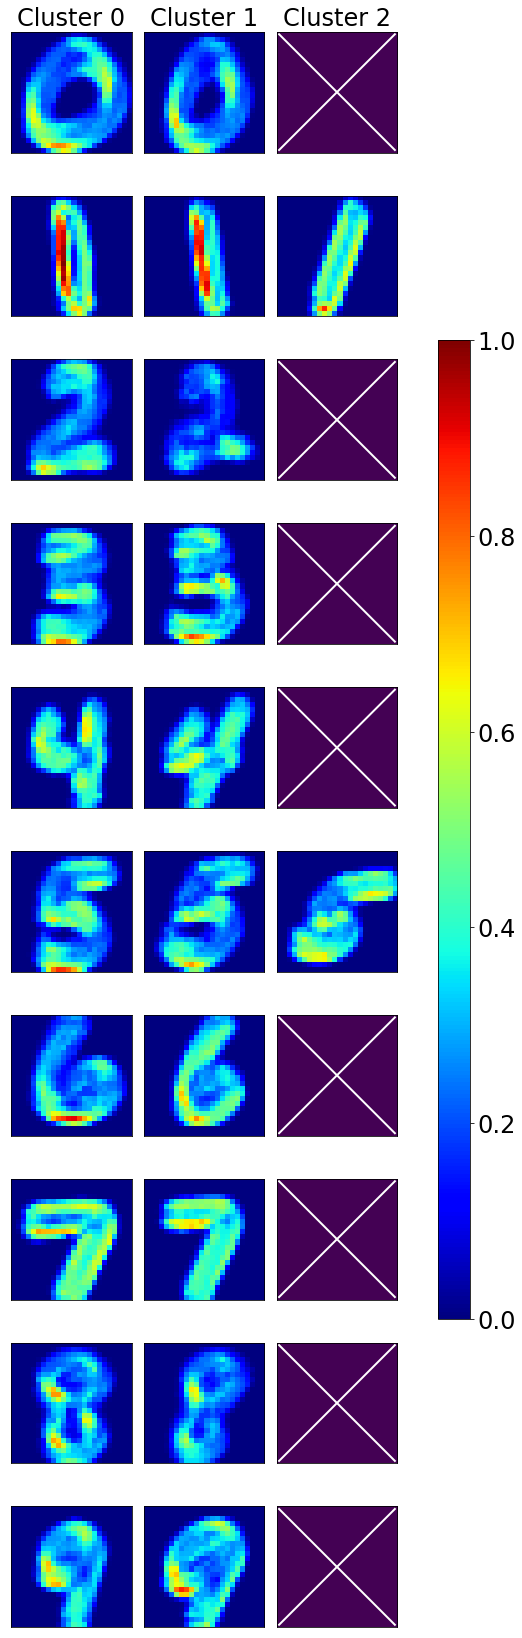

In [ ]:
# Plot de los heatmaps de cada clase
superpuesto = False

# Calculo del nº max de columnas
l_max_cols = []
for htmap_prom_cluster in lista_htmaps_prom_x_clase_cluster:
  l_max_cols.append(len(htmap_prom_cluster))
max_cols= max(l_max_cols)

# Plots
fig, ax = plt.subplots(nrows=num_clases,ncols=max_cols, figsize = (3*max_cols,3*num_clases),sharex=True,sharey=True,constrained_layout=False,tight_layout=False)


for clase in range(num_clases):

  for cluster in range(len(lista_htmaps_prom_x_clase_cluster[clase])):
    
    if superpuesto == False:
      im = ax[clase,cluster].imshow(lista_htmaps_prom_x_clase_cluster[clase][cluster],cmap='jet',vmin=0,vmax=1)
      
    elif superpuesto == True:
      indice_num = buscar_num(clase,0,train_labels_shuffled)
      ax[clase,cluster].imshow(train_images_shuffled[indice_num[0],:,:,0])
      im = ax[clase,cluster].imshow(resize(lista_htmaps_prom_x_clase_cluster[clase][cluster],(train_images_shuffled.shape[1:3])),alpha = 0.6,cmap='jet',vmin=0,vmax=1) # Guardo la AxesImage para tener el colorbar
    
    if clase == 0:
      ax[clase,cluster].set_title('Cluster {}'.format(cluster),fontsize=12+4*max_cols)
      ax[clase,cluster].set_xticks([])
      ax[clase,cluster].set_yticks([])
      
    # Comentar la linea del if para no plotear las palabras
    if cluster == 0:
      #ax[clase,cluster].set_ylabel(class_names[clase].title(),rotation = 90, fontsize=12+4*max_cols)
      pass

  if len(lista_htmaps_prom_x_clase_cluster[clase]) != max_cols:
    for indice_ax_vacio in range(len(lista_htmaps_prom_x_clase_cluster[clase]),max_cols):
      ax[clase][indice_ax_vacio].imshow(np.zeros(np.shape(lista_htmaps_prom_x_clase_cluster[clase][cluster])),vmin=0,vmax=1)
      ax[clase,indice_ax_vacio].plot([0,len(lista_htmaps_prom_x_clase_cluster[clase][cluster])-1],[len(lista_htmaps_prom_x_clase_cluster[clase][cluster])-1,0],c='w',lw=2)
      ax[clase,indice_ax_vacio].plot([0,len(lista_htmaps_prom_x_clase_cluster[clase][cluster])-1],[0,len(lista_htmaps_prom_x_clase_cluster[clase][cluster])-1],c='w',lw=2)
      if clase == 0:
        ax[clase,indice_ax_vacio].set_title('Cluster {}'.format(indice_ax_vacio),fontsize=12+4*max_cols)
        ax[clase,indice_ax_vacio].set_xticks([])
        ax[clase,indice_ax_vacio].set_yticks([])

plt.subplots_adjust( 
                    wspace=0.1, 
                    hspace=0.05)


cbar = fig.colorbar(im, ax=ax, shrink=0.6, pad=0.08, aspect=30)
cbar.ax.tick_params(labelsize=12+max_cols*4)


plt.savefig('./Heatmaps_x_clase_y_cluster_{}.pdf'.format(modo_heatmaps),dpi=40,bbox_inches='tight')
plt.savefig('./Heatmaps_x_clase_y_cluster_{}.png'.format(modo_heatmaps),dpi=250,bbox_inches='tight')


#plt.savefig('./Crop.pdf'.format(modo_heatmaps),dpi=40,bbox_inches=Bbox([[0, 3], [9, 27]]))

Quantile heatmaps

In [ ]:
# Plot de los heatmaps de cada clase
superpuesto = False

# Calculo del nº max de columnas

# Plots
for clase in range(num_clases):
  n_clusters     = lista_htmaps_prom_x_clase_cluster_cuantiles[clase].shape[0]
  n_cuantiles    = lista_htmaps_prom_x_clase_cluster_cuantiles[clase].shape[1]
  fig, ax = plt.subplots(nrows=n_clusters,ncols=n_cuantiles, figsize = (n_cuantiles*5,n_clusters*2.5),sharex=True,sharey=True)
  for cluster in range(n_clusters):
    for cuantil in range(n_cuantiles):
        
      if superpuesto == False:
        im = ax[cluster,cuantil].imshow(lista_htmaps_prom_x_clase_cluster_cuantiles[clase][cluster,cuantil],cmap='jet',vmin=0,vmax=1)
        ax[cluster,cuantil].set_title('cuantil {}'.format(cuantiles[cuantil]),fontsize=25)
        ax[cluster,cuantil].set_xticks([])
        ax[cluster,cuantil].set_yticks([])

      elif superpuesto == True:
        indice_num = buscar_num(clase,0,train_labels_shuffled)
        ax[cluster,cuantil].imshow(train_images_shuffled[indice_num[0],:,:,0])
        im = ax[cluster,cuantil].imshow(resize(lista_htmaps_prom_x_clase_cluster_cuantiles[clase][cluster,cuantil],(28,28)),alpha = 0.6,cmap='jet',vmin=0,vmax=1) # Guardo la AxesImage para tener el colorbar
        ax[cluster,cuantil].set_xticks([])
        ax[cluster,cuantil].set_yticks([])
        if cluster ==0:
          if cuantil==0:
            ax[cluster,cuantil].set_title('Mediana'.format(cuantiles[cuantil]),fontsize=25)
          else:
            ax[cluster,cuantil].set_title('Cuantil {}'.format(cuantiles[cuantil]),fontsize=25)

  fig.suptitle('Clase {}'.format(class_names[clase]),x=0.1,y=0.55,rotation=90,fontsize=20)
  fig.subplots_adjust(right=0.80)
  cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.4])
  fig.colorbar(im, cax=cbar_ax)


  # fig.colorbar(cm.ScalarMappable(norm= colors.Normalize(vmin=0, vmax=1), cmap='jet'), cax=cbar_ax) con esto pones tu la escala de colores

  #fig.colorbar(cm.ScalarMappable(norm=None, cmap='jet'), ax=ax[0,0])

  plt.savefig('./Heatmaps_x_Cuantil_y_Cluster_{}.png'.format(clase),dpi=200)
  plt.close(fig)

fig , axs = plt.subplots(nrows=num_clases,ncols=1,constrained_layout=True, figsize=(25, 85))
fig.suptitle('Plot de cada cuantil de cada cluster de cada clase',y=0.995,fontsize=20)
for i_fig in range(num_clases):

  plot = io.imread('./Heatmaps_x_Cuantil_y_Cluster_{}.png'.format(i_fig))/255.0
  #plot = PIL.Image.open('./Heatmaps_x_Cuantil_y_Cluster_{}.pdf'.format(i_fig))
  axs[i_fig].imshow(plot,vmin=0,vmax=1)
  axs[i_fig].axis("off")

plt.savefig('./Heatmaps_x_Cuantil_y_Cluster_Completo.pdf')


Thresholded heatmaps

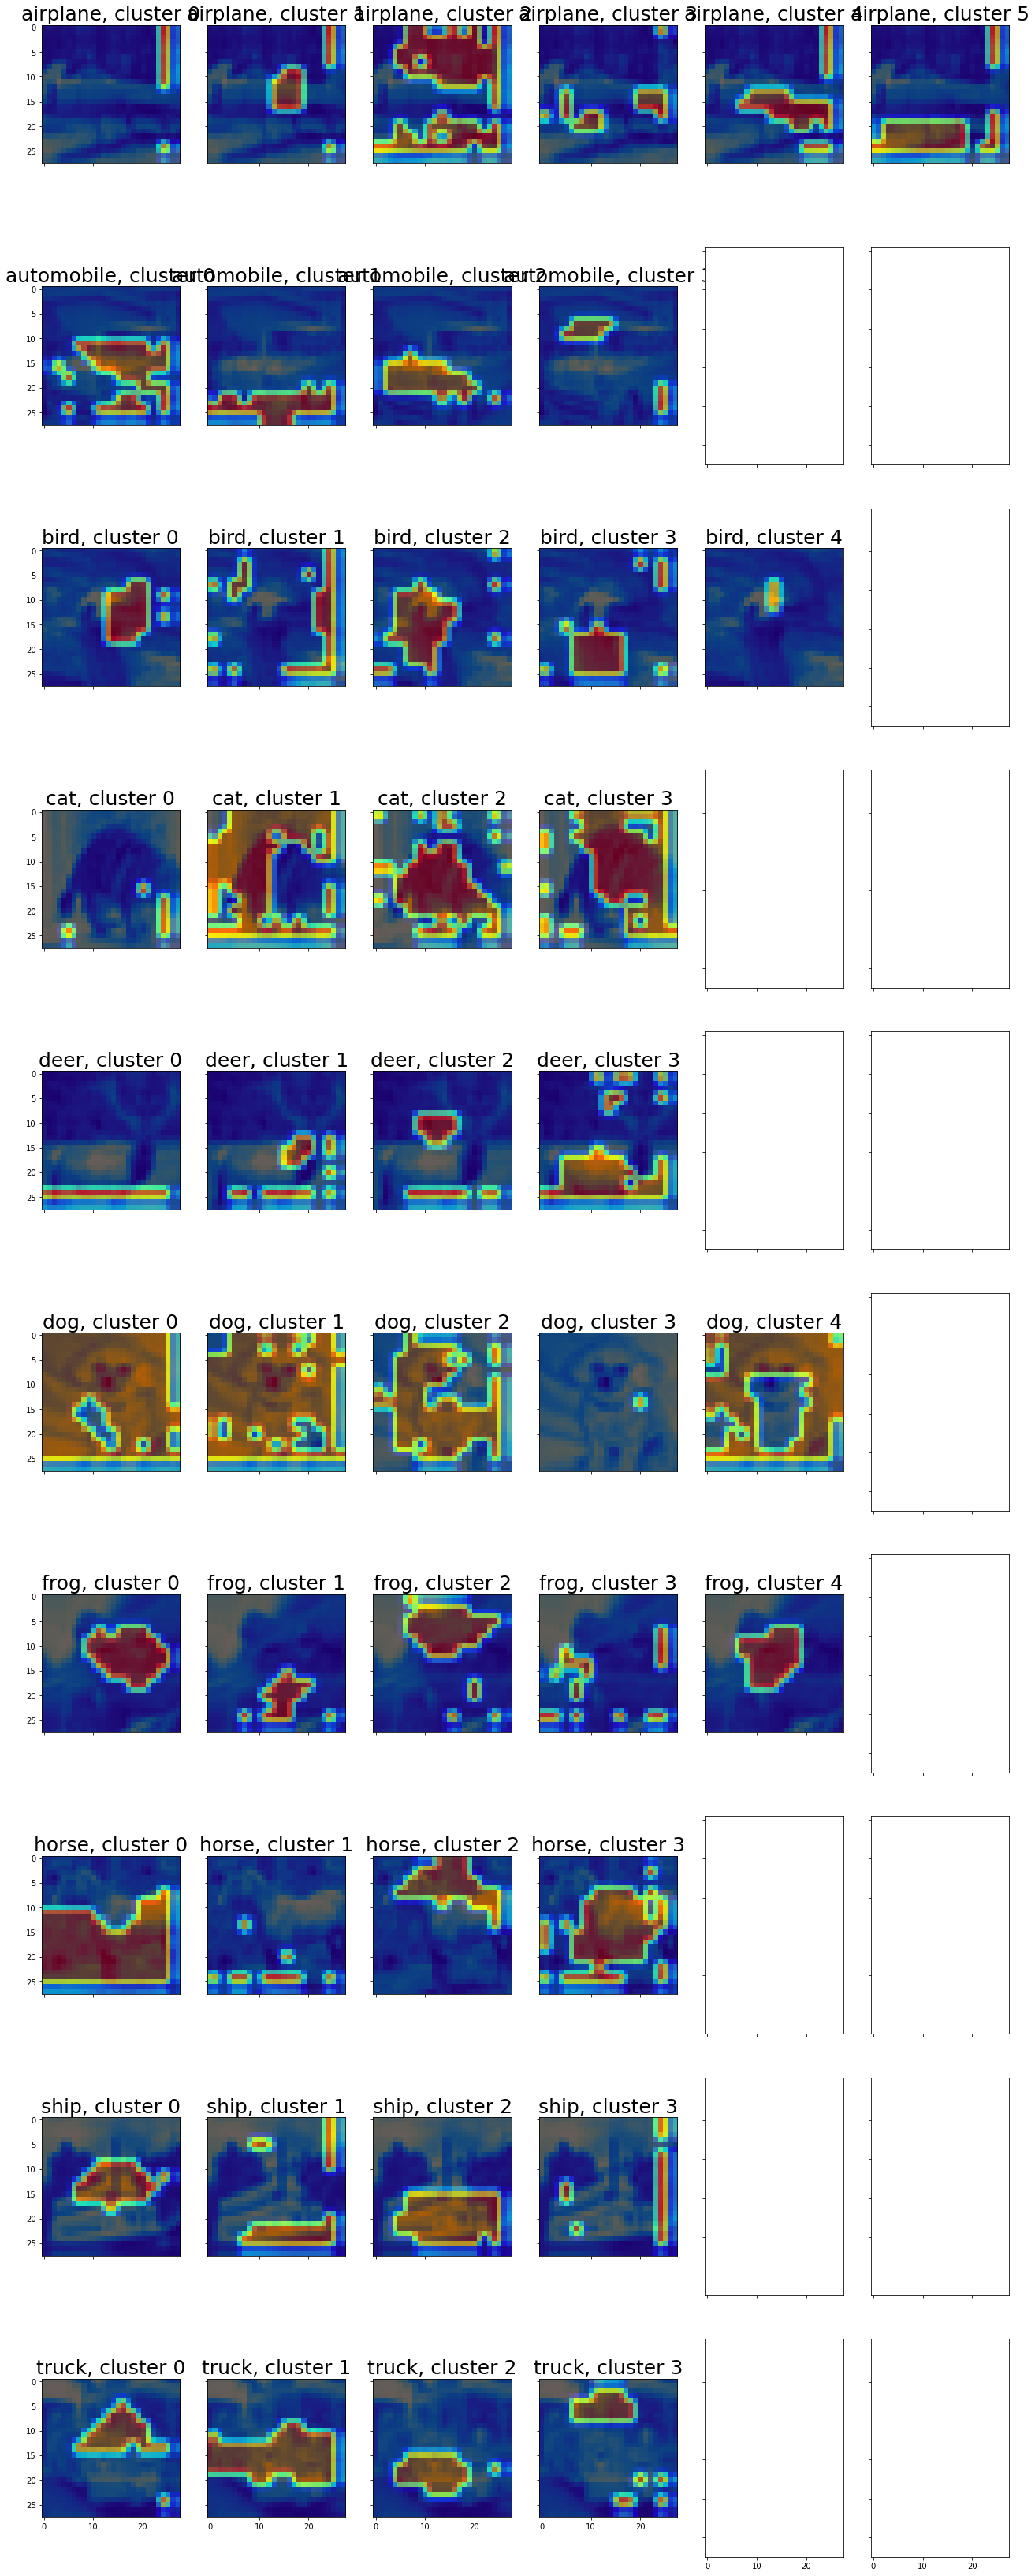

In [ ]:
# Plot de los heatmaps de cada clase

superpuesto = True

# Calculo del nº max de columnas
l_max_cols = []
for htmap_prom_cluster in lista_htmaps_prom_x_clase_cluster_threshold:
  l_max_cols.append(len(htmap_prom_cluster))
max_cols= max(l_max_cols)

# Plots
fig, ax = plt.subplots(nrows=num_clases,ncols=max_cols, figsize = (22,60),sharex=True,sharey=True)
for clase in range(num_clases):

  for cluster in range(len(lista_htmaps_prom_x_clase_cluster_threshold[clase])):
    
    if superpuesto == False:
      ax[clase,cluster].imshow(lista_htmaps_prom_x_clase_cluster_threshold[clase][cluster])
      ax[clase,cluster].set_title('{}, cluster {}'.format(class_names[clase],cluster),fontsize=25)
    elif superpuesto == True:
      indice_num = buscar_num(clase,0,train_labels_shuffled)
      ax[clase,cluster].imshow(train_images_shuffled[indice_num[0],:,:,0])
      ax[clase,cluster].imshow(resize(lista_htmaps_prom_x_clase_cluster_threshold[clase][cluster],(28,28)),alpha = 0.6,cmap='jet',vmin=0,vmax=1)
      ax[clase,cluster].set_title('{}, cluster {}'.format(class_names[clase],cluster),fontsize=25)
    
plt.savefig('./Heatmaps_x_clase_x_cluster_threshold')

# Inference

## Train, Test and OD dataset heatmap creation

Train and Test heatmaps creation

In [ ]:
# Calculamos los heatmaps de imagenes de test (53 mins aprox con ResNet32)
if len(train_images_shuffled) > 60000:
  train_images_shuffled = train_images_shuffled[:60000]

predicciones_train = np.argmax(model.predict(train_images_shuffled[-10000:]),axis=1)
array_htmaps_train = calculo_htmaps(train_images_shuffled[-10000:],predicciones_train)

In [ ]:
# Calculamos los heatmaps de imagenes de test (3 mins aprox)
if len(test_images) > 10000:
  test_images = test_images[:10000]

predicciones_test = np.argmax(model.predict(test_images),axis=1)
array_htmaps_test = calculo_htmaps(test_images,predicciones_test)

OD Dataset selection and heatmap creation

In [ ]:
# Load the selected OD dataset
if OD_dataset.value == 'SVHN_cropped':

  od_test_images, od_test_labels = load_svhn('/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Datasets/SVHN_Cropped',"test_32x32.mat")
  np.random.shuffle(od_test_images)
  od_test_images = od_test_images[:10000]

elif OD_dataset.value == 'MNIST':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')
  od_test_labels = to_categorical(od_test_labels)
  
elif OD_dataset.value == 'Fashion_MNIST':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.fashion_mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')

elif OD_dataset.value == 'MNIST_color':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')
  od_test_images = np.tile(od_test_images,3)
  od_test_images = resize(od_test_images,(10000, 32, 32, 3))

  
elif OD_dataset.value == 'Fashion_MNIST_color':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.fashion_mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')
  od_test_images = np.tile(od_test_images,3)
  od_test_images = resize(od_test_images,(10000, 32, 32, 3))

elif OD_dataset.value == 'Cifar10_grey':
  cifar = tf.keras.datasets.cifar10
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = cifar.load_data()
  # Damos el formato correspondiente a las imagenes
  od_test_images = od_test_images.reshape(10000, 32, 32, 3)
  od_test_images = od_test_images.astype('float32') / 255
  od_test_images = np.expand_dims(color.rgb2gray(od_test_images),axis=3)
  od_test_images = resize(od_test_images,(10000, 28, 28, 1))

elif OD_dataset.value == 'Cifar10':
  cifar = tf.keras.datasets.cifar10
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = cifar.load_data()
  # Damos el formato correspondiente a las imagenes
  od_test_images = od_test_images.reshape(10000, 32, 32, 3)
  od_test_images = od_test_images.astype('float32') / 255

else:
  raise NameError()

Loading SVHN dataset.


In [ ]:
# Calculamos los heatmaps de imagenes de test (3 mins aprox para 10.000 imagenes) (25 mins con ResNet32)
if len(od_test_images) > 10000:
  od_test_images = od_test_images[:10000]

predicciones_od = np.argmax(model.predict(od_test_images),axis=1)
array_htmaps_od = calculo_htmaps(od_test_images,predicciones_od)

In [ ]:
# Rotate images (17s 60.000 images)
ang = 40
for i,htmap in enumerate(test_images):
  od_test_images[i] = rotate(htmap,ang)

In [ ]:
# Translation
translation = (-3,0)
tform = trfm.SimilarityTransform(translation=translation)
for i,htmap in enumerate(test_images):
  od_test_images[i] = trfm.warp(htmap, tform)

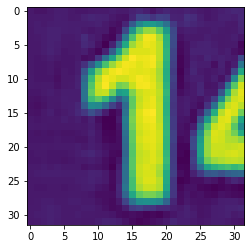

In [ ]:
plt.imshow(od_test_images[0,:,:,0])

## Comparing method selection

### General approach 1: mean/median for each class

In [ ]:
#@title Click Play to select the Image comparing method
selectMode = widgets.Combobox(
    placeholder='Choose the Image comparing method',
    options=['SSIM','CW-SSIM'],
    description='Image comparing methodS:',
    ensure_option=True,
    disabled=False,
    value='SSIM',
    layout = ipw.Layout(width='325px')
)
selectMode

Combobox(value='SSIM', description='Image comparing methodS:', ensure_option=True, layout=Layout(width='325px'…

In [ ]:
modo = selectMode.value

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_train = calculo_ssim_prom_med(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase,modo)

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_test = calculo_ssim_prom_med(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase,modo)

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_od = calculo_ssim_prom_med(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase,modo)

Comparing each sample against his own class, not the predicted one

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_train = calculo_ssim_prom_med(array_htmaps_train,np.argmax(train_labels_shuffled[-10000:],axis=1),lista_htmaps_prom_x_clase,modo)

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_test = calculo_ssim_prom_med(array_htmaps_test,np.argmax(test_labels,axis=1),lista_htmaps_prom_x_clase,modo)

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_od = calculo_ssim_prom_med(array_htmaps_od,np.argmax(od_test_labels,axis=1),lista_htmaps_prom_x_clase,modo)

SSIM of each incoming heatmap against all the heatmaps of the OD detector fo its own predicted class

In [ ]:
array_ssim_x_imagen_train = ssimVsAllHeatmaps(array_htmaps_train,predicciones_train,array_heatmaps_train_x_clase)

10000it [1:00:06,  2.77it/s]


In [ ]:
array_ssim_x_imagen_test  = ssimVsAllHeatmaps(array_htmaps_test,predicciones_test,array_heatmaps_train_x_clase)

10000it [59:39,  2.79it/s]


In [ ]:
array_ssim_x_imagen_od    = ssimVsAllHeatmaps(array_htmaps_od,predicciones_od,array_heatmaps_train_x_clase)

10000it [59:29,  2.80it/s]


### General approach 2: mean/median against each cluster of each class


SSIM against clusters mean/median

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente CLUSTER
array_ssim_x_imagen_train = calculo_ssim(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente CLUSTER
array_ssim_x_imagen_test = calculo_ssim(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente CLUSTER
array_ssim_x_imagen_od = calculo_ssim(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

MSE against clusters mean/median

In [ ]:
# MSE
array_ssim_x_imagen_train = calculo_mse(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# MSE
array_ssim_x_imagen_test = calculo_mse(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# MSE
array_ssim_x_imagen_od = calculo_mse(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

SSIM against all the heatmaps of the closest cluster

In [ ]:
# SSIM o MSE para el heatmap más cercano del cluster más cercano (17 mins aprox para 10.000 imagenes)
array_labels_de_cada_cluster = array_labels_agg_x_clase
metodo = 'ssim'
array_ssim_x_imagen_train = calculo_distancia_htmap_cercano(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster,array_heatmaps_train_x_clase,array_labels_de_cada_cluster,metodo=metodo)
array_copia_seg_train = array_ssim_x_imagen_train.copy()

In [ ]:
# SSIM o MSE para el heatmap más cercano del cluster más cercano (17 mins aprox para 10.000 imagenes)
array_labels_de_cada_cluster = array_labels_agg_x_clase
metodo = 'ssim'
array_ssim_x_imagen_test = calculo_distancia_htmap_cercano(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster,array_heatmaps_train_x_clase,array_labels_de_cada_cluster,metodo=metodo)
array_copia_seg_test = array_ssim_x_imagen_test.copy()

In [ ]:
# SSIM o MSE para el heatmap más cercano del cluster más cercano (17 mins aprox para 10.000 imagenes)
array_labels_de_cada_cluster = array_labels_agg_x_clase
metodo = 'ssim'
array_ssim_x_imagen_od = calculo_distancia_htmap_cercano(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster,array_heatmaps_train_x_clase,array_labels_de_cada_cluster,metodo=metodo)
array_copia_seg_od = array_ssim_x_imagen_od.copy()

SSIM against the clusters quantiles

In [ ]:
# SSIM o MSE para los CUANTILES definidos del cluster más cercano (25s)
metodo = 'ssim'
array_ssim_x_imagen_train = calculo_distancia_htmap_cuantiles(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster_cuantiles,metodo=metodo)

In [ ]:
# SSIM o MSE para los CUANTILES definidos del cluster más cercano (25s)
metodo = 'ssim'
array_ssim_x_imagen_test = calculo_distancia_htmap_cuantiles(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster_cuantiles,metodo=metodo)

In [ ]:
# SSIM o MSE para los CUANTILES definidos del cluster más cercano (25s)
metodo = 'ssim'
array_ssim_x_imagen_od = calculo_distancia_htmap_cuantiles(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster_cuantiles,metodo=metodo)

SSIM against reescaled cluster heatmaps

Option 1:

In [ ]:
# Train Reescaled
array_ssim_x_imagen_train = calculo_ssim_reescalado(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO
array_ssim_x_imagen_test = calculo_ssim_reescalado(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO
array_ssim_x_imagen_od = calculo_ssim_reescalado(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

Option 2:

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO (10s) pero se reescala el input
array_ssim_x_imagen_train,array_htmaps_train_reesc = calculo_ssim_reescalado_a_input(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO pero se reescala el input
array_ssim_x_imagen_test,array_htmaps_test_reesc = calculo_ssim_reescalado_a_input(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO pero se reescala el input
array_ssim_x_imagen_od,array_htmaps_od_reesc = calculo_ssim_reescalado_a_input(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

## SSIM array to DataFrame conversion (Necessary for next steps)

In [ ]:
df_ssim_x_imagen_train = pd.DataFrame(array_ssim_x_imagen_train,columns=['SSIM','Clase_pred'])
df_ssim_x_imagen_test = pd.DataFrame(array_ssim_x_imagen_test,columns=['SSIM','Clase_pred'])
df_ssim_x_imagen_od = pd.DataFrame(array_ssim_x_imagen_od,columns=['SSIM','Clase_pred'])

## Threshold and OOD cheking


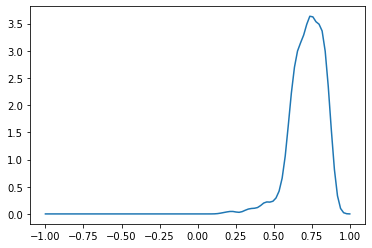

In [ ]:

kde_sci_pruebas = stats.gaussian_kde(np.array(df_ssim_x_imagen_train['SSIM'].loc[df_ssim_x_imagen_train['Clase_pred']==1]))
x = np.linspace(-1,1,100)
array_pdf_logpdf = np.zeros((x.shape))
for i,x_0 in enumerate(x):
  array_pdf_logpdf[i] = (kde_sci_pruebas.pdf(x_0))

plt.plot(x,array_pdf_logpdf)

In [ ]:
# Genera el threshold adecuado para cada clase en funcion de un TPR (True Positive Rate) que queramos conseguir.
# El TPR es el porcentaje de imagenes de la In-Distribution que se clasificarán como True (que efectivamente son de la In-D)

tpr_ini         = 0.95
modo_de_calculo = 'SSIM'
lista_kde_thr_x_clase = calculo_kde_thresholds(tpr_ini,df_ssim_x_imagen_train,modo=modo_de_calculo)

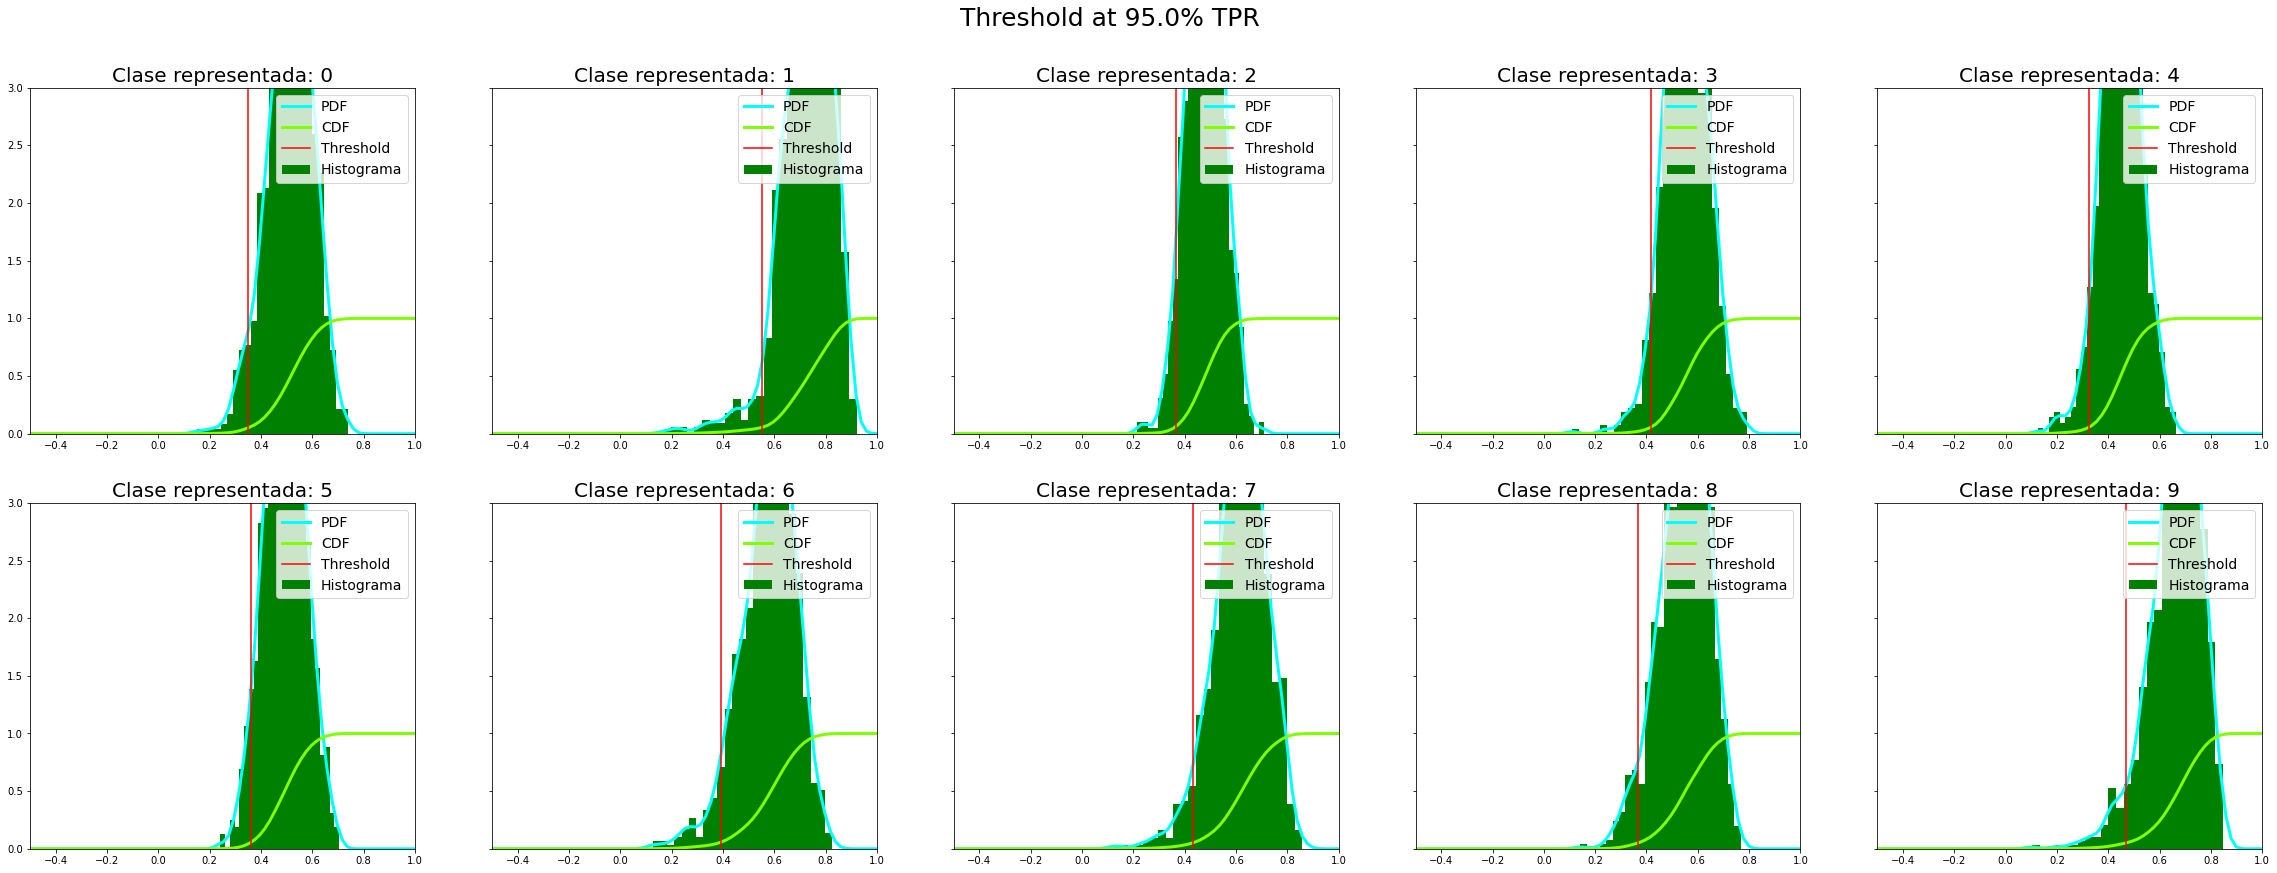

In [ ]:
# Funcion que representa el threshold 

# Elegimos
df_plot = df_ssim_x_imagen_train

x = np.linspace(-1,1,100)
y = np.linspace(1,-1,100)

fig, ax = plt.subplots(2,5,sharey=True,figsize=(40,14))
fig.suptitle('Threshold at {}% TPR'.format(tpr_ini*100), fontsize=25,y=0.96)

for num in range(10):

  # KDE fitting
  kde_sci = lista_kde_thr_x_clase[num][0]
  cdf = []
  for i in x:
    cdf.append(kde_sci.integrate_box_1d(-1,i))
  
  # Definicion de i y j para plotear bien
  i=0
  j=num
  if num >= 5:
    i = 1
    j = num-5

  # Plots de KDE
  ax[i,j].set_xlim((-0.5,1))
  ax[i,j].set_ylim((0,3))
  ax[i,j].hist(df_plot['SSIM'].loc[df_plot['Clase_pred']==num], density=True,bins=25,color='green',label='Histograma')
  
  ax[i,j].plot(x, kde_sci.pdf(x), lw=3, label='PDF', color='cyan',zorder=1)
  ax[i,j].plot(x, cdf, lw=3, label='CDF', color='chartreuse',zorder=2)
  ax[i,j].set_title('Clase representada: {}'.format(class_names[num]),fontsize=20)
  ax[i,j].axvline(x=lista_kde_thr_x_clase[num][1], ymin=0, ymax=1,color='red',label='Threshold')

  ax[i,j].legend(fontsize=14, loc='upper right')


## Metrics

### Plotting histograms

In [ ]:
print(df_ssim_x_imagen_train.median(),'\n')
print(df_ssim_x_imagen_test.median(),'\n')
print(df_ssim_x_imagen_od.median())

SSIM          0.394151
Clase_pred    3.000000
dtype: float64 

SSIM          0.385081
Clase_pred    3.000000
dtype: float64 

SSIM          0.299318
Clase_pred    4.000000
dtype: float64


In [ ]:
# Para que funcione el codigo de debajo
df_comp        = df_ssim_x_imagen_test # Plot verde
df_comp_gir    = df_ssim_x_imagen_od # Plot rojo

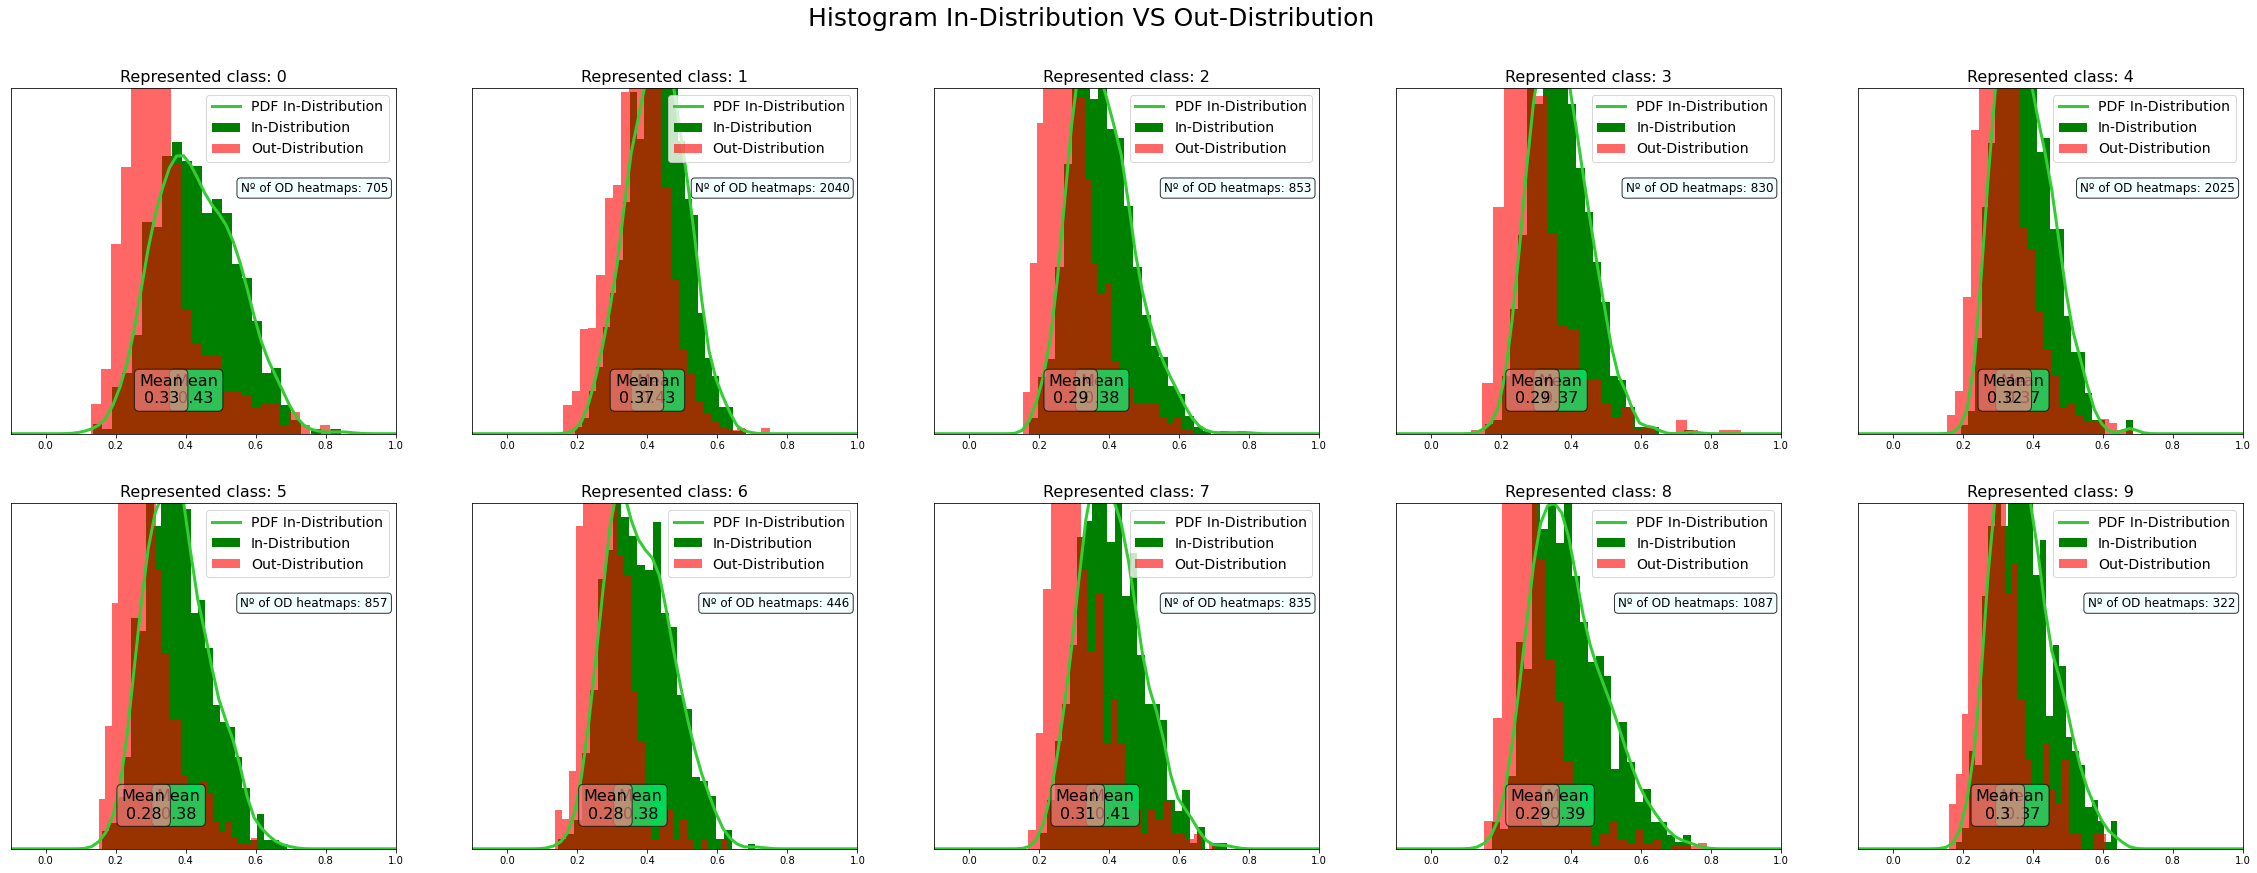

In [ ]:
# Funcion que representa el % de instancias que SI activan el threshold tanto CON como SIN deriva 

# Inicializar los rangos para los que se calcula la CDF
x = np.linspace(-1,1,100)
y = np.linspace(1,-1,100)

# Propiedades de la caja donde va el texto
props               = dict(boxstyle='round', facecolor='azure', alpha=0.8)
meanBoxProps        = dict(boxstyle='round', facecolor='springgreen', alpha=0.7)
meanOutDistBoxProps = dict(boxstyle='round', facecolor='lightcoral', alpha=0.7)
# Creacion de figura
fig, ax = plt.subplots(2,5,sharey=True,figsize=(40,14))
plot_verde  = 'In-Distribution'   
plot_rojo   = 'Out-Distribution'
fig.suptitle('Histogram In-Distribution VS {}'.format(plot_rojo), fontsize=25,y=0.96)

for num in range(10):

  # KDE fitting
  kde_sci = stats.gaussian_kde(np.array(df_comp['SSIM'].loc[df_comp['Clase_pred']==num]))
  cdf = []
  for i in x:
    cdf.append(kde_sci.integrate_box_1d(-1,i))

  # KDE fitting
  try:
    if df_comp_gir['Clase_pred'].value_counts()[num] > 50:
      kde_sci_OOD = stats.gaussian_kde(np.array(df_comp_gir['SSIM'].loc[df_comp_gir['Clase_pred']==num]))
      cdf_OOD = []
      for i in y:
        cdf_OOD.append(kde_sci_OOD.integrate_box_1d(i,1))
  except KeyError:
    pass

  # Calculo del punto de cruce minimizando diferencia entre CDFs. La solucion nos da la posicion del punto de minima 
  # diferencia dentro del array, no el valor en si
  sol = minimize_scalar(diferencia_cdf,args=(kde_sci,kde_sci_OOD),method='bounded',bounds=(1,99),options={'xatol': 0.001,'maxiter': 100, 'disp': 0})

  # Punto de cruce es el valor del eje X en la posicion de la solucion 
  p_cruce = x[int(sol.x)]
  tpr_cruce = round(kde_sci.integrate_box_1d(p_cruce,1),3)
  fpr_cruce = round(1-kde_sci_OOD.integrate_box_1d(-1,p_cruce),3)
  
  # Definicion de i y j para plotear bien
  i=0
  j=num
  if num >= 5:
    i = 1
    j = num-5

  # Plots de KDE
  ax[i,j].set_xlim((-0.1,1))
  ax[i,j].set_ylim((0,4))
  ax[i,j].set_yticks([])
  ax[i,j].hist(df_comp['SSIM'].loc[df_comp['Clase_pred']==num], density=True,bins=25,color='green',label=plot_verde)
  ax[i,j].hist(df_comp_gir['SSIM'].loc[df_comp_gir['Clase_pred']==num], density=True,bins=25,color='red',alpha=0.6,label=plot_rojo)
  ax[i,j].plot(x, kde_sci.pdf(x), lw=3, label='PDF {}'.format(plot_verde), color='limegreen',zorder=1)
  #ax[i,j].plot(x, cdf, lw=3, label='CDF {}'.format(plot_verde), color='chartreuse',zorder=2)
  ax[i,j].set_title('Represented class: {}'.format(class_names[num]),fontsize=16)

  meanInDistPerClass = round(df_ssim_x_imagen_test['SSIM'].loc[df_ssim_x_imagen_test['Clase_pred'] == float(num)].mean(),2)
  ax[i,j].text(x=meanInDistPerClass,y=0.35,s='Mean\n'+str(meanInDistPerClass),fontsize=16,fontweight='medium',bbox=meanBoxProps,horizontalalignment='center',zorder=4)

  # Texto a representar
  altura_texto = 0.71
  textstr = 'Nº of OD heatmaps: {}'.format(df_comp_gir['Clase_pred'].value_counts()[num])
  try:
    if df_comp_gir['Clase_pred'].value_counts()[num] > 50:
      #ax[i,j].plot(y, cdf_OOD, lw=3, label='CDF {}'.format(plot_rojo), color='orangered',zorder=3)
      # Texto
      meandOutDistPerClass = round(df_ssim_x_imagen_od['SSIM'].loc[df_ssim_x_imagen_od['Clase_pred'] == float(num)].mean(),2)
      ax[i,j].text(x=meandOutDistPerClass,y=0.35,s='Mean\n'+str(meandOutDistPerClass),fontsize=16,fontweight='medium',bbox=meanOutDistBoxProps,horizontalalignment='center',zorder=4)
      ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
    else:
      try:
        meandOutDistPerClass = round(df_ssim_x_imagen_od['SSIM'].loc[df_ssim_x_imagen_od['Clase_pred'] == float(num)].mean(),2)
        ax[i,j].text(x=meandOutDistPerClass,y=0.35,s='Mean\n'+str(meandOutDistPerClass),fontsize=16,fontweight='medium',bbox=meanOutDistBoxProps,horizontalalignment='center',zorder=4)

        ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
      except:
        textstr = 'Nº inputs: 0'
      ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  except KeyError:
    textstr = 'Nº inputs: 0'
    ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  #ax[i,j].axvline(x=p_cruce, ymin=0, ymax=1,color='fuchsia',label='Threshold',linewidth=3,linestyle='--',zorder=5)
  ax[i,j].legend(fontsize=14, loc='upper right')

#fig.savefig('./Hist_{}_vs_{}'.format(plot_verde,plot_rojo),dpi=200)
fig.savefig('./Hist_{}_vs_{}.pdf'.format(plot_verde,plot_rojo))

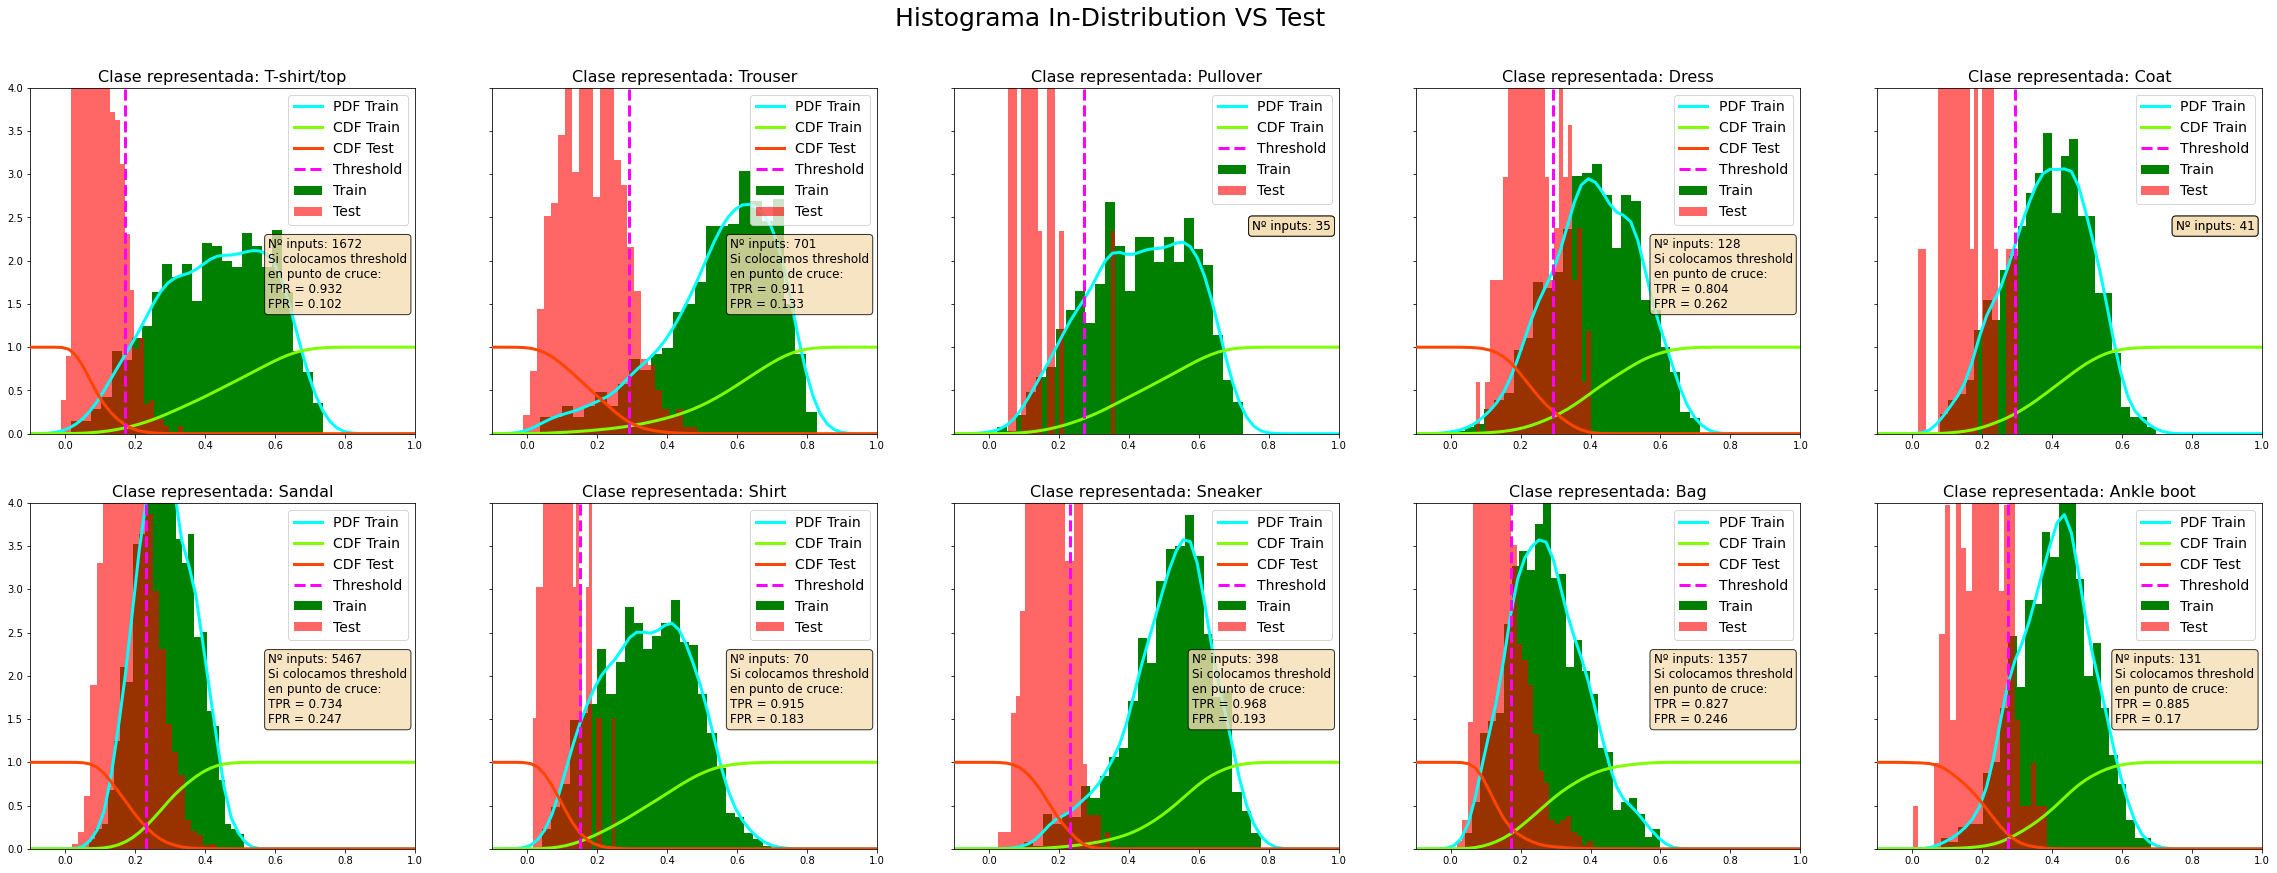

In [ ]:
# Funcion que representa el % de instancias que SI activan el threshold tanto CON como SIN deriva 

# Inicializar los rangos para los que se calcula la CDF
x = np.linspace(-1,1,100)
y = np.linspace(1,-1,100)

# Propiedades de la caja donde va el texto
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# Creacion de figura
fig, ax = plt.subplots(2,5,sharey=True,figsize=(40,14))
plot_verde  = 'Train'   
plot_rojo   = 'Test'
fig.suptitle('Histograma In-Distribution VS {}'.format(plot_rojo), fontsize=25,y=0.96)

for num in range(10):

  # KDE fitting
  kde_sci = stats.gaussian_kde(np.array(df_comp['SSIM'].loc[df_comp['Clase_pred']==num]))
  cdf = []
  for i in x:
    cdf.append(kde_sci.integrate_box_1d(-1,i))

  # KDE fitting
  try:
    if df_comp_gir['Clase_pred'].value_counts()[num] > 50:
      kde_sci_OOD = stats.gaussian_kde(np.array(df_comp_gir['SSIM'].loc[df_comp_gir['Clase_pred']==num]))
      cdf_OOD = []
      for i in y:
        cdf_OOD.append(kde_sci_OOD.integrate_box_1d(i,1))
  except KeyError:
    pass

  # Calculo del punto de cruce minimizando diferencia entre CDFs. La solucion nos da la posicion del punto de minima 
  # diferencia dentro del array, no el valor en si
  sol = minimize_scalar(diferencia_cdf,args=(kde_sci,kde_sci_OOD),method='bounded',bounds=(1,99),options={'xatol': 0.001,'maxiter': 100, 'disp': 0})

  # Punto de cruce es el valor del eje X en la posicion de la solucion 
  p_cruce = x[int(sol.x)]
  tpr_cruce = round(kde_sci.integrate_box_1d(p_cruce,1),3)
  fpr_cruce = round(1-kde_sci_OOD.integrate_box_1d(-1,p_cruce),3)
  
  # Definicion de i y j para plotear bien
  i=0
  j=num
  if num >= 5:
    i = 1
    j = num-5

  # Plots de KDE
  ax[i,j].set_xlim((-0.1,1))
  ax[i,j].set_ylim((0,4))
  ax[i,j].hist(df_comp['SSIM'].loc[df_comp['Clase_pred']==num], density=True,bins=25,color='green',label=plot_verde)
  ax[i,j].hist(df_comp_gir['SSIM'].loc[df_comp_gir['Clase_pred']==num], density=True,bins=25,color='red',alpha=0.6,label=plot_rojo)
  ax[i,j].plot(x, kde_sci.pdf(x), lw=3, label='PDF {}'.format(plot_verde), color='cyan',zorder=1)
  ax[i,j].plot(x, cdf, lw=3, label='CDF {}'.format(plot_verde), color='chartreuse',zorder=2)
  ax[i,j].set_title('Clase representada: {}'.format(class_names[num]),fontsize=16)

  try:
    if df_comp_gir['Clase_pred'].value_counts()[num] > 50:
      ax[i,j].plot(y, cdf_OOD, lw=3, label='CDF {}'.format(plot_rojo), color='orangered',zorder=3)
      # Texto
      textstr = 'Nº inputs: {}\nSi colocamos threshold\nen punto de cruce:\nTPR = {}\nFPR = {}'.format(df_comp_gir['Clase_pred'].value_counts()[num],tpr_cruce,fpr_cruce)
      ax[i,j].text(0.98, 0.46, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
    else:
      try:
        textstr = 'Nº inputs: {}'.format(df_comp_gir['Clase_pred'].value_counts()[num])
        ax[i,j].text(0.98, 0.60, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
      except:
        textstr = 'Nº inputs: 0'
      ax[i,j].text(0.98, 0.60, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  except KeyError:
    textstr = 'Nº inputs: 0'
    ax[i,j].text(0.98, 0.60, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  ax[i,j].axvline(x=p_cruce, ymin=0, ymax=1,color='fuchsia',label='Threshold',linewidth=3,linestyle='--',zorder=5)
  ax[i,j].legend(fontsize=14, loc='upper right')

#fig.savefig('./Hist_{}_vs_{}'.format(plot_verde,plot_rojo),dpi=200)
fig.savefig('./Hist_{}_vs_{}.pdf'.format(plot_verde,plot_rojo))
#ax[i,j].text(0.69,2.38,'Nº inputs: {}'.format(df_comp_gir['Clase_pred'].value_counts()[num]),fontsize=12)
#ax[i,j].text(0.61,1.9,'''Si colocamos threshold en punto de cruce: TPR = {} TNR = {} '''.format(tpr_cruce,tnr_cruce),fontsize=10)

### Threshold independent metrics data calculation (Test_images VS Out-Distribution)

In [ ]:
# Calculo de los thresholds que se van a emplear para las metricas independientes del threshold (50s)

# Eleccion del DataFrame que se va a usar para generar los KDEs (DEBE SER TRAIN)
df_kde = df_ssim_x_imagen_train

# SSIM o MSE
modo_de_calculo = 'SSIM'

# Inicializar array con todos los tprs y la lista con los thresholds 
array_full_tpr                = np.linspace(0,1,101)
array_full_thresholds         = np.zeros((len(array_full_tpr),num_clases))
array_thresholds_cols_to_rows = np.zeros(())

for ind,true_positive_rate in enumerate(array_full_tpr):

  lista_kde_threshold_variando = calculo_kde_thresholds(true_positive_rate,df_kde,modo_de_calculo)
  
  array_thresholds_cols_to_rows = np.zeros((num_clases))
  for i,kde_thr in enumerate(lista_kde_threshold_variando):
    array_thresholds_cols_to_rows[i] = kde_thr[1]
  
  array_full_thresholds[ind] = array_thresholds_cols_to_rows

In [ ]:
# Generacion de array sobre la In-Distribution con valores True o False sobre si son (True) o no (False) parte de la distribucion 
# Inicializaciones
array_InD              = array_ssim_x_imagen_test
preds_InD              = predicciones_test
array_InD_x_threshold  = np.empty((len(array_InD),len(array_full_tpr)),dtype=bool)

# Progress bar
bar = progressbar.ProgressBar(maxval=len(array_full_thresholds),widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()
n = 0

# Inicializamos el tiempo
t3 = timeit.default_timer() 
for i_thr,threshold in enumerate(array_full_thresholds):

  for i_imagen,ssim_calculado in enumerate(array_InD):
    array_InD_x_threshold[i_imagen,i_thr] = comprobacion_OOD(ssim_calculado[0],array_full_thresholds[preds_InD[i_imagen]],threshold[preds_InD[i_imagen]])

  bar.update(n)
  n = n+1

df_InD = pd.DataFrame(array_InD_x_threshold)

t4 = timeit.default_timer() 
print('\nThresholds time: {}'.format(t4 - t3))
print('Fin')

[=================================================================  ] 99 of 101


Thresholds time: 1.8569199330013362
Fin


In [ ]:
# Generacion de array sobre la Out-Distribution con valores True o False sobre si son (True) o no (False) parte de la distribucion ( s aprox)

# Inicializaciones
array_OutD              = array_ssim_x_imagen_od
preds_OutD              = predicciones_od
array_OutD_x_threshold  = np.zeros((len(array_OutD),len(array_full_tpr)),dtype=bool)

# Progress bar
bar = progressbar.ProgressBar(maxval=len(array_full_thresholds),widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()
n = 0

# Inicializamos el tiempo
t3 = timeit.default_timer() 
for i_thr,threshold in enumerate(array_full_thresholds):

  for i_imagen,ssim_calculado in enumerate(array_OutD):
    array_OutD_x_threshold[i_imagen,i_thr] = comprobacion_OOD(ssim_calculado[0],array_full_thresholds[preds_OutD[i_imagen]],threshold[preds_OutD[i_imagen]])

  bar.update(n)
  n = n+1

df_OutD = pd.DataFrame(array_OutD_x_threshold)

t4 = timeit.default_timer() 
print('\nThresholds time: {}'.format(t4 - t3))
print('Fin')

[=================================================================  ] 98 of 101


Thresholds time: 1.8792387249995954
Fin


### AUROC

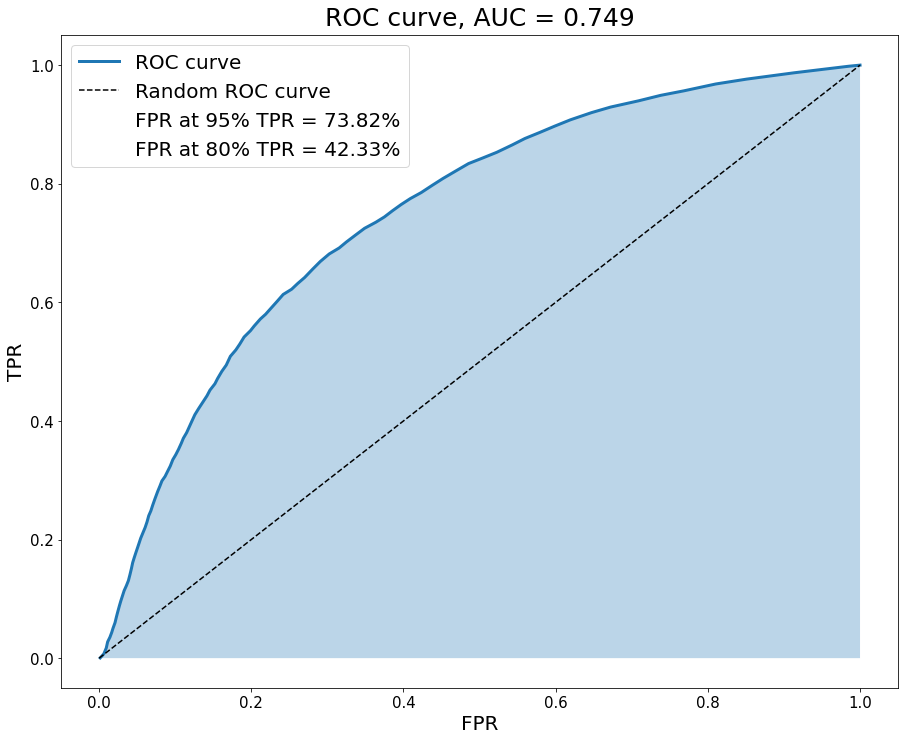

In [ ]:
# Creacion de un array con el TPR y el FPR

# Inicializar array
array_TPR_FPR_x_threshold = np.empty((len(df_InD.columns),2))

for i,thr in enumerate(df_InD.columns):

  # Por cada threshold sacamos los que son True y False de cada distribucion
  values_InD  = df_InD[thr].value_counts()
  values_OutD = df_OutD[thr].value_counts()
  
  try:
    tp  = values_InD[True]
  except:
    tp = 0  
  try:
    fn  = values_InD[False]
  except:
    fn = 0
  tpr = tp/(tp+fn)

  try:
    fp = values_OutD[True]
  except:
    fp = 0
  try:
    tn = values_OutD[False]
  except:
    tn = 0
  fpr = fp/(fp+tn)

  #print((tp+fn),(fp+tn))
  array_TPR_FPR_x_threshold[i] = np.array([tpr,fpr])

array_TPR_FPR_x_threshold = np.append(array_TPR_FPR_x_threshold,np.reshape(np.array([1,1]),(1,2)),axis=0) # He añadido para cerrar la curva

# Calculo del AUC
auc = np.trapz(array_TPR_FPR_x_threshold[:,0], array_TPR_FPR_x_threshold[:,1])

# Plot
plt.figure(figsize=(15,12))
roc = plt.plot(array_TPR_FPR_x_threshold[:,1],array_TPR_FPR_x_threshold[:,0],label='ROC curve',lw=3)
rnd_roc = plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k--',label='Random ROC curve')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.title('ROC curve, AUC = %.3f'%auc,fontsize=25,pad=10)
plt.fill_between(array_TPR_FPR_x_threshold[:,1],array_TPR_FPR_x_threshold[:,0],alpha=0.3)
# Create empty plot with blank marker containing the extra label
plt.plot([], [], ' ', label='FPR at 95% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[95,1]*100,2)))
plt.plot([], [], ' ', label='FPR at 80% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[80,1]*100,2)))
#plt.text(0.60,0.975,'FPR at 95% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[95,1]*100,2)),fontsize=20,bbox=dict(boxstyle="round",facecolor='white', alpha=0.5))
plt.legend(fontsize=20,loc='upper left')
#plt.axhline(y=0.95,linestyle='-',zorder=0)
#plt.axvline(x=array_TPR_FPR_x_threshold[95,1],linestyle='dashed',zorder=0)
#plt.savefig('/content/AUROC')
plt.savefig('/content/AUROC.pdf')

### AUPR


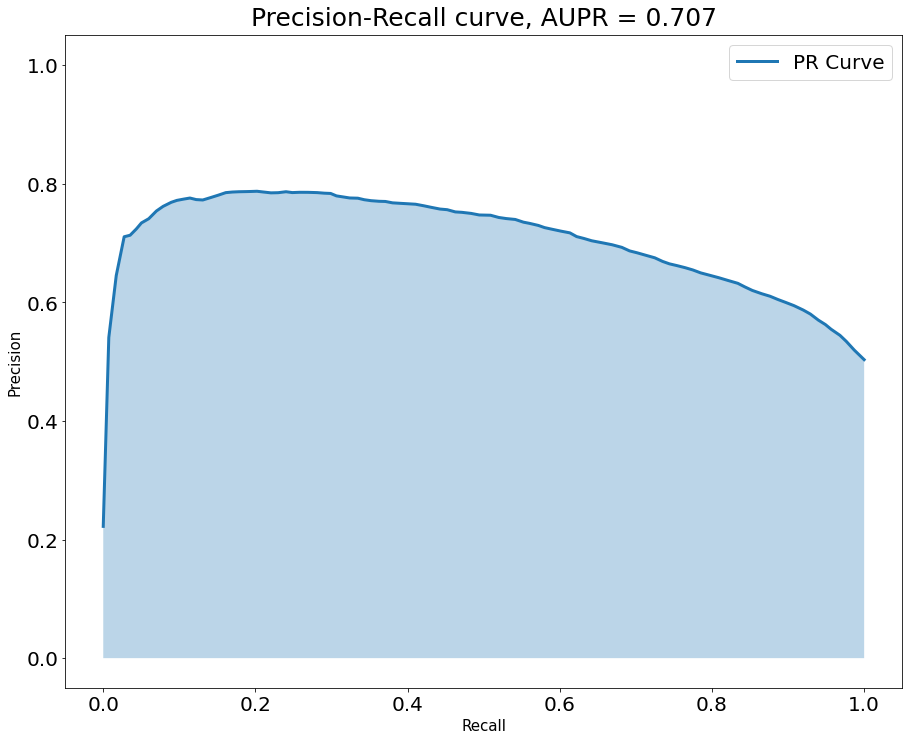

In [ ]:
# Calculo de la Precision (tp/(tp+fp)) y el Recall (tp/(tp+fn))

# Inicializar array
array_Prec_Recall_x_threshold = np.empty((len(df_InD.columns),2))

for i,thr in enumerate(df_InD.columns):

  # Por cada threshold sacamos los que son True y False de cada distribucion
  values_InD  = df_InD[thr].value_counts()
  values_OutD = df_OutD[thr].value_counts()

  try:
    tp  = values_InD[True]
  except:
    tp = 0
  try:
    fp = values_OutD[True]
  except:
    fp = 0
  try:
    prec = tp/(tp+fp)
  except:
    prec = 1

  try:
    fn = values_InD[False]
  except:
    fn = 0
  recal_tpr = tp/(tp+fn)

  array_Prec_Recall_x_threshold[i] = np.array([prec,recal_tpr])

# Para cerrar la curva, lo que hago es desplazar el ultimo valor hasta su correspondiente extremo (0 o 1)
array_Prec_Recall_x_threshold[0,1] = 0
array_Prec_Recall_x_threshold[len(array_Prec_Recall_x_threshold)-1,1] = 1



# Calculo del AUPR
aupr = np.trapz(array_Prec_Recall_x_threshold[:,0], array_Prec_Recall_x_threshold[:,1])

# Plot
plt.figure(figsize=(15,12))
plt.plot(array_Prec_Recall_x_threshold[:,1],array_Prec_Recall_x_threshold[:,0],label='PR Curve',lw=3)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
#plt.plot(np.linspace(0,1,100),np.linspace(1,0.5,100),'k--',label='Curva ROC aleatoria')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.title('Precision-Recall curve, AUPR = %.3f'%aupr,fontsize=25,pad=10)
plt.fill_between(array_Prec_Recall_x_threshold[:,1],array_Prec_Recall_x_threshold[:,0],alpha=0.3)
plt.legend(fontsize=20,loc='upper right')
#plt.savefig('/content/AUPR')
plt.savefig('/content/AUPR.pdf')

In [ ]:
num = 0
array_full_thresholds[num]

array([0.73963283, 0.92188484, 0.71053833, 0.79207005, 0.66333486,
       0.70395671, 0.82562138, 0.85849946, 0.76717881, 0.84721147])

In [ ]:
array_Prec_Recall_x_threshold.shape

(101, 2)

In [ ]:
df_InD[num].value_counts()

False    9984
True       16
Name: 0, dtype: int64

In [ ]:
df_OutD[num].value_counts()

False    9992
True        8
Name: 0, dtype: int64

In [ ]:
array_Prec_Recall_x_threshold[num]

array([0.66666667, 0.        ])

## Ploting Test and OD images with heatmaps VS Clusters

In [ ]:
!cd "/content/"
!mkdir pelicula
!mkdir pelicula_completa

In [ ]:
# Genera Heatmaps de GradCAM+  ()

contador             = 0
contador_comparacion = 0

# Definimos lo que queremos comparar
pos_inicio                          = 1500
pos_fin                             = 1600
predicciones                        = predicciones_test[pos_inicio:pos_fin]
array_htmaps_a_plotear              = array_htmaps_test[pos_inicio:pos_fin]
array_similaridad                   = array_ssim_x_imagen_test[pos_inicio:pos_fin]
imagenes                            = test_images[pos_inicio:pos_fin]

predicciones_comparacion            = predicciones_od[pos_inicio:pos_fin]
array_htmaps_a_plotear_comparacion  = array_htmaps_od[pos_inicio:pos_fin]
array_similaridad_comparacion       = array_ssim_x_imagen_od[pos_inicio:pos_fin]
imagenes_comparacion                = od_test_images[pos_inicio:pos_fin]

# Es una imagen estatica luego la leemos solo una vez
image_2 = io.imread('/content/Heatmaps_x_clase_y_cluster_{}.png'.format(modo_heatmaps))/255.0

# Barra de progreso
bar            = progressbar.ProgressBar(maxval=array_htmaps_a_plotear.shape[0],widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()

while contador < len(predicciones):

  # En cada foto se genera una nueva figura
  fig, ax = plt.subplots(nrows=10, ncols=5, clear=True, figsize=[25,40])
  fig.suptitle('In-Distribution vs Out-Distribution',fontsize=32, y=0.92)
  # i vale 0 y 5
  for i in range(10): 
    
    for j in range(5):

      if i < 5:
        numero_clase = predicciones[contador]
        nombre_clase = class_names[numero_clase]
        gradcam_htmap = array_htmaps_a_plotear[contador]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad[contador,0],3))
        plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes[contador,:,:,0])
        ax[i,j].axis('off')

        contador = contador + 1 

      else:
        numero_clase = predicciones_comparacion[contador_comparacion]
        nombre_clase = class_names[numero_clase]
        gradcam_htmap = array_htmaps_a_plotear_comparacion[contador_comparacion]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad_comparacion[contador_comparacion,0],3))
        plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes_comparacion[contador_comparacion,:,:,0])
        ax[i,j].axis('off')

        contador_comparacion = contador_comparacion + 1 

  # Para crear la escala de colores
  fig.subplots_adjust(right=0.90)
  cbar_ax = fig.add_axes([0.93, 0.35, 0.03, 0.4])
  fig.colorbar(ax[0,0].get_images()[1], cax=cbar_ax,)


  fig_name = './pelicula/fraim_'+ str(contador) + '.png'
  plt.savefig(fig_name,dpi=250)
  fig.clear()
  plt.close(fig) # Para no mostrar las figuras

  image_1 = io.imread(fig_name)/255.0
  

  '''
  fig, axs = plt.subplots(1,2,sharex=True,sharey=True,fÇigsize=(60,60),tight_layout=True,gridspec_kw={'width_ratios': [2, 1]})
  #fig.suptitle('Analisis estadístico del SSIM y MSE de cuando no hay deriva VS cuando hay', fontsize=35)
  axs[0].imshow(image_1,vmin=0,vmax=1)
  axs[1].imshow(image_2,vmin=0,vmax=1)
  
  '''
  fig_w = (image_1.shape[0] + image_2.shape[0])/100
  fig_h = (image_1.shape[1] + image_2.shape[1])/100
  w_space = -(image_2.shape[0]/fig_w)/100 - 0.12

  fig = plt.figure(figsize=(fig_w, fig_h)) 

  ax0 = plt.subplot(121)
  ax0.imshow(image_1,vmin=0,vmax=1)
  ax0.axis('off')

  ax1 = plt.subplot(122)
  ax1.imshow(image_2,vmin=0,vmax=1)
  ax1.axis('off')
  plt.subplots_adjust(wspace=w_space)

  plt.savefig('/content/pelicula_completa/fraim_'+ str(contador) + '.pdf')
  fig.clear()
  plt.close(fig)
  bar.update(contador)
  

[==================================================================] 100 of 100

Generar fotos de Grad-CAM++ de instancias de la In-Distribution solo, para ver el heatmap y la imagen

In [ ]:
# Genera Heatmaps de GradCAM+  ()

contador             = 0
contador_comparacion = 0

# Definimos lo que queremos comparar
pos_inicio                          = 1500
pos_fin                             = 1600
predicciones                        = predicciones_test[pos_inicio:pos_fin]
array_htmaps_a_plotear              = array_htmaps_test[pos_inicio:pos_fin]
array_similaridad                   = array_ssim_x_imagen_test[pos_inicio:pos_fin]
imagenes                            = test_images[pos_inicio:pos_fin]

predicciones_comparacion            = np.argmax(test_labels,axis=1)[pos_inicio:pos_fin]
#array_htmaps_a_plotear_comparacion  = array_htmaps_od[pos_inicio:pos_fin]
array_similaridad_comparacion       = array_ssim_x_imagen_test[pos_inicio:pos_fin]
imagenes_comparacion                = test_images[pos_inicio:pos_fin]

# Es una imagen estatica luego la leemos solo una vez
image_2 = io.imread('/content/Heatmaps_x_clase_y_cluster_{}.png'.format(modo_heatmaps))/255.0

# Barra de progreso
bar            = progressbar.ProgressBar(maxval=array_htmaps_a_plotear.shape[0],widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()

while contador < len(predicciones):

  # En cada foto se genera una nueva figura
  fig, ax = plt.subplots(nrows=10, ncols=5, clear=True, figsize=[25,40])
  fig.suptitle('In-Distribution vs Out-Distribution',fontsize=32, y=0.92)
  # i vale 0 y 5
  for i in range(10): 
    
    for j in range(5):

      if i % 2 == 0:
        numero_clase = predicciones[contador]
        nombre_clase = class_names[numero_clase]
        gradcam_htmap = array_htmaps_a_plotear[contador]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad[contador,0],3))
        plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes[contador,:,:,0])
        ax[i,j].axis('off')

        contador = contador + 1 

      else:
        numero_clase = predicciones_comparacion[contador_comparacion]
        nombre_clase = class_names[numero_clase]
        #gradcam_htmap = array_htmaps_a_plotear_comparacion[contador_comparacion]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad_comparacion[contador_comparacion,0],3))
        ax[i,j].imshow(imagenes_comparacion[contador_comparacion,:,:,0])
        #plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes_comparacion[contador_comparacion,:,:,0])
        ax[i,j].axis('off')

        contador_comparacion = contador_comparacion + 1 

  # Para crear la escala de colores
  fig.subplots_adjust(right=0.90)
  cbar_ax = fig.add_axes([0.93, 0.35, 0.03, 0.4])
  fig.colorbar(ax[0,0].get_images()[1], cax=cbar_ax,)


  fig_name = './pelicula/fraim_'+ str(contador) + '.png'
  plt.savefig(fig_name,dpi=250)
  fig.clear()
  plt.close(fig) # Para no mostrar las figuras

  image_1 = io.imread(fig_name)/255.0
  

  '''
  fig, axs = plt.subplots(1,2,sharex=True,sharey=True,fÇigsize=(60,60),tight_layout=True,gridspec_kw={'width_ratios': [2, 1]})
  #fig.suptitle('Analisis estadístico del SSIM y MSE de cuando no hay deriva VS cuando hay', fontsize=35)
  axs[0].imshow(image_1,vmin=0,vmax=1)
  axs[1].imshow(image_2,vmin=0,vmax=1)
  
  '''
  fig_w = (image_1.shape[0] + image_2.shape[0])/100
  fig_h = (image_1.shape[1] + image_2.shape[1])/100
  w_space = -(image_2.shape[0]/fig_w)/100 - 0.12

  fig = plt.figure(figsize=(fig_w, fig_h)) 

  ax0 = plt.subplot(121)
  ax0.imshow(image_1,vmin=0,vmax=1)
  ax0.axis('off')

  ax1 = plt.subplot(122)
  ax1.imshow(image_2,vmin=0,vmax=1)
  ax1.axis('off')
  plt.subplots_adjust(wspace=w_space)

  plt.savefig('/content/pelicula_completa/fraim_'+ str(contador) + '.pdf')
  fig.clear()
  plt.close(fig)
  bar.update(contador)

[==================================================================] 100 of 100

In [ ]:
  fig_w = (image_1.shape[0] + image_2.shape[0])/100
  fig_h = (image_1.shape[1] + image_2.shape[1])/100

  fig = plt.figure(figsize=(80, 60)) 

  ax0 = plt.subplot(121)
  ax0.imshow(image_1,vmin=0,vmax=1)
  ax0.axis('off')

  ax1 = plt.subplot(122)
  ax1.imshow(image_2,vmin=0,vmax=1)
  ax1.axis('off')
  plt.subplots_adjust(wspace=-0.47)

  plt.savefig('/content/pelicula_completa/fraim_'+ str(contador) + '.png')
  fig.clear()
  plt.close(fig)
  bar.update(contador)
  

In [ ]:
# Genera Heatmaps de GradCAM+  ()

contador             = 0
contador_comparacion = 0

# Definimos lo que queremos comparar
pos_inicio                          = 1000
pos_fin                             = 1100
predicciones                        = predicciones_test[pos_inicio:pos_fin]
array_htmaps_a_plotear              = array_htmaps_test[pos_inicio:pos_fin]
array_similaridad                   = array_ssim_x_imagen_test[pos_inicio:pos_fin]
imagenes                            = test_images[pos_inicio:pos_fin]

predicciones_comparacion            = predicciones_od[pos_inicio:pos_fin]
array_htmaps_a_plotear_comparacion  = array_htmaps_od[pos_inicio:pos_fin]
array_similaridad_comparacion       = array_ssim_x_imagen_od[pos_inicio:pos_fin]
imagenes_comparacion                = od_test_images[pos_inicio:pos_fin]

# Es una imagen estatica luego la leemos solo una vez
image_2 = io.imread('/content/Heatmaps_mediana_x_clase.png'.format(modo_heatmaps))/255.0

# Barra de progreso
bar            = progressbar.ProgressBar(maxval=array_htmaps_a_plotear.shape[0],widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()

while contador < len(predicciones):

  # En cada foto se genera una nueva figura
  fig, ax = plt.subplots(nrows=10, ncols=5, clear=True, figsize=[25,40])
  fig.suptitle('In-Distribution vs Out-Distribution',fontsize=32, y=0.92)
  # i vale 0 y 5
  for i in range(10): 
    
    for j in range(5):

      if i < 5:
        numero_clase = predicciones[contador]
        nombre_clase = class_names[numero_clase]
        gradcam_htmap = array_htmaps_a_plotear[contador]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad[contador,0],3))
        plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes[contador,:,:,0])
        ax[i,j].axis('off')

        contador = contador + 1 

      else:
        numero_clase = predicciones_comparacion[contador_comparacion]
        nombre_clase = class_names[numero_clase]
        gradcam_htmap = array_htmaps_a_plotear_comparacion[contador_comparacion]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad_comparacion[contador_comparacion,0],3))
        plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes_comparacion[contador_comparacion,:,:,0])
        ax[i,j].axis('off')

        contador_comparacion = contador_comparacion + 1 

  # Para crear la escala de colores
  fig.subplots_adjust(right=0.90)
  cbar_ax = fig.add_axes([0.93, 0.35, 0.03, 0.4])
  fig.colorbar(ax[0,0].get_images()[1], cax=cbar_ax,)


  fig_name = './pelicula/fraim_'+ str(contador) + '.png'
  plt.savefig(fig_name)
  fig.clear()
  plt.close(fig) # Para no mostrar las figuras

  image_1 = io.imread(fig_name)/255.0
  

  '''
  fig, axs = plt.subplots(1,2,sharex=True,sharey=True,fÇigsize=(60,60),tight_layout=True,gridspec_kw={'width_ratios': [2, 1]})
  #fig.suptitle('Analisis estadístico del SSIM y MSE de cuando no hay deriva VS cuando hay', fontsize=35)
  axs[0].imshow(image_1,vmin=0,vmax=1)
  axs[1].imshow(image_2,vmin=0,vmax=1)
  
  '''
  fig_w = (image_1.shape[0] + image_2.shape[0])/100
  fig_h = (image_1.shape[1] + image_2.shape[1])/100
  w_space = -(image_2.shape[0]/fig_w)/100 - 0.12

  fig = plt.figure(figsize=(fig_w, fig_h)) 

  ax0 = plt.subplot(121)
  ax0.imshow(image_1,vmin=0,vmax=1)
  ax0.axis('off')

  ax1 = plt.subplot(122)
  ax1.imshow(image_2,vmin=0,vmax=1)
  ax1.axis('off')
  plt.subplots_adjust(wspace=w_space)

  plt.savefig('/content/pelicula_completa/fraim_'+ str(contador) + '.png')
  fig.clear()
  plt.close(fig)
  bar.update(contador)

[==================================================================] 100 of 100

# Pruebas con SSIM


## Imports

In [ ]:
# Necesario para usar el script que he copiado del git llvll/imgcluster
!pip uninstall opencv-python -y
!pip install -U opencv-contrib-python==3.4.2.17
!pip install pyssim

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6 MB 43 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
  Created wheel for pyssim: filename=pyssim-0.4-py2.py3-none-any.whl size=5813 sha256=107da70b0d8a42172741303ad73ce3f127a068b3c2a5de029bcba592a3aaf714
  Stored in directory: /root/.cache/pip/wheels/d0/ea/0c/ba94e2becf14fe426dbc21148ff8b792e25318e8e911c8e52c
Successfully built pyssim


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import pickle
import PIL

## Script para image similarity

In [ ]:
import os
import datetime
import cv2
import numpy as np
import ssim.ssimlib as pyssim
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import SpectralClustering, AffinityPropagation
from sklearn import metrics

# Constant definitions
RESZ_IMAGE_SIZE = (32, 32)
SIFT_RATIO = 0.7

""" Returns the normalized similarity value (from 0.0 to 1.0) for the provided pair of images.
    The following algorithms are supported:
    * SIFT: Scale-invariant Feature Transform
    * SSIM: Structural Similarity Index
    * CW-SSIM: Complex Wavelet Structural Similarity Index
    * MSE: Mean Squared Error
"""
def get_image_similarity_heatmaps(img1, img2, algorithm='SIFT'):
    # Converting to grayscale and resizing
    i1 = cv2.resize(img1, RESZ_IMAGE_SIZE)
    i2 = cv2.resize(img2, RESZ_IMAGE_SIZE)

    similarity = 0.0

    if algorithm == 'SIFT':
        i1 = (i1*255).astype('uint8')
        i2 = (i2*255).astype('uint8')
        # Using OpenCV for feature detection and matching
        sift = cv2.xfeatures2d.SIFT_create()
        k1, d1 = sift.detectAndCompute(i1, None)
        k2, d2 = sift.detectAndCompute(i2, None)

        bf = cv2.BFMatcher()
        matches = bf.knnMatch(d1, d2, k=2)

        for m, n in matches:
            if m.distance < SIFT_RATIO * n.distance:
                similarity += 1.0

        # Custom normalization for better variance in the similarity matrix
        if similarity == len(matches):
            similarity = 1.0
        elif similarity > 1.0:
            similarity = 1.0 - 1.0/similarity
        elif similarity == 1.0:
            similarity = 0.1
        else:
            similarity = 0.0
    elif algorithm == 'CW-SSIM':
        # FOR EXPERIMENTS ONLY!
        # Very slow algorithm - up to 50x times slower than SIFT or SSIM.
        # Optimization using CUDA or Cython code should be explored in the future.
        i1 = PIL.Image.frombytes(mode='1',size=i1.shape,data=i1)
        i2 = PIL.Image.frombytes(mode='1',size=i2.shape,data=i2)
        similarity = pyssim.SSIM(i1).cw_ssim_value(i2)
    elif algorithm == 'SSIM':
        # Default SSIM implementation of Scikit-Image
        similarity = ssim(i1, i2)
    else:
        # Using MSE algorithm with custom normalization
        err = np.sum((i1.astype("float") - i2.astype("float")) ** 2)
        err /= float(i1.shape[0] * i2.shape[1])

        if err > 0.0:
            similarity = MSE_NUMERATOR / err
        else:
            similarity = 1.0

    return similarity



# Constant definitions
SIM_IMAGE_SIZE = (8, 8)
SIFT_RATIO = 0.7
MSE_NUMERATOR = 1000.0
IMAGES_PER_CLUSTER = 5

""" Returns the normalized similarity value (from 0.0 to 1.0) for the provided pair of images.
    The following algorithms are supported:
    * SIFT: Scale-invariant Feature Transform
    * SSIM: Structural Similarity Index
    * CW-SSIM: Complex Wavelet Structural Similarity Index
    * MSE: Mean Squared Error
"""
def get_image_similarity(img1, img2, algorithm='SIFT'):
    # Converting to grayscale and resizing
    i1 = cv2.resize(cv2.imread(img1, cv2.IMREAD_GRAYSCALE), SIM_IMAGE_SIZE)
    i2 = cv2.resize(cv2.imread(img2, cv2.IMREAD_GRAYSCALE), SIM_IMAGE_SIZE)

    similarity = 0.0

    if algorithm == 'SIFT':
        # Using OpenCV for feature detection and matching
        sift = cv2.xfeatures2d.SIFT_create()
        k1, d1 = sift.detectAndCompute(i1, None)
        k2, d2 = sift.detectAndCompute(i2, None)

        bf = cv2.BFMatcher()
        matches = bf.knnMatch(d1, d2, k=2)

        for m, n in matches:
            if m.distance < SIFT_RATIO * n.distance:
                similarity += 1.0

        # Custom normalization for better variance in the similarity matrix
        if similarity == len(matches):
            similarity = 1.0
        elif similarity > 1.0:
            similarity = 1.0 - 1.0/similarity
        elif similarity == 1.0:
            similarity = 0.1
        else:
            similarity = 0.0
    elif algorithm == 'CW-SSIM':
        # FOR EXPERIMENTS ONLY!
        # Very slow algorithm - up to 50x times slower than SIFT or SSIM.
        # Optimization using CUDA or Cython code should be explored in the future.
        similarity = pyssim.SSIM(img1).cw_ssim_value(img2)
    elif algorithm == 'SSIM':
        # Default SSIM implementation of Scikit-Image
        similarity = ssim(i1, i2)
    else:
        # Using MSE algorithm with custom normalization
        err = np.sum((i1.astype("float") - i2.astype("float")) ** 2)
        err /= float(i1.shape[0] * i2.shape[1])

        if err > 0.0:
            similarity = MSE_NUMERATOR / err
        else:
            similarity = 1.0

    return similarity

# Fetches all images from the provided directory and calculates the similarity
# value per image pair.
def build_similarity_matrix(dir_name, algorithm='SIFT'):
    images = os.listdir(dir_name)
    num_images = len(images)
    sm = np.zeros(shape=(num_images, num_images), dtype=np.float64)
    np.fill_diagonal(sm, 1.0)

    print("Building the similarity matrix using %s algorithm for %d images" %
          (algorithm, num_images))
    start_total = datetime.datetime.now()

    # Traversing the upper triangle only - transposed matrix will be used
    # later for filling the empty cells.
    k = 0
    for i in range(sm.shape[0]):
        for j in range(sm.shape[1]):
            j = j + k
            if i != j and j < sm.shape[1]:
                sm[i][j] = get_image_similarity('%s/%s' % (dir_name, images[i]),
                                                '%s/%s' % (dir_name, images[j]),
                                                algorithm=algorithm)
        k += 1

    # Adding the transposed matrix and subtracting the diagonal to obtain
    # the symmetric similarity matrix
    sm = sm + sm.T - np.diag(sm.diagonal())

    end_total = datetime.datetime.now()
    print("Done - total calculation time: %d seconds" % (end_total - start_total).total_seconds())
    return sm

""" Returns a dictionary with the computed performance metrics of the provided cluster.
    Several functions from sklearn.metrics are used to calculate the following:
    * Silhouette Coefficient
      Values near 1.0 indicate that the sample is far away from the neighboring clusters.
      A value of 0.0 indicates that the sample is on or very close to the decision boundary
      between two neighboring clusters and negative values indicate that those samples might
      have been assigned to the wrong cluster.
    * Completeness Score
      A clustering result satisfies completeness if all the data points that are members of a
      given class are elements of the same cluster. Score between 0.0 and 1.0. 1.0 stands for
      perfectly complete labeling.
    * Homogeneity Score
      A clustering result satisfies homogeneity if all of its clusters contain only data points,
      which are members of a single class. 1.0 stands for perfectly homogeneous labeling.
"""
def get_cluster_metrics(X, labels, labels_true=None):
    metrics_dict = dict()
    metrics_dict['Silhouette coefficient'] = metrics.silhouette_score(X,
                                                                      labels,
                                                                      metric='precomputed')
    if labels_true:
        metrics_dict['Completeness score'] = metrics.completeness_score(labels_true, labels)
        metrics_dict['Homogeneity score'] = metrics.homogeneity_score(labels_true, labels)

    return metrics_dict

""" Executes two algorithms for similarity-based clustering:
    * Spectral Clustering
    * Affinity Propagation
    ... and selects the best results according to the clustering performance metrics.
"""
def do_cluster(dir_name, algorithm='SIFT', print_metrics=True, labels_true=None):
    matrix = build_similarity_matrix(dir_name, algorithm=algorithm)

    sc = SpectralClustering(n_clusters=int(matrix.shape[0]/IMAGES_PER_CLUSTER),
                            affinity='precomputed').fit(matrix)
    sc_metrics = get_cluster_metrics(matrix, sc.labels_, labels_true)

    if print_metrics:
        print("\nPerformance metrics for Spectral Clustering")
        print("Number of clusters: %d" % len(set(sc.labels_)))
        [print("%s: %.2f" % (k, sc_metrics[k])) for k in list(sc_metrics.keys())]

    af = AffinityPropagation(affinity='precomputed').fit(matrix)
    af_metrics = get_cluster_metrics(matrix, af.labels_, labels_true)

    if print_metrics:
        print("\nPerformance metrics for Affinity Propagation Clustering")
        print("Number of clusters: %d" % len(set(af.labels_)))
        [print("%s: %.2f" % (k, af_metrics[k])) for k in list(af_metrics.keys())]

    if (sc_metrics['Silhouette coefficient'] >= af_metrics['Silhouette coefficient']) and \
            (sc_metrics['Completeness score'] >= af_metrics['Completeness score'] or
             sc_metrics['Homogeneity score'] >= af_metrics['Homogeneity score']):
        print("\nSelected Spectral Clustering for the labeling results")
        return sc.labels_
    else:
        print("\nSelected Affinity Propagation for the labeling results")
        return af.labels_

## Primeras pruebas

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def rotation_matrix(srcImg,angle=30,scale=1,center=None):
  if center is None:
    center = (srcImg.shape[1]//2, srcImg.shape[0]//2)
  rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
  return rot_mat

In [ ]:
class_names[6]

'6'

In [ ]:
src = train_images[0]
center = (src.shape[1]//2, src.shape[0]//2)
angle = -30
scale = 1
rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
rotated_img = cv2.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))

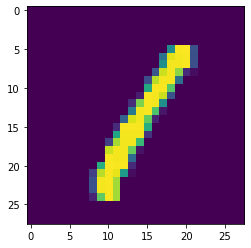

In [ ]:
plt.imshow(train_images[indices[0]].squeeze())

In [ ]:
indices = buscar_num(1,2,train_labels)

In [ ]:
image_name_0 = 'img_0.jpg'
image_name_1 = 'img_1.jpg'
cv2.imwrite(image_name_0,train_images[indices[0]]*255)
cv2.imwrite(image_name_1,train_images[indices[1]]*255)

True

In [ ]:
# Rotation of images
image_name_0 = 'img_0.jpg'
image_name_1 = 'img_1.jpg'

src = train_images[indices[0]]
rot_mat = rotation_matrix(src,15)
rotated_img = cv2.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))

cv2.imwrite(image_name_0,train_images[indices[0]]*255)
cv2.imwrite(image_name_1,rotated_img*255)

True

In [ ]:
# Rotation of heatmaps
image_name_0 = 'img_0.jpg'
image_name_1 = 'img_1.jpg'

src = grad_cam_plus(train_images[indices[0]],model,last_conv_layer,class_names).numpy()
rot_mat = rotation_matrix(src,0)
rotated_img = cv2.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))

cv2.imwrite(image_name_0,src*255)
cv2.imwrite(image_name_1,rotated_img*255)

1


True

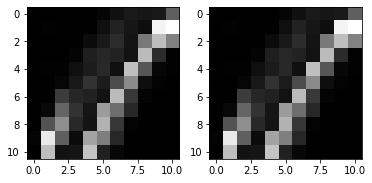

In [ ]:
img_0 = cv2.imread('img_0.jpg')
img_1 = cv2.imread('img_1.jpg')
plt.subplot(121).imshow(img_0)
plt.subplot(122).imshow(img_1)

In [ ]:
# Heatmaps
clase = 5
indices = buscar_num(clase,2,train_labels,200)
image_name_0 = 'img_0.jpg'
image_name_1 = 'img_1.jpg'
image_name_2 = 'img_2.jpg'

ht0 = grad_cam_plus(train_images[indices[0]],model,last_conv_layer,class_names).numpy()
ht1 = grad_cam_plus(train_images[indices[1]],model,last_conv_layer,class_names).numpy()
ht2 = grad_cam_plus(od_test_images[indices[1]],model,last_conv_layer,class_names).numpy() # una aleatoria de SVHN

cv2.imwrite(image_name_0,ht0*255)
cv2.imwrite(image_name_1,ht1*255)
cv2.imwrite(image_name_2,ht2*255)

dog
dog
cat


True

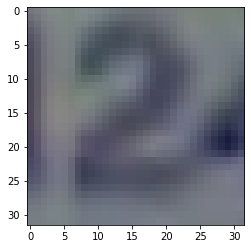

In [ ]:
plt.imshow(od_test_images[indices[1]])

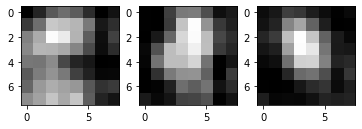

In [ ]:
img_0 = cv2.imread(image_name_0)
img_1 = cv2.imread(image_name_1)
img_2 = cv2.imread(image_name_2) 
plt.subplot(131).imshow(img_0)
plt.subplot(132).imshow(img_1)
plt.subplot(133).imshow(img_2)

In [ ]:
print('Heatmaps de misma clase')
print('CW-SSIM:',get_image_similarity(image_name_0,image_name_1,'CW-SSIM'))
print('SSIM:\t',ssim(np.mean(img_0,axis=2),np.mean(img_1,axis=2)),'\n')
print('Heatmaps 0 contra SVHN')
print('CW-SSIM:',get_image_similarity(image_name_0,image_name_2,'CW-SSIM'))
print('SSIM:\t',ssim(np.mean(img_0,axis=2),np.mean(img_2,axis=2)),'\n')
print('Heatmaps 1 contra SVHN')
print('CW-SSIM:',get_image_similarity(image_name_1,image_name_2,'CW-SSIM'))
print('SSIM:\t',ssim(np.mean(img_1,axis=2),np.mean(img_2,axis=2)),)

Heatmaps de misma clase
CW-SSIM: 0.8729901835296674
SSIM:	 0.34219948289328006 

Heatmaps 0 contra SVHN
CW-SSIM: 0.7479298942760755
SSIM:	 0.3303794144959548 

Heatmaps 1 contra SVHN
CW-SSIM: 0.9283257892952406
SSIM:	 0.7604451659352822


Pruebas para comparar un 1 rotado con un 7 en MNIST

In [ ]:
# Numero 1. El primer 1 después de la posicion 500 es rotado casualmente, y es detectado como un 1 por el modelo
indices = buscar_num(1,10,train_labels,500)
src = grad_cam_plus(train_images[indices[0]],model,last_conv_layer,class_names).numpy()
center = (src.shape[1]//2, src.shape[0]//2)
angle = -30
scale = 1
rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
rotated_img = cv2.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))

1


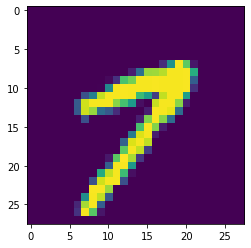

7


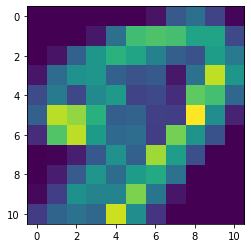

In [ ]:
plt.imshow(train_images[buscar_num(7,10,train_labels,75)[0],:,:,0])
plt.show()
plt.imshow(grad_cam_plus(train_images[buscar_num(7,10,train_labels,75)[0]],model,last_conv_layer,class_names).numpy())

1
1
7


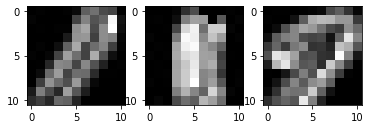

In [ ]:
# Heatmaps
clase = 1
indices = buscar_num(clase,10,train_labels,500)
image_name_0 = 'img_0.jpg'
image_name_1 = 'img_1.jpg'
image_name_2 = 'img_2.jpg'

ht0 = grad_cam_plus(train_images[indices[0]],model,last_conv_layer,class_names).numpy()
ht1 = grad_cam_plus(train_images[indices[8]],model,last_conv_layer,class_names).numpy()

# Un 7
ht2 = grad_cam_plus(train_images[buscar_num(7,10,train_labels,75)[0]],model,last_conv_layer,class_names).numpy() # una aleatoria de SVHN

cv2.imwrite(image_name_0,ht0*255)
cv2.imwrite(image_name_1,ht1*255)
cv2.imwrite(image_name_2,ht2*255)

img_0 = cv2.imread(image_name_0)
img_1 = cv2.imread(image_name_1)
img_2 = cv2.imread(image_name_2) 
plt.subplot(131).imshow(img_0)
plt.subplot(132).imshow(img_1)
plt.subplot(133).imshow(img_2)

In [ ]:
print('Heatmaps de misma clase')
print('CW-SSIM:',get_image_similarity(image_name_0,image_name_1,'CW-SSIM'))
print('SSIM:\t',ssim(np.mean(img_0,axis=2),np.mean(img_1,axis=2)),'\n')
print('Heatmaps 1 girado contra 7')
print('CW-SSIM:',get_image_similarity(image_name_0,image_name_2,'CW-SSIM'))
print('SSIM:\t',ssim(np.mean(img_0,axis=2),np.mean(img_2,axis=2)),'\n')
print('Heatmaps 1 contra 7')
print('CW-SSIM:',get_image_similarity(image_name_1,image_name_2,'CW-SSIM'))
print('SSIM:\t',ssim(np.mean(img_1,axis=2),np.mean(img_2,axis=2)),)

Heatmaps de misma clase
CW-SSIM: 0.7366078975862453
SSIM:	 0.3857794389176443 

Heatmaps 1 girado contra 7
CW-SSIM: 0.7911451748046965
SSIM:	 0.09246193153062712 

Heatmaps 1 contra 7
CW-SSIM: 0.8002206925336429
SSIM:	 0.008405688206225097


## Creation of a Pairwise Comparison Matrix

Function to generate random numbers

In [ ]:
def random_integers(seed, low, high, size, dtype):
    rng = np.random.default_rng(seed)
    return rng.integers(low, high, size, dtype)

In [ ]:
# List of last conv layers
convAndAddLayersNamesShapes = []
for layer in model.layers[::-1]:
  if isinstance(layer,(keras.layers.Conv2D,keras.layers.merge.Add)):
    convAndAddLayersNamesShapes.append([layer.name,layer.output_shape[1:3]])
print(convAndAddLayersNamesShapes)

[['add_14', (8, 8)], ['conv2d_32', (8, 8)], ['conv2d_31', (8, 8)], ['add_13', (8, 8)], ['conv2d_30', (8, 8)], ['conv2d_29', (8, 8)], ['add_12', (8, 8)], ['conv2d_28', (8, 8)], ['conv2d_27', (8, 8)], ['add_11', (8, 8)], ['conv2d_26', (8, 8)], ['conv2d_25', (8, 8)], ['add_10', (8, 8)], ['conv2d_22', (8, 8)], ['conv2d_24', (8, 8)], ['conv2d_23', (8, 8)], ['add_9', (16, 16)], ['conv2d_21', (16, 16)], ['conv2d_20', (16, 16)], ['add_8', (16, 16)], ['conv2d_19', (16, 16)], ['conv2d_18', (16, 16)], ['add_7', (16, 16)], ['conv2d_17', (16, 16)], ['conv2d_16', (16, 16)], ['add_6', (16, 16)], ['conv2d_15', (16, 16)], ['conv2d_14', (16, 16)], ['add_5', (16, 16)], ['conv2d_11', (16, 16)], ['conv2d_13', (16, 16)], ['conv2d_12', (16, 16)], ['add_4', (32, 32)], ['conv2d_10', (32, 32)], ['conv2d_9', (32, 32)], ['add_3', (32, 32)], ['conv2d_8', (32, 32)], ['conv2d_7', (32, 32)], ['add_2', (32, 32)], ['conv2d_6', (32, 32)], ['conv2d_5', (32, 32)], ['add_1', (32, 32)], ['conv2d_4', (32, 32)], ['conv2d_3', 

In [ ]:
cv2.resize(cv2.imread('/content/ResNet34v1.png', cv2.IMREAD_GRAYSCALE), SIM_IMAGE_SIZE)

array([[255, 255, 255, 255, 164, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 185, 185, 255, 185, 185, 185, 185],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [ ]:
# Code for creating the heatmaps for each class of each layer

# Parameters
num_heatmaps    = 50
num_heatmaps_od = 50
seed            = 7
#filename        = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/listHeatmapsPerLayerPerClass.pkl'

# Initialization
heatmapsPerLayer = []
imagesPerClass   = []
predsPerClass    = []
prueba           = random_integers(seed,low=0,high=8,size=1,dtype=int)
indexes_od       = random_integers(seed,low=0,high=len(od_test_images),size=num_heatmaps_od,dtype=int)

# Create de lists cotaining the images and predictions per class to then compute the heatmaps
for clase in range(num_clases+1):
# Initialize the images, predictions and the array for the heatmaps

  if clase == num_clases: # As range starts in 0, the OD dataset's index is not with +1
    imagesPerClass.append(np.array([od_test_images[j] for j in indexes]))    
  else:
    indexes = search_index_of_class(clase,num_heatmaps,test_labels,1000*prueba[0])   
    imagesPerClass.append(np.array([test_images[j] for j in indexes]).astype('float32'))

  predsPerClass.append(np.argmax(model.predict(imagesPerClass[clase]),axis=1))

In [ ]:
i_1 = grad_cam_plus(imagesPerClass[0][1],model,'add_29').numpy()
i_2 = grad_cam_plus(imagesPerClass[0][6],model,'add_29').numpy()
print(i_1.dtype)
get_image_similarity_heatmaps(i_1,i_2,'SIFT')

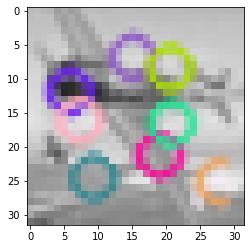

In [ ]:
img_orig = imagesPerClass[0][1]
gray= (cv2.cvtColor(img_orig,cv2.COLOR_BGR2GRAY)*255).astype('uint8')
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,gray)
plt.imshow(img)

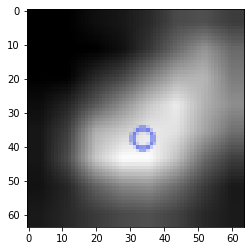

In [ ]:
img_orig = cv2.resize(i_2,(64,64))
gray= (img_orig*255).astype('uint8')
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,gray)
plt.imshow(img)

In [ ]:
# Initiate FAST detector
star = cv2.FastFeatureDetector_create()
# Initiate BRIEF extractor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
# find the keypoints with STAR
kp = star.detect(img,None)
# compute the descriptors with BRIEF
kp, des = brief.compute(img, kp)
print( brief.descriptorSize() )
print( des.shape )

Number of Keypoints Detected In The Training Image:  24
Number of Keypoints Detected In The Query Image:  11


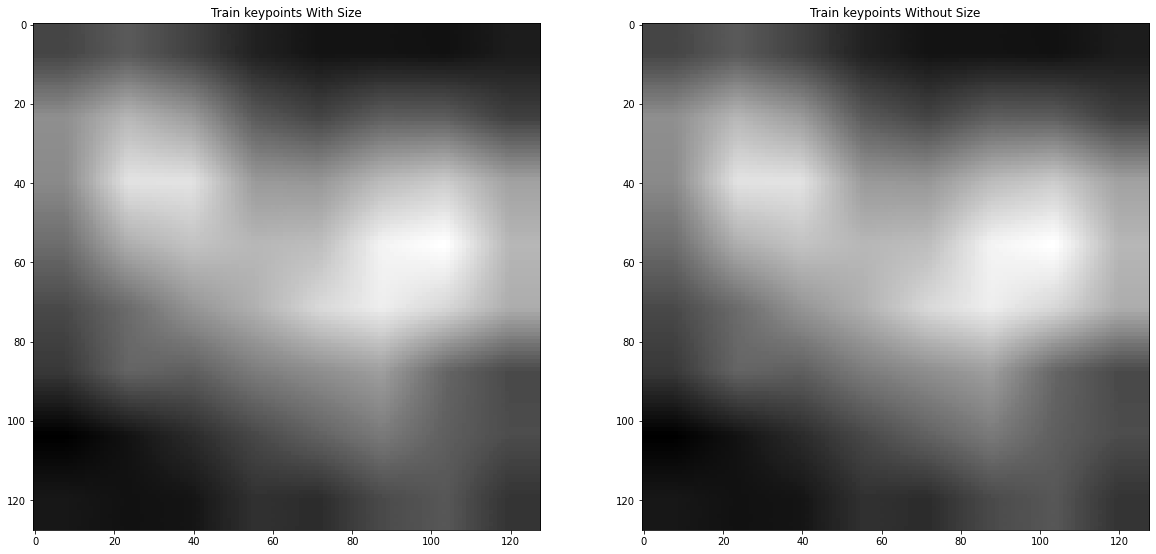

In [ ]:
size = 128
'''
training_image = cv2.resize((imagesPerClass[0][1]*255).astype('uint8'),(size,size))
test_image     = cv2.resize((imagesPerClass[0][2]*255).astype('uint8'),(size,size))

training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)
test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
'''
training_gray = cv2.resize((imagesPerClass[0][1]*255).astype('uint8'),(size,size))
test_gray     = cv2.resize((imagesPerClass[0][2]*255).astype('uint8'),(size,size))


fast = cv2.FastFeatureDetector_create() 
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

train_keypoints = fast.detect(training_gray, None)
test_keypoints = fast.detect(test_gray, None)

train_keypoints, train_descriptor = brief.compute(training_gray, train_keypoints)
test_keypoints, test_descriptor = brief.compute(test_gray, test_keypoints)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

In [ ]:
brief.

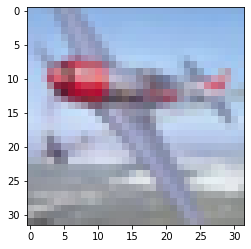

(<matplotlib.image.AxesImage at 0x7f6f9db1f350>, None)

In [ ]:
# Trying resizes
size = 32
img = (imagesPerClass[0][1]*255).astype('uint8')
img = cv2.resize(img,(size,size))

# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

Creation of the array with the heatmaps. For each layer, 10+1 clases and 50 heatmaps per class

In [ ]:
# Code for creating the heatmaps for each class of each layer

# Parameters
num_heatmaps     = 50
num_heatmaps_od  = 50
seed             = 7
dirName          = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/'
chekpointDirPath = 'checkpoints/'
chkFileName      = '_chk'
fileName         = 'listHeatmapsPerLayerPerClass'
fileFormat       = '.pkl'

# Initialization
heatmapsPerLayer = []
imagesPerClass   = []
predsPerClass    = []
prueba           = random_integers(seed,low=0,high=8,size=1,dtype=int)
indexes_od       = random_integers(seed,low=0,high=len(od_test_images),size=num_heatmaps_od,dtype=int)

# Create de lists cotaining the images and predictions per class to then compute the heatmaps

for clase in range(num_clases+1):
# Initialize the images, predictions and the array for the heatmaps

  if clase == num_clases: # As range starts in 0, the OD dataset's index is not with +1
    imagesPerClass.append(np.array([od_test_images[j] for j in indexes]))    
  else:
    indexes = search_index_of_class(clase,num_heatmaps,test_labels,1000*prueba[0])   
    imagesPerClass.append(np.array([test_images[j] for j in indexes]).astype('float32'))

  predsPerClass.append(np.argmax(model.predict(imagesPerClass[clase]),axis=1))


# Creation of the list with the heatmaps

for layerNameShape in tqdm(convAndAddLayersNamesShapes):
  
  # Initialize the list for every layer
  heatmapsPerClass = []

  for clase in range(num_clases+1): # +1 to take into account that we have an extra class, the OD Dataset

    # Initialize the images, predictions and the array for the heatmaps
    if clase == num_clases: # As range starts in 0, the OD dataset's index is not with +1
      heatmaps = np.zeros((num_heatmaps_od,layerNameShape[1][0],layerNameShape[1][1]),dtype='float32') # In case we have more heatmaps for the OD case       
    else:
      heatmaps = np.zeros((num_heatmaps,layerNameShape[1][0],layerNameShape[1][1]),dtype='float32')

    # Compute the heatmaps for the class
    for i in range(len(heatmaps)):
      heatmaps[i] = grad_cam_plus(imagesPerClass[clase][i],model,layerNameShape[0],category_id=predsPerClass[clase][i])
    
    # Append the heatmaps created to a list, each class in a position of the list. For every layer the list is emptied
    heatmapsPerClass.append(heatmaps)
  
  # Append the heatmaps of the layer to the complete list
  heatmapsPerLayer.append(heatmapsPerClass)

  # Save heatmaps to a pickle file as chekpoint
  opened_file = open(dirName+chekpointDirPath+fileName+chkFileName+fileFormat,'wb')
  pickle.dump(heatmapsPerLayer,opened_file)
  opened_file.close()


# Save heatmaps to a pickle file
opened_file = open(dirName+fileName+fileFormat,'wb')
pickle.dump(heatmapsPerLayer,opened_file)
opened_file.close()

Load the heatmaps created

In [ ]:
# Load heatmaps from a pickle file of drive
dirName          = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/'
chekpointDirPath = 'checkpoints/'
chkFileName      = '_chk'
fileName         = 'listHeatmapsPerLayerPerClass'
fileFormat       = '.pkl'
opened_file = open(dirName+fileName+fileFormat,'rb')
heatmapsPerLayer = pickle.load(opened_file)
opened_file.close()

Testing the influence of resizing in SSIM

In [ ]:
print(ssim(heatmapsPerLayer[12][2][2],heatmapsPerLayer[12][2][3]))
print(ssim(resize(heatmapsPerLayer[12][2][2],(32,32)),resize(heatmapsPerLayer[12][2][3],(32,32))))

0.12327861704105698
0.10182934801528223


In [ ]:
print(ssim(heatmapsPerLayer[12][2][2].astype('float32'),heatmapsPerLayer[12][2][3].astype('float32')))
print(ssim(resize(heatmapsPerLayer[12][2][2],(32,32)).astype('float32'),resize(heatmapsPerLayer[12][2][3],(32,32)).astype('float32')))

0.12327861704105698
0.10182934906912401


Creation of the matrix with the pairwise comparisons

In [ ]:
heatmapsPerLayer[0][0].shape

(50, 8, 8)

In [ ]:
# Code for creating a big array with all pairwise comparisons between heatmaps of diferent layers

# CHOOSE THE COMPARISON METHOD
comparisonMethod    = 'CW-SSIM'

comparisonsPerClass = []
comparisonsPerLayer = []
directoryPath       = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/'
filenameComp        = 'comparisonPerLayer_{}.pkl'.format(comparisonMethod)
chekpointDirPath    = 'checkpoints/'
filenameCompCheckp  = 'comparisonPerLayer_{}_checkpoint.pkl'.format(comparisonMethod)
termination         = '.pkl'
shape               = test_images.shape[1:3]
num_heatmaps        = 50

# If I interrut and the want to resume from a certain point, I must write code to avoid computing a part with Continue instruction and os.listdir

for heatmapsOneLayer in tqdm(heatmapsPerLayer[:31]): # For each layer of heatmaps

  # Initialize the comparisons list
  comparisonsMatrix = np.zeros((len(heatmapsOneLayer),len(heatmapsOneLayer),num_heatmaps,num_heatmaps),dtype='float32')

  for ind_cl_ref,htmaps_OneClass_ref in enumerate(heatmapsOneLayer): # For each class



    for ind_cl_comp in range(ind_cl_ref,len(heatmapsOneLayer)): # One class less for each run.


      #comparisonsMatrix = np.zeros((len(htmaps_OneClass_ref),len(htmaps_OneClass_ref)))


      for i_htmap_ref, heatmap_ref in enumerate(htmaps_OneClass_ref):
        
        for i_heatmap_comp in range(i_htmap_ref,len(heatmapsOneLayer[ind_cl_comp])):

          if comparisonMethod == 'SSIM':
            comparisonsMatrix[ind_cl_ref,ind_cl_comp][i_htmap_ref,i_heatmap_comp] = ssim(resize(heatmap_ref,shape),resize(heatmapsOneLayer[ind_cl_comp][i_heatmap_comp],shape))
          elif comparisonMethod == 'CW-SSIM':
            # We do no resize because the function does it internally
            comparisonsMatrix[ind_cl_ref,ind_cl_comp][i_htmap_ref,i_heatmap_comp] = get_image_similarity_heatmaps(heatmap_ref,heatmapsOneLayer[ind_cl_comp][i_heatmap_comp],'CW-SSIM').astype('float32')
          else:
            raise NameError(f'{comparisonMethod} is not a valid method of comparioson')

  comparisonsPerLayer.append(comparisonsMatrix)
  # Save heatmaps to a pickle file
  opened_file = open(directoryPath+chekpointDirPath+filenameCompCheckp,'wb')
  pickle.dump(comparisonsPerLayer,opened_file)
  opened_file.close()

# Save heatmaps to a pickle file when finish
opened_file = open(directoryPath+filenameComp,'wb')
pickle.dump(comparisonsPerLayer,opened_file)
opened_file.close()


0it [00:00, ?it/s]
1it [12:35, 755.20s/it]
2it [24:45, 747.84s/it]
3it [36:59, 743.70s/it]
4it [49:25, 744.40s/it]
5it [1:01:24, 736.67s/it]
6it [1:13:26, 732.15s/it]
7it [1:25:22, 727.27s/it]
8it [1:37:21, 724.94s/it]
9it [1:49:26, 725.00s/it]
10it [2:01:24, 722.84s/it]
11it [2:13:21, 721.14s/it]
12it [2:25:25, 721.82s/it]
13it [2:37:19, 719.57s/it]
14it [2:49:14, 718.24s/it]
15it [3:01:12, 718.05s/it]
16it [3:13:07, 717.40s/it]
17it [3:25:04, 717.27s/it]
18it [3:37:03, 717.54s/it]
19it [3:49:04, 718.65s/it]
20it [4:01:10, 720.91s/it]
21it [4:13:17, 722.81s/it]
22it [4:25:20, 722.89s/it]
23it [4:37:25, 723.39s/it]
24it [4:49:28, 723.37s/it]
25it [5:01:33, 723.77s/it]
26it [5:13:40, 724.65s/it]
27it [5:25:45, 724.74s/it]
28it [5:37:47, 723.99s/it]
29it [5:49:55, 725.15s/it]
30it [6:01:55, 723.79s/it]
31it [6:14:01, 723.91s/it]


Testing the obtained comparisons

In [ ]:
len(comparisonsPerLayer)

31

In [ ]:
heatmapsPerLayer[0][0,1]-comparisonsPerLayer[0][0,2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
len(heatmapsPerLayer[0])

Load the list of Comparison Matrix per layer

In [ ]:
# Load the comparisons
comparisonsPerLayer        = []
comparisonMethod           = 'SSIM'

directoryPath              = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/'
pairwiseComparisonsDirName = 'Pairwise_Comparisons_Plots/'
filenameComp               = 'comparisonPerLayer_{}.pkl'.format(comparisonMethod)
chekpointDirPath           = 'checkpoints/'
filenameCompCheckp         = 'comparisonPerLayer_{}_chk_'.format(comparisonMethod)
termination                = '.pkl'

opened_file = open(directoryPath+pairwiseComparisonsDirName+filenameComp,'rb')
comparisonsPerLayer = pickle.load(opened_file)
opened_file.close()

Ploting the comparison matrix

In [ ]:
# Mean of each class of a layer
selectedLayer = 11
meansMatrix = np.zeros(comparisonsPerLayer[0].shape[0:2])

for i in range(len(comparisonsPerLayer[selectedLayer])):

  for j in range(len(comparisonsPerLayer[selectedLayer][i])):

    meansMatrix[i,j] = np.mean(comparisonsPerLayer[selectedLayer][i,j]) 

In [ ]:
import seaborn as sb
from google.colab import files

In [ ]:
# Create ans save in Drive
MethodDirName               = 'SSIM'

# Create the folder if it doesnt exist
rootDir                     = '/content/'
pathToDriveFolder           = 'drive/MyDrive/Colab_Notebooks/3_OOD_XAI'
pairwiseComparisonsDirName  = 'Pairwise_Comparisons_Plots/'

folderPath = os.path.join(rootDir,pathToDriveFolder,pairwiseComparisonsDirName+MethodDirName)
if not os.path.exists(folderPath):
  os.mkdir(folderPath)

for selectedLayer in range(len(comparisonsPerLayer)):

  meansMatrix = np.zeros(comparisonsPerLayer[0].shape[0:2])

  for i in range(len(comparisonsPerLayer[selectedLayer])):

    for j in range(len(comparisonsPerLayer[selectedLayer][i])):

      meansMatrix[i,j] = np.mean(comparisonsPerLayer[selectedLayer][i,j]) 


  fig,ax = plt.subplots(figsize=(20,20))
  ax.set_title('{} / Size {}'.format(convAndAddLayersNamesShapes[selectedLayer][0],convAndAddLayersNamesShapes[selectedLayer][1]),fontsize=20)
  sb.heatmap(meansMatrix,vmin=0,vmax=1, annot=True,cmap="YlGnBu")
  # Set another y label
  ax2 = ax.twinx()
  
  # Extract location of yticks
  locs1 = ax.get_yticks()
  locs2 = locs1.copy()

  # Set the right Y axis correctly
  ax2.set(xlim=(0, len(meansMatrix)), ylim=(0, len(meansMatrix)))
  ax2.invert_yaxis()
  ax2.yaxis.set_ticks(locs2)
  ylabelsRight = [round((meansMatrix[i,i] - meansMatrix[i,10]),2) for i in range(len(meansMatrix))]
  ax2.set_ylabel('Difference between the mean of the class vs himself and the OD class (10th class) // Total mean = {:0.2f}'.format(np.mean(ylabelsRight)),fontsize=12,labelpad=12)
  ax2.set_yticklabels(['{:0.2f}'.format(ylabelsRight[i]) for i in range(len(meansMatrix))])
  
  # Save fig
  heatmapPlotFileName = 'pairwiseComparisonsHeatmapPlot_layer_{:0>2d}.png'.format(selectedLayer)
  plt.savefig(os.path.join(folderPath,heatmapPlotFileName))
  #files.download(os.path.join(rootDir,pairwiseComparisonsDirName,heatmapPlotFileName))
  plt.close() # To avoid plotting all the figures

Tests for creating the comparison matrix

In [ ]:
# Code for creating a big array with all pairwise comparisons between heatmaps of diferent layers
comparisonsPerClass = []
comparisonsPerLayer = []
comparisonMethod    = 'SSIM'
directoryPath       = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/'
filenameComp        = 'comparisonPerLayer_{}.pkl'.format(comparisonMethod)
chekpointDirPath    = 'checkpoints/'
filenameCompCheckp  = 'comparisonPerLayer_{}_chk_'.format(comparisonMethod)
termination         = '.pkl'
shape               = test_images.shape[1:3]

# If I interrut and the want to resume from a certain point, I must write code to avoid computing a part with Continue instruction and os.listdir

for i,heatmapsOneLayer in tqdm(enumerate(heatmapsPerLayer)): # For each layer of heatmaps
  
  # Initialize the comparisons list
  comparisonsPerRefClass = []

  for ind_cl_ref,htmaps_OneClass_ref in enumerate(heatmapsOneLayer): # For each class

    for ind_cl_comp in range(ind_cl_ref,len(heatmapsOneLayer)): # One class less for each run.


      comparisonsMatrix = np.zeros((len(htmaps_OneClass_ref),len(htmaps_OneClass_ref))


      for i_htmap_ref, heatmap_ref in htmaps_OneClass_ref:

        for i_heatmap_comp in range(i_htmap_ref,len(heatmapsOneLayer[ind_cl_comp])):

          if comparisonMethod == 'SSIM':
            comparisonsMatrix[i_htmap_ref,i_heatmap_comp] = 1
            # Resize for not encounting an error when comparing two different sizes
            #comparisonsPerRefClass.append(ssim(resize(heatmap_ref,shape),resize(heatmap_comp,shape)))



      comparisonsPerRefClass.append(comparisonsMatrix)
    
  comparisonsPerLayer.append(comparisonsPerRefClass)
  # Save heatmaps to a pickle file
  opened_file = open(directoryPath+chekpointDirPath+filenameCompCheckp+'{:0>2d}'.format(i)+termination,'wb')
  pickle.dump(comparisonsPerLayer,opened_file)
  opened_file.close()

comparisonsPerLayer = []
for heatmapsOneLayerAllClasses in tqdm(heatmapsPerLayer):

  comparisonsOneLayer = np.zeros((len(heatmapsOneLayerAllClasses)*len(heatmapsOneLayerAllClasses[0]),len(heatmapsOneLayerAllClasses)*len(heatmapsOneLayerAllClasses[0])))

  for 



# Save heatmaps to a pickle file
opened_file = open(directoryPath+filenameComp,'wb')
pickle.dump(comparisonsPerLayer,opened_file)
opened_file.close()

In [ ]:
len(heatmapsPerLayer[0][1])

50

In [ ]:
comparisonMethod    = 'SSIM'
directoryPath       = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/'
filenameComp        = 'comparisonPerLayer_{}.pkl'.format(comparisonMethod)
chekpointDirPath    = 'checkpoints/'
filenameCompCheckp  = 'comparisonPerLayer_{}_chk_'.format(comparisonMethod)
termination         = '.pkl'

In [ ]:
# Load the file with the comparisons
opened_file = open(directoryPath+filenameComp,'rb')
comparisonsPerLayer = pickle.load(opened_file)
opened_file.close()

In [ ]:
comparisonsPerLayer

In [ ]:
# Plot a layer of comparisons
comparisonsPerLayer[0][:52]

In [ ]:
t.imshow(grad_cam_plus(imagenes_cifar[0],model,convAndAddLayers[37]),cmap='jet',vmin=0,vmax=1)
plt.colorbar()

## Plot of GradCam in differents layers of the ResNet

In [ ]:
# Plot of multiple 

superimposed  = True
reescaled     = True

fontsize = 18
cmap     = 'jet'
rows = 10
cols = 15
seed = 2

predicciones_test = np.argmax(model.predict(test_images),axis=1)
predicciones_od = np.argmax(model.predict(od_test_images),axis=1)

ind  = random_integers(seed,0,len(predicciones_test),(rows,cols-1),dtype=int)

fig, ax = plt.subplots(rows,cols,figsize=(60,40))
print(ax.shape)
for i in range(rows):
    for j in range(cols):
      
      ax[i][j].set_axis_off() # No axis plotted    

      if j == cols-1: # The las column is for plotting the mean heatmaps
          ax[i][j].set_title(f'Class {class_names[i]}')
          if reescaled == True or superimposed == True:
            ax[i][j].imshow(resize(lista_htmaps_prom_x_clase[i],test_images.shape[1:3]),cmap=cmap)
          else:
            ax[i][j].imshow(lista_htmaps_prom_x_clase[i],cmap=cmap)

      else: # For al other columns
        ind_local = int(ind[i,j]) # Set the index for each run

        if i % 2 == 0: # In the even rows the SVHN's heatmaps are plotted
          ax[i][j].set_title(f'{class_names[predicciones_od[ind_local]]} // {round(ssim(array_htmaps_od[ind_local],lista_htmaps_prom_x_clase[predicciones_od[ind_local]]),3)}',fontsize=fontsize)
          
          if superimposed == True:
            ax[i][j].imshow(od_test_images[ind_local])
            im = ax[i][j].imshow(resize(array_htmaps_od[ind_local],od_test_images.shape[1:3]),vmin=0,vmax=1,alpha=0.6,cmap=cmap)

          elif superimposed == False and reescaled == True:
            im = ax[i][j].imshow(resize(array_htmaps_od[ind_local],od_test_images.shape[1:3]),vmin=0,vmax=1,cmap=cmap)

          else:
            im = ax[i][j].imshow(array_htmaps_od[ind_local],vmin=0,vmax=1,cmap=cmap)

        else: # Plotting in the odd rows the Cifar10 heatmaps
          ax[i][j].set_title(f'{class_names[predicciones_test[ind_local]]} // {round(ssim(array_htmaps_test[ind_local],lista_htmaps_prom_x_clase[predicciones_test[ind_local]]),3)}',fontsize=fontsize)

          if superimposed == True:
            ax[i][j].imshow(test_images[ind_local])
            im = ax[i][j].imshow(resize(array_htmaps_test[ind_local],test_images.shape[1:3]),vmin=0,vmax=1,alpha=0.6,cmap=cmap)

          elif superimposed == False and reescaled == True:
            im = ax[i][j].imshow(resize(array_htmaps_test[ind_local],test_images.shape[1:3]),vmin=0,vmax=1,cmap=cmap)

          else:
            im = ax[i][j].imshow(array_htmaps_test[ind_local],vmin=0,vmax=1,cmap=cmap)
    
#fig.subplots_adjust(right=0.80)
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.78])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(f'Entramado_seed_{seed}.png')

In [ ]:
model.summary()

In [ ]:
# List of last conv layers
convAndAddLayers = []
for layer in model.layers[::-1]:
  if isinstance(layer,(keras.layers.Conv2D)):
    convAndAddLayers.append(layer.name)
convAndAddLayers = convAndAddLayers[0:]
print(len(convAndAddLayers))

33


In [ ]:
# Hyperparameters
superimposed  = True
reescaled     = True
seed      = 15

fontsize  = 18
cmap      = 'jet'
rows      = 10
cols      = 15
indexes   = random_integers(seed,0,len(test_images),(cols-1),dtype=int)
#index = random_integers(seed,0,len(predicciones_test),1,dtype=int)

# Creation of the heatmaps
imagenes_cifar    = np.array([test_images[i] for i in indexes])
pred_imagen_cifar = np.argmax(model.predict(imagenes_cifar),axis=1)

imagenes_od       = np.array([od_test_images[i] for i in indexes])
pred_imagen_od    = np.argmax(model.predict(imagenes_od),axis=1)

tamanio           = 8
htmaps            = np.zeros((rows,cols,tamanio,tamanio))

for i in range(rows):
    for j in range(cols-1): # La ultima columna es el heatmap mediana o promedio
      
      if i%2 == 0:
        htmaps[i,j] = grad_cam_plus(imagenes_od[j],model,convAndAddLayers[i//2],category_id=pred_imagen_od[j])

      else:
        htmaps[i,j] = grad_cam_plus(imagenes_cifar[j],model,convAndAddLayers[(i//2)],category_id=pred_imagen_cifar[j])

(10, 15)


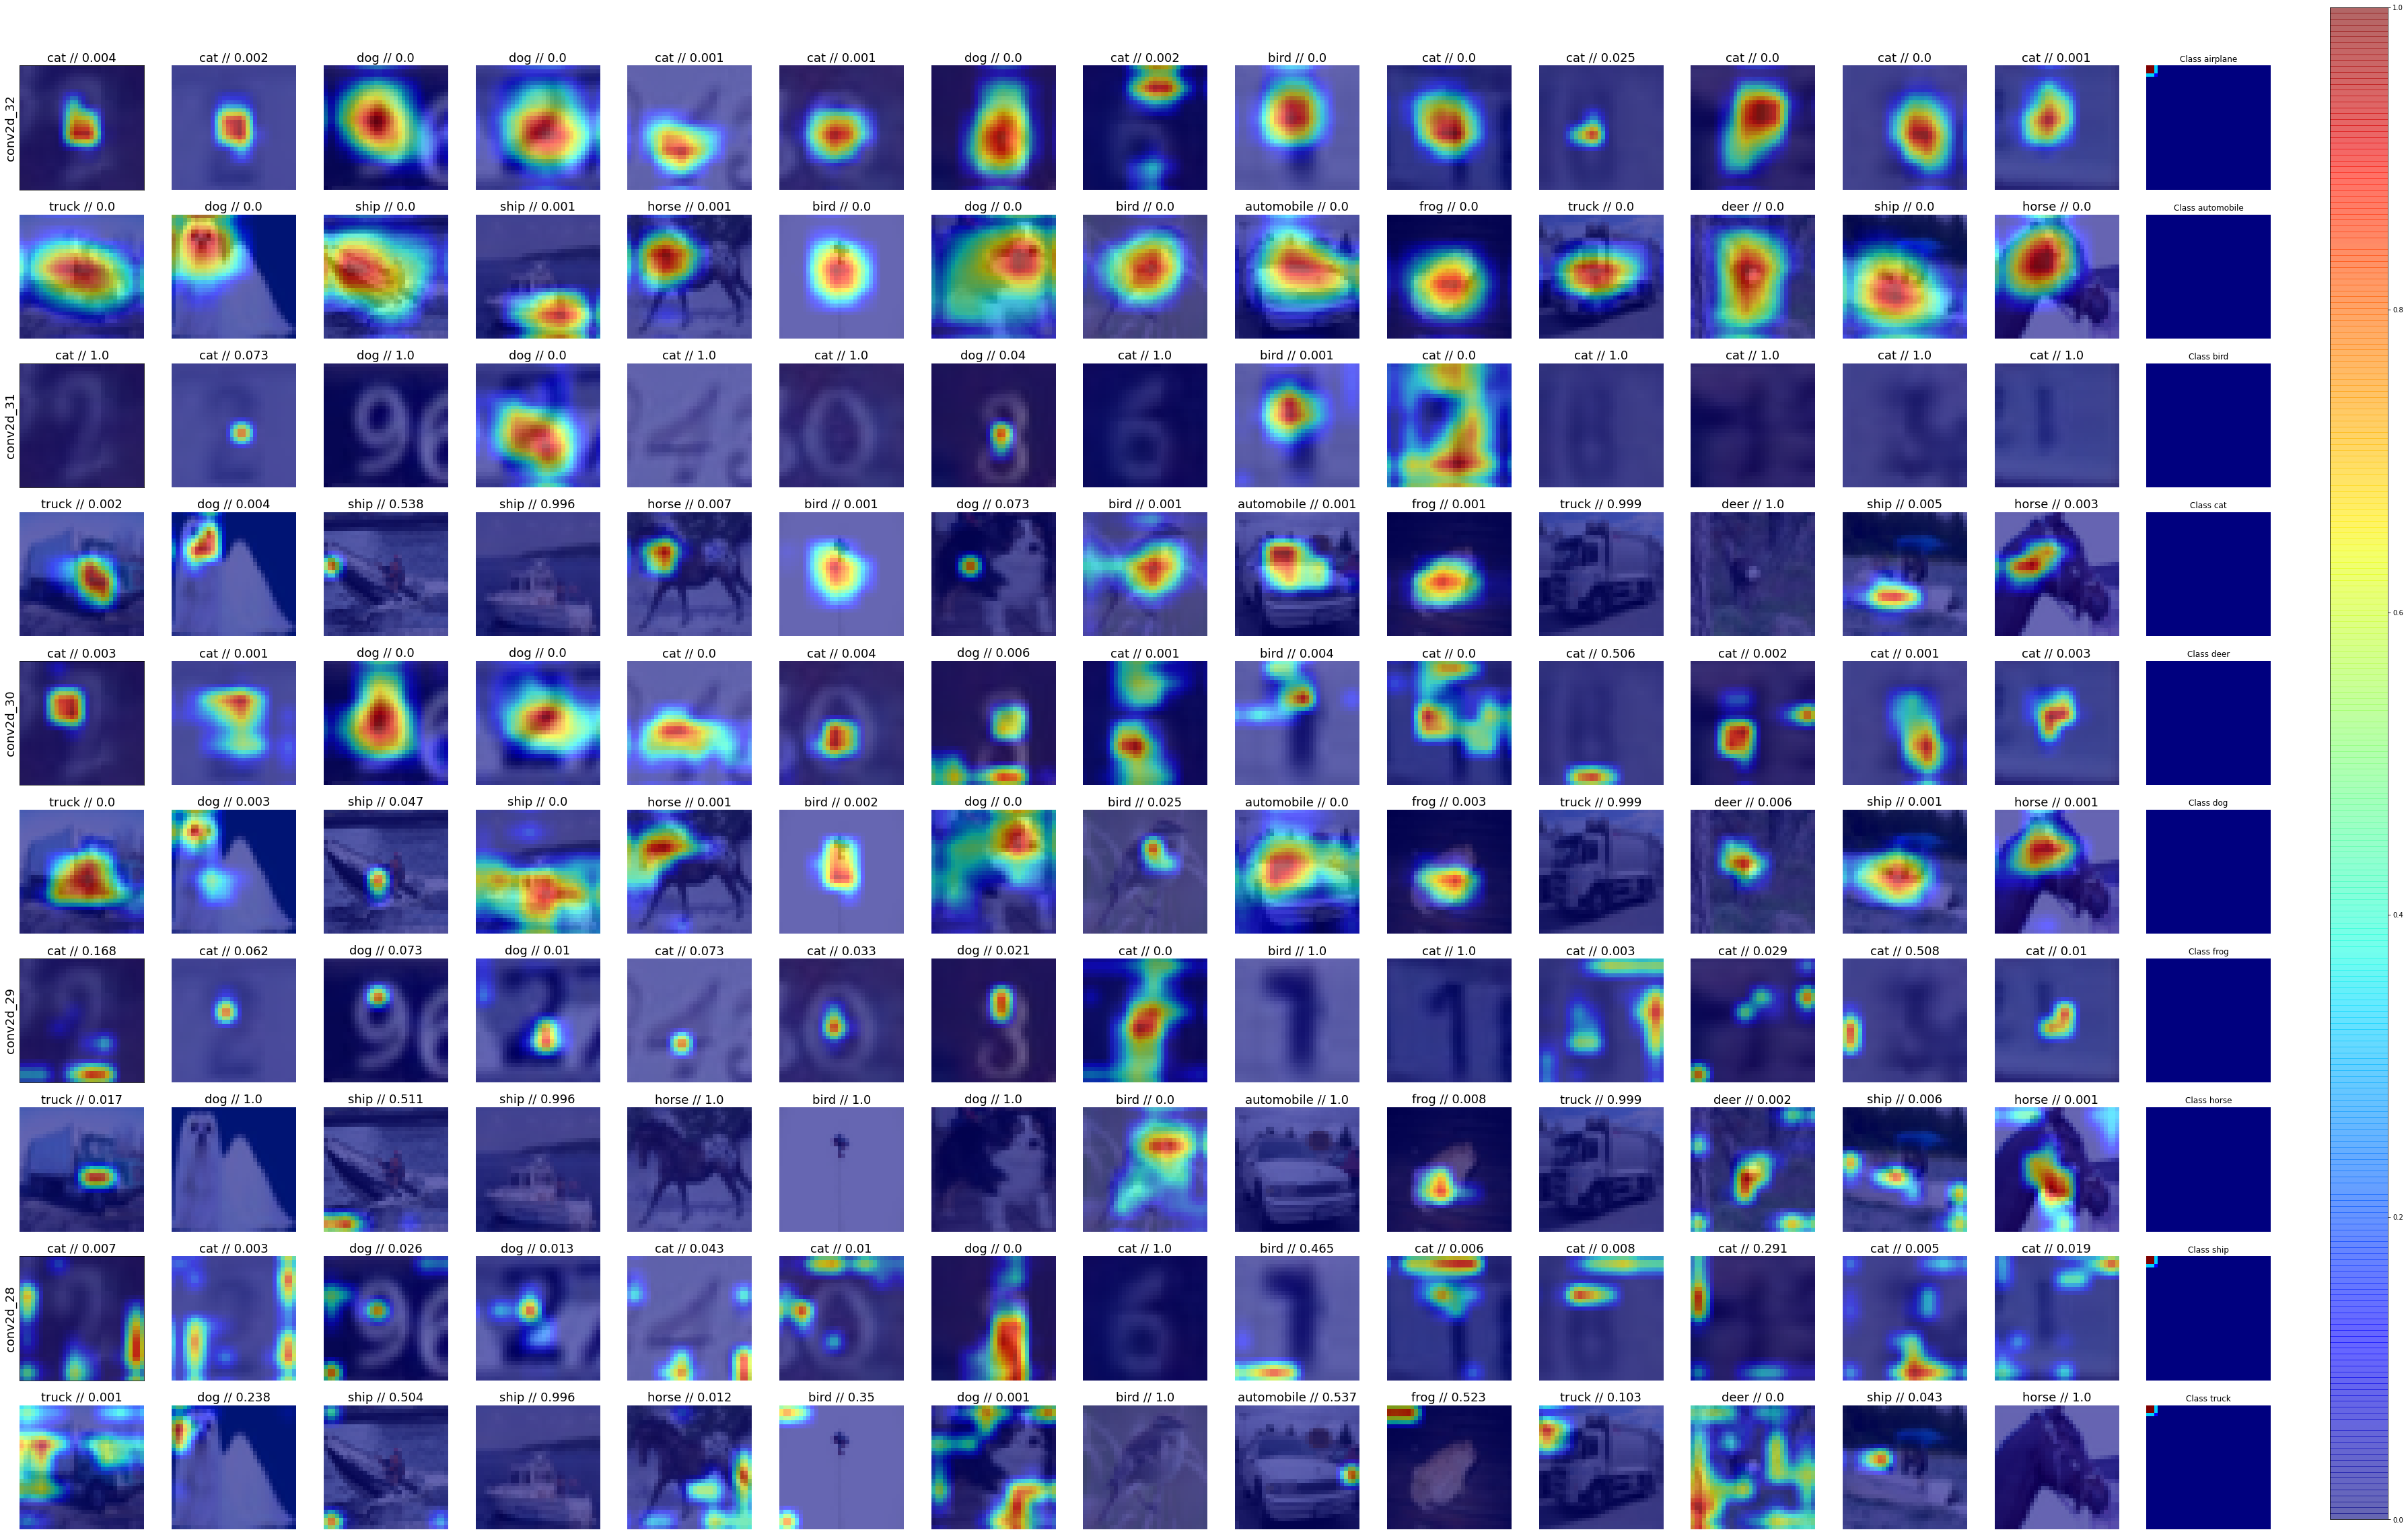

In [ ]:
# Plot of multiple

fig, ax = plt.subplots(rows,cols,figsize=(60,40))
print(ax.shape)
for i in range(rows):
    for j in range(cols):
      
      if i%2 == 0 and j == 0:
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].set_ylabel(convAndAddLayers[i//2],fontsize=fontsize)
      else: 
        ax[i][j].set_axis_off() # No axis plotted    

      if j == cols-1: # The las column is for plotting the mean heatmaps
          ax[i][j].set_title(f'Class {class_names[i]}')
          if reescaled == True or superimposed == True:
            ax[i][j].imshow(resize(lista_htmaps_prom_x_clase[i],test_images.shape[1:3]),cmap=cmap)
          else:
            ax[i][j].imshow(lista_htmaps_prom_x_clase[i],cmap=cmap)

      else: # For al other columns

        if i % 2 == 0: # In the even rows the SVHN's heatmaps are plotted
          ax[i][j].set_title(f'{class_names[pred_imagen_od[j]]} // {round(ssim(htmaps[i,j],resize(lista_htmaps_prom_x_clase[pred_imagen_od[j]],(tamanio,tamanio))),3)}',fontsize=fontsize)
          
          if superimposed == True:
            ax[i][j].imshow(imagenes_od[j])
            im = ax[i][j].imshow(resize(htmaps[i,j],imagenes_od.shape[1:3]),vmin=0,vmax=1,alpha=0.6,cmap=cmap)

          elif superimposed == False and reescaled == True:
            im = ax[i][j].imshow(resize(htmaps[i,j],imagenes_od.shape[1:3]),vmin=0,vmax=1,cmap=cmap)

          else:
            im = ax[i][j].imshow(htmaps[i,j],vmin=0,vmax=1,cmap=cmap)

        else: # Plotting in the odd rows the Cifar10 heatmaps
          ax[i][j].set_title(f'{class_names[pred_imagen_cifar[j]]} // {round(ssim(htmaps[i,j],resize(lista_htmaps_prom_x_clase[pred_imagen_cifar[j]],(tamanio,tamanio))),3)}',fontsize=fontsize)

          if superimposed == True:
            ax[i][j].imshow(imagenes_cifar[j])
            im = ax[i][j].imshow(resize(htmaps[i,j],imagenes_cifar.shape[1:3]),vmin=0,vmax=1,alpha=0.6,cmap=cmap)

          elif superimposed == False and reescaled == True:
            im = ax[i][j].imshow(resize(htmaps[i,j],imagenes_cifar.shape[1:3]),vmin=0,vmax=1,cmap=cmap)

          else:
            im = ax[i][j].imshow(htmaps[i,j],vmin=0,vmax=1,cmap=cmap)
    
#fig.subplots_adjust(right=0.80)
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.78])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(f'Entramado_seed_{seed}.png')

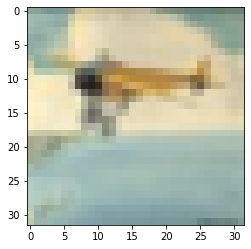

In [ ]:
plt.imshow(imagenes_cifar[2])

7


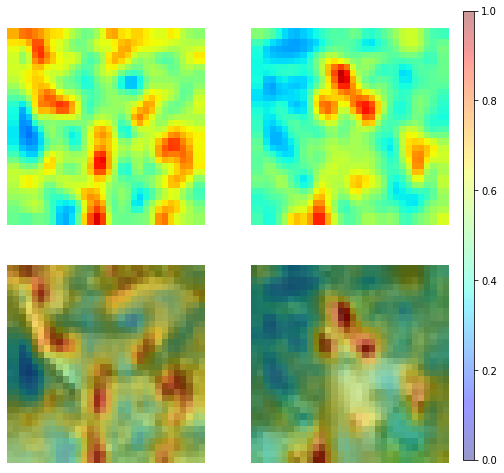

SSIM:	 0.047
CW-SSIM: 0.577
SIFT:	 1.0
SIFT:	 1.0


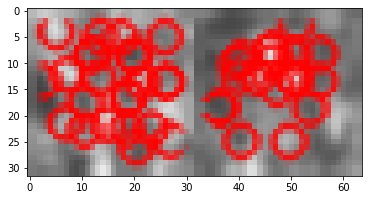

In [ ]:
# Inicializar imagenes
i = 3
i = (i*2)+1
print(i)
j_1 = 4
j_2 = 0

new_size = 32
img1 = resize(htmaps[i,j_1],(new_size,new_size))
img2 = resize(htmaps[i,j_2],(new_size,new_size))
'''
fig ,ax =plt.subplots(1,2)
im = ax[0].set_axis_off()
ax[1].set_axis_off()
plt.subplot(121).imshow(img1,cmap=cmap,vmin=0,vmax=1)
plt.subplot(122).imshow(img2,cmap=cmap,vmin=0,vmax=1)
plt.show()
'''

r = 2
c = 2
fig,ax = plt.subplots(r,c,figsize=(8,8))
for axes_i in ax:
  for axes in axes_i:
    axes.set_axis_off()
ax[0,0].imshow(img1,cmap=cmap,vmin=0,vmax=1)
ax[0,1].imshow(img2,cmap=cmap,vmin=0,vmax=1)
ax[1,0].imshow(imagenes_cifar[j_1],cmap=cmap,vmin=0,vmax=1)
ax[1,0].imshow(img1,cmap=cmap,vmin=0,vmax=1,alpha=0.4)
ax[1,1].imshow(imagenes_cifar[j_2],cmap=cmap,vmin=0,vmax=1)
im1 = ax[1,1].imshow(img2,cmap=cmap,vmin=0,vmax=1,alpha=0.4)

cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.78])
fig.colorbar(im1, cax=cbar_ax)
'''
r = 2
c = 2
fig ,ax = plt.subplots(r,c)
for i in range(r):
  for i in range(c):
    im = ax[0].set_axis_off()
    ax[1].set_axis_off()
    if i == 0:
      if j == 0:
        ax[i,j].imshow(img1,cmap=cmap,vmin=0,vmax=1)
      else:
        ax[i,j].imshow(img2,cmap=cmap,vmin=0,vmax=1)
'''    
plt.show()

img1 = (img1*255).astype('uint8')
img2 = (img2*255).astype('uint8')
cv2.imwrite('imagen_1.jpg',img1)
cv2.imwrite('imagen_2.jpg',img2)
#img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
#img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
print('SSIM:\t',round(ssim(img1,img2),3))
print('CW-SSIM:',round(get_image_similarity('imagen_1.jpg','imagen_2.jpg','CW-SSIM'),3))
print('SIFT:\t',round(get_image_similarity('imagen_1.jpg','imagen_2.jpg','SIFT'),3))
print('SIFT:\t',round(get_image_similarity('imagen_1.jpg','imagen_2.jpg','SIFT'),3))
#img1 = cv.normalize(img1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
#img2 = cv.normalize(img2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

# Initiate SIFT detector
sift=cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        a=len(good)
        print(a)
        percent=(a*100)/len(kp1) # Esto realmente era sin len(), pero daba fallo. Creo que así se corrige, ya que lo que se buscas es saber el % de buenos que hay frente a el total de descriptores
        print("{} % similarity".format(percent))
        if percent >= 75.00:
            print('Match Found')
            break;

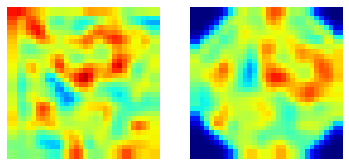

SSIM: 0.04035256229344075


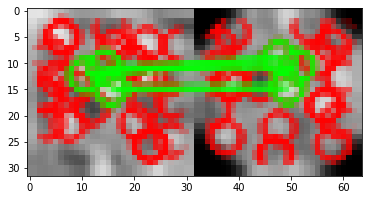

1
3.7037037037037037 % similarity
2
7.407407407407407 % similarity
3
11.11111111111111 % similarity
4
14.814814814814815 % similarity
5
18.51851851851852 % similarity
6
22.22222222222222 % similarity


In [ ]:
# Inicializar imagenes
clase = 5
i = 1
j_1 = 4
j_2 = 4

src = htmaps[i,j_1]
center = (src.shape[1]//2, src.shape[0]//2)
angle = -45
scale = 1
rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
warp_rotate_dst = cv2.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))

new_size = 32
img1 = resize(htmaps[i,j_1],(new_size,new_size))
img2 = resize(warp_rotate_dst,(new_size,new_size))

fig ,ax =plt.subplots(1,2)
im = ax[0].set_axis_off()
ax[1].set_axis_off()
plt.subplot(121).imshow(img1,cmap=cmap,vmin=0,vmax=1)
plt.subplot(122).imshow(img2,cmap=cmap,vmin=0,vmax=1)
plt.show()
img1 = (img1*255).astype('uint8')
img2 = (img2*255).astype('uint8')
#img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
#img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
print('SSIM:',ssim(img1,img2))
#img1 = cv.normalize(img1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
#img2 = cv.normalize(img2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

# Initiate SIFT detector
sift=cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        a=len(good)
        print(a)
        percent=(a*100)/len(kp1) # Esto realmente era sin len(), pero daba fallo. Creo que así se corrige, ya que lo que se buscas es saber el % de buenos que hay frente a el total de descriptores
        print("{} % similarity".format(percent))
        if percent >= 75.00:
            print('Match Found')
            break;

# Figuras Paper


## ClusterWithHeatmaps


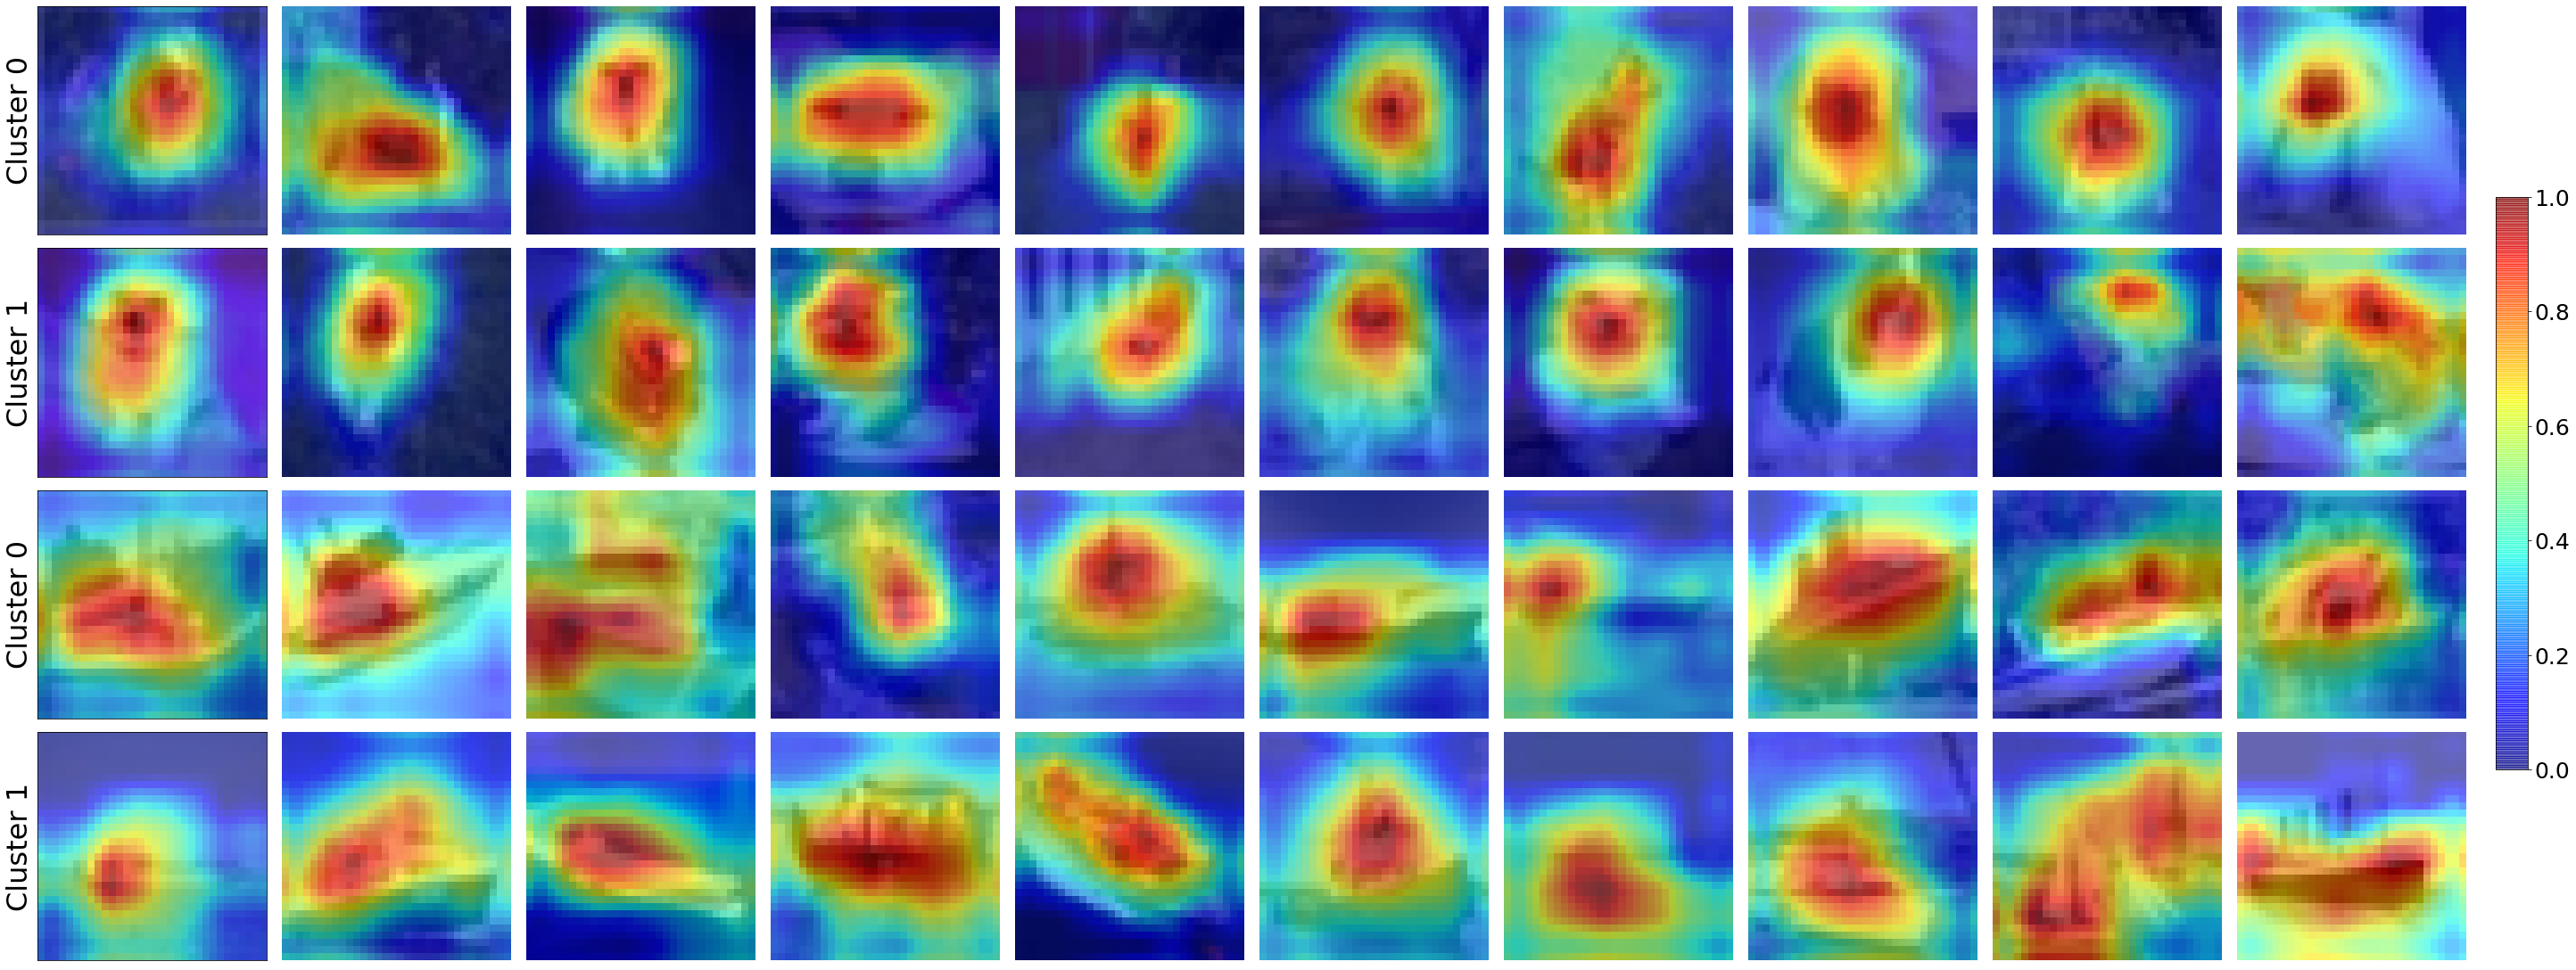

In [ ]:
rows = 4
cols = 10
imgSize = train_images_shuffled.shape[1:3]

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(cols*4,rows*3.75),constrained_layout=True,tight_layout=False)

clase_0 = 5
indices_0 = buscar_num(clase_0,n_instancias,train_labels_shuffled)
indices_0_cluster_0 = []
indices_0_cluster_1 = []
for location, index in enumerate(array_labels_agg_x_clase[clase_0]):
  if index == 0.0: 
    indices_0_cluster_0.append(location)
  else:
    indices_0_cluster_1.append(location)


clase_1 = 8
indices_1 = buscar_num(clase_1,n_instancias,train_labels_shuffled)
indices_1_cluster_0 = []
indices_1_cluster_1 = []
for location, index in enumerate(array_labels_agg_x_clase[clase_1]):
  if index == 0.0: 
    indices_1_cluster_0.append(location)
  else:
    indices_1_cluster_1.append(location)



for i in range(rows):
  for j in range(cols):
    
    if i == 0:
      axes[i,j].imshow(train_images_shuffled[indices_0[indices_0_cluster_0[j]]].squeeze(), cmap='gray')
      axes[i,j].imshow(resize(array_heatmaps_train_x_clase[clase_0][indices_0_cluster_0[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')
    elif i == 1:
      axes[i,j].imshow(train_images_shuffled[indices_0[indices_0_cluster_1[j]]].squeeze(), cmap='gray')
      axes[i,j].imshow(resize(array_heatmaps_train_x_clase[clase_0][indices_0_cluster_1[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')
    elif i == 2:
      axes[i,j].imshow(train_images_shuffled[indices_1[indices_1_cluster_0[j]]].squeeze(), cmap='gray')
      axes[i,j].imshow(resize(array_heatmaps_train_x_clase[clase_1][indices_1_cluster_0[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')
    else:  
      axes[i,j].imshow(train_images_shuffled[indices_1[indices_1_cluster_1[j]]].squeeze(), cmap='gray')
      im = axes[i,j].imshow(resize(array_heatmaps_train_x_clase[clase_1][indices_1_cluster_1[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')

    axes[i,j].set_axis_off()
    if j == 0:
      axes[i,j].set_axis_on()
      axes[i,j].set_xticks([])
      axes[i,j].set_yticks([])
      axes[i,j].set_ylabel('Cluster {}'.format(i % 2),fontsize=32)

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.01, aspect=28)
cbar.ax.tick_params(labelsize=25)
plt.savefig('./ClustersWithHeatmaps.pdf',bbox_inches='tight')
plt.savefig('./ClustersWithHeatmaps.png',dpi=150,bbox_inches='tight')

## SnearkesVsSandal


In [ ]:
  # Load F_MNIST dataset
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  #Reducimos el rango de los valores a entre 0 y 1
  train_images = train_images/255
  test_images = test_images/255

  #Añadimos la informacion de que se trata de un solo canal (y no 3 como en el caso de RGB)
  train_images = train_images.reshape(60000,28,28,1)
  train_images = train_images.astype('float32')

  test_images = test_images.reshape(10000,28,28,1)
  test_images = test_images.astype('float32')

  #Transformamos los vectores con las etiquetas a categoricos, representando la posicion del 1 en el vector al numero correpondiente
  from tensorflow.keras.utils import to_categorical
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)

  class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  num_clases = len(class_names)

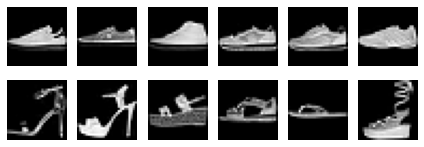

In [ ]:
rows = 2
cols = 6

fig, axes = plt.subplots(nrows=rows,ncols=cols,tight_layout=True)

for i in range(rows):

  if i == 0:
    indices = buscar_num(7,cols,train_labels)
  
  if i == 1:
    indices = buscar_num(5,cols,train_labels)

  for j in range(cols):

    axes[i,j].imshow(train_images[indices[j]].squeeze(), cmap='gray')
    axes[i,j].set_axis_off()

  plt.savefig('Sneakers_vs_Sandals_{}.pdf'.format(cols),bbox_inches='tight')

In [ ]:
for loc,i in enumerate(indices):
  print(i,end='-')
  print(loc, end=' / ')

8-0 / 9-1 / 12-2 / 13-3 / 30-4 / 36-5 / 43-6 / 60-7 / 62-8 / 63-9 / 82-10 / 116-11 / 120-12 / 121-13 / 133-14 / 155-15 / 172-16 / 173-17 / 177-18 / 192-19 / 201-20 / 213-21 / 217-22 / 224-23 / 227-24 / 230-25 / 244-26 / 246-27 / 257-28 / 267-29 / 274-30 / 300-31 / 303-32 / 320-33 / 343-34 / 345-35 / 349-36 / 363-37 / 371-38 / 384-39 / 386-40 / 

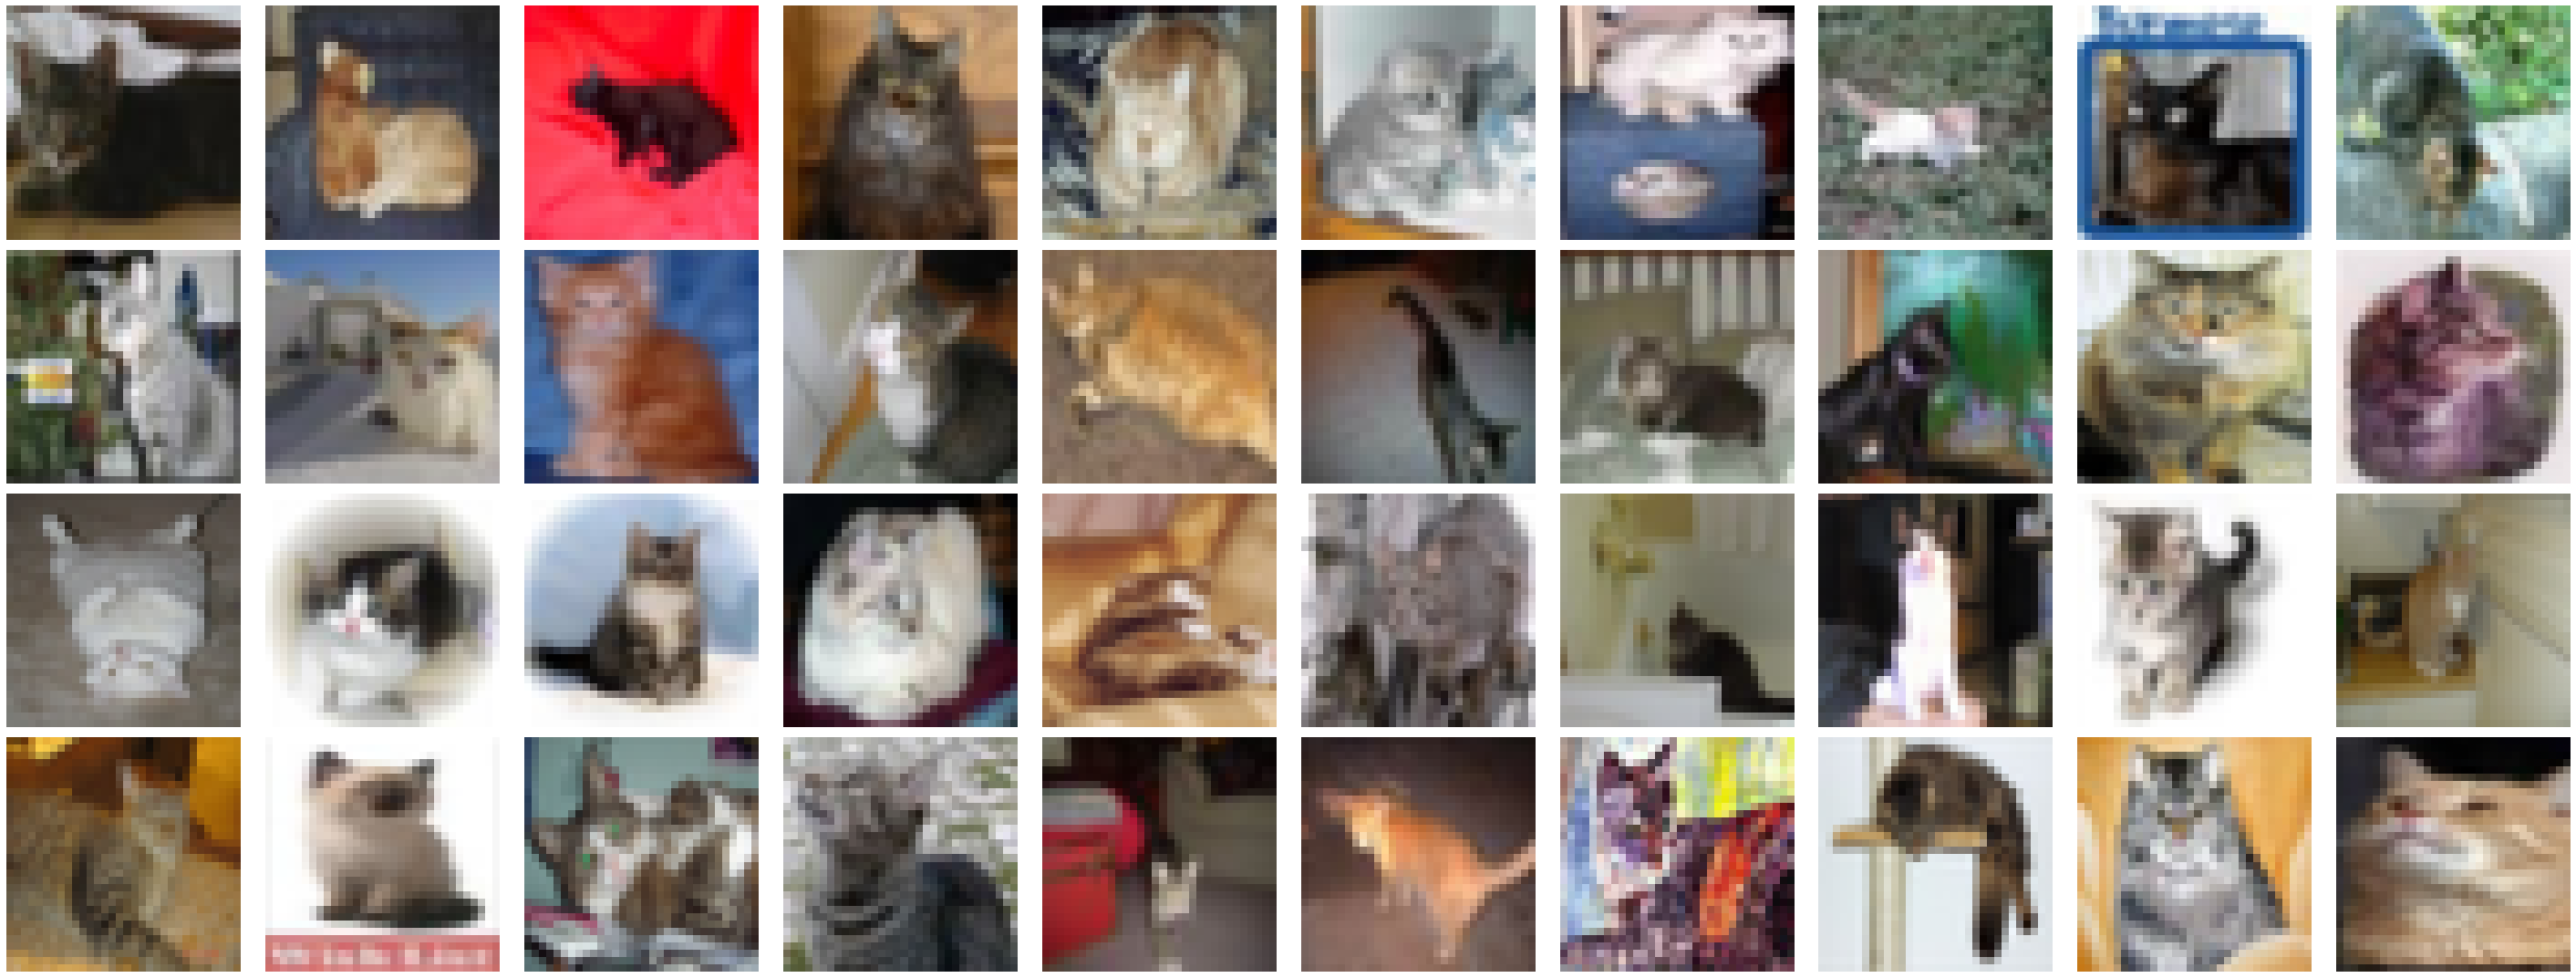

In [ ]:
rows = 4
cols = 10

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(40,15),tight_layout=True)
indices = buscar_num(3,rows*cols,train_labels)

for i in range(rows):
  for j in range(cols):
    n = i*10+j
    axes[i,j].imshow(train_images[indices[n]].squeeze(), cmap='gray')
    axes[i,j].set_axis_off()

## DressVsSneakers


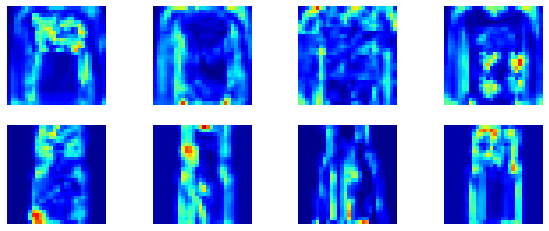

In [ ]:
clase0 = 2
clase1 = 3
imgSize = train_images_shuffled.shape[1:3]

rows = 2
cols = 4
fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*2+2,rows*2])

for i in range(rows):

  if i == 0:
    indices = buscar_num(clase0,cols,test_labels)
  
  if i == 1:
    indices = buscar_num(clase1,cols,test_labels,1200)

  for j in range(cols):

    axes[i,j].imshow(test_images[indices[j]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(array_htmaps_test[indices[j]],imgSize),vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

#cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=20)
#cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(class_names[clase0],class_names[clase1]),bbox_inches='tight')

In [ ]:
for loc,i in enumerate(class_names):
  print(i,end=' ')
  print(loc,end=' // ')

T-shirt/top 0 // Trouser 1 // Pullover 2 // Dress 3 // Coat 4 // Sandal 5 // Shirt 6 // Sneaker 7 // Bag 8 // Ankle boot 9 // 

## Cifar10 consistency


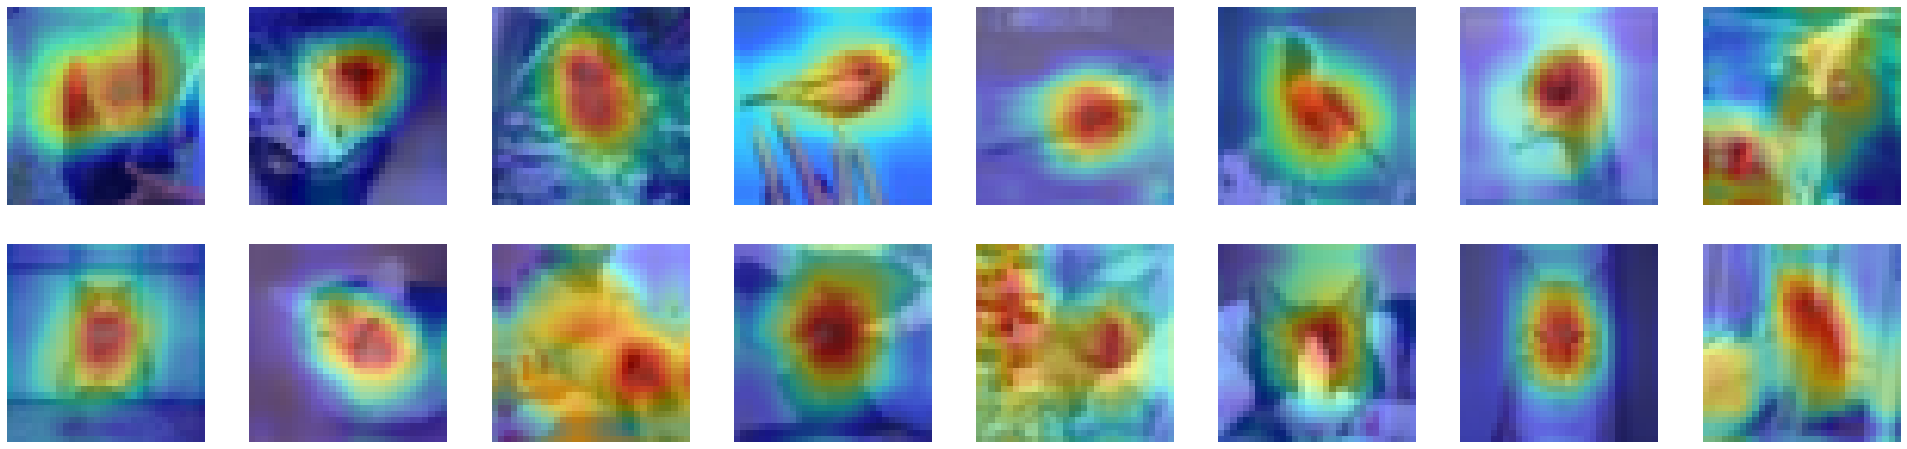

In [ ]:
clase0 = 2
clase1 = 3
imgSize = train_images_shuffled.shape[1:3]

rows = 2
cols = 5

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*4+2,rows*4])

for i in range(rows):

  if i == 0:
    indices = buscar_num(clase0,cols,test_labels)
  
  if i == 1:
    indices = buscar_num(clase1,cols,test_labels,1200)

  for j in range(cols):

    axes[i,j].imshow(test_images[indices[j]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(array_htmaps_test[indices[j]],imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

#cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=20)
#cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(class_names[clase0],class_names[clase1]),bbox_inches='tight')

In [ ]:
rows    = 4
cols    = 10
clase   = 5 # Clase 3 gatos, clase 5 perros
imgSize = train_images_shuffled.shape[1:3]
posIni  = 750

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(40,15),tight_layout=True)
indices = buscar_num(clase,rows*cols,train_labels_shuffled,pos=posIni)

for i in range(rows):
  for j in range(cols):
    n = i*10+j
    print(str(n)+'//'+str(indices[n]))
    axes[i,j].imshow(train_images_shuffled[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(array_heatmaps_train_x_clase[clase][posIni+n],imgSize),alpha=0.35,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

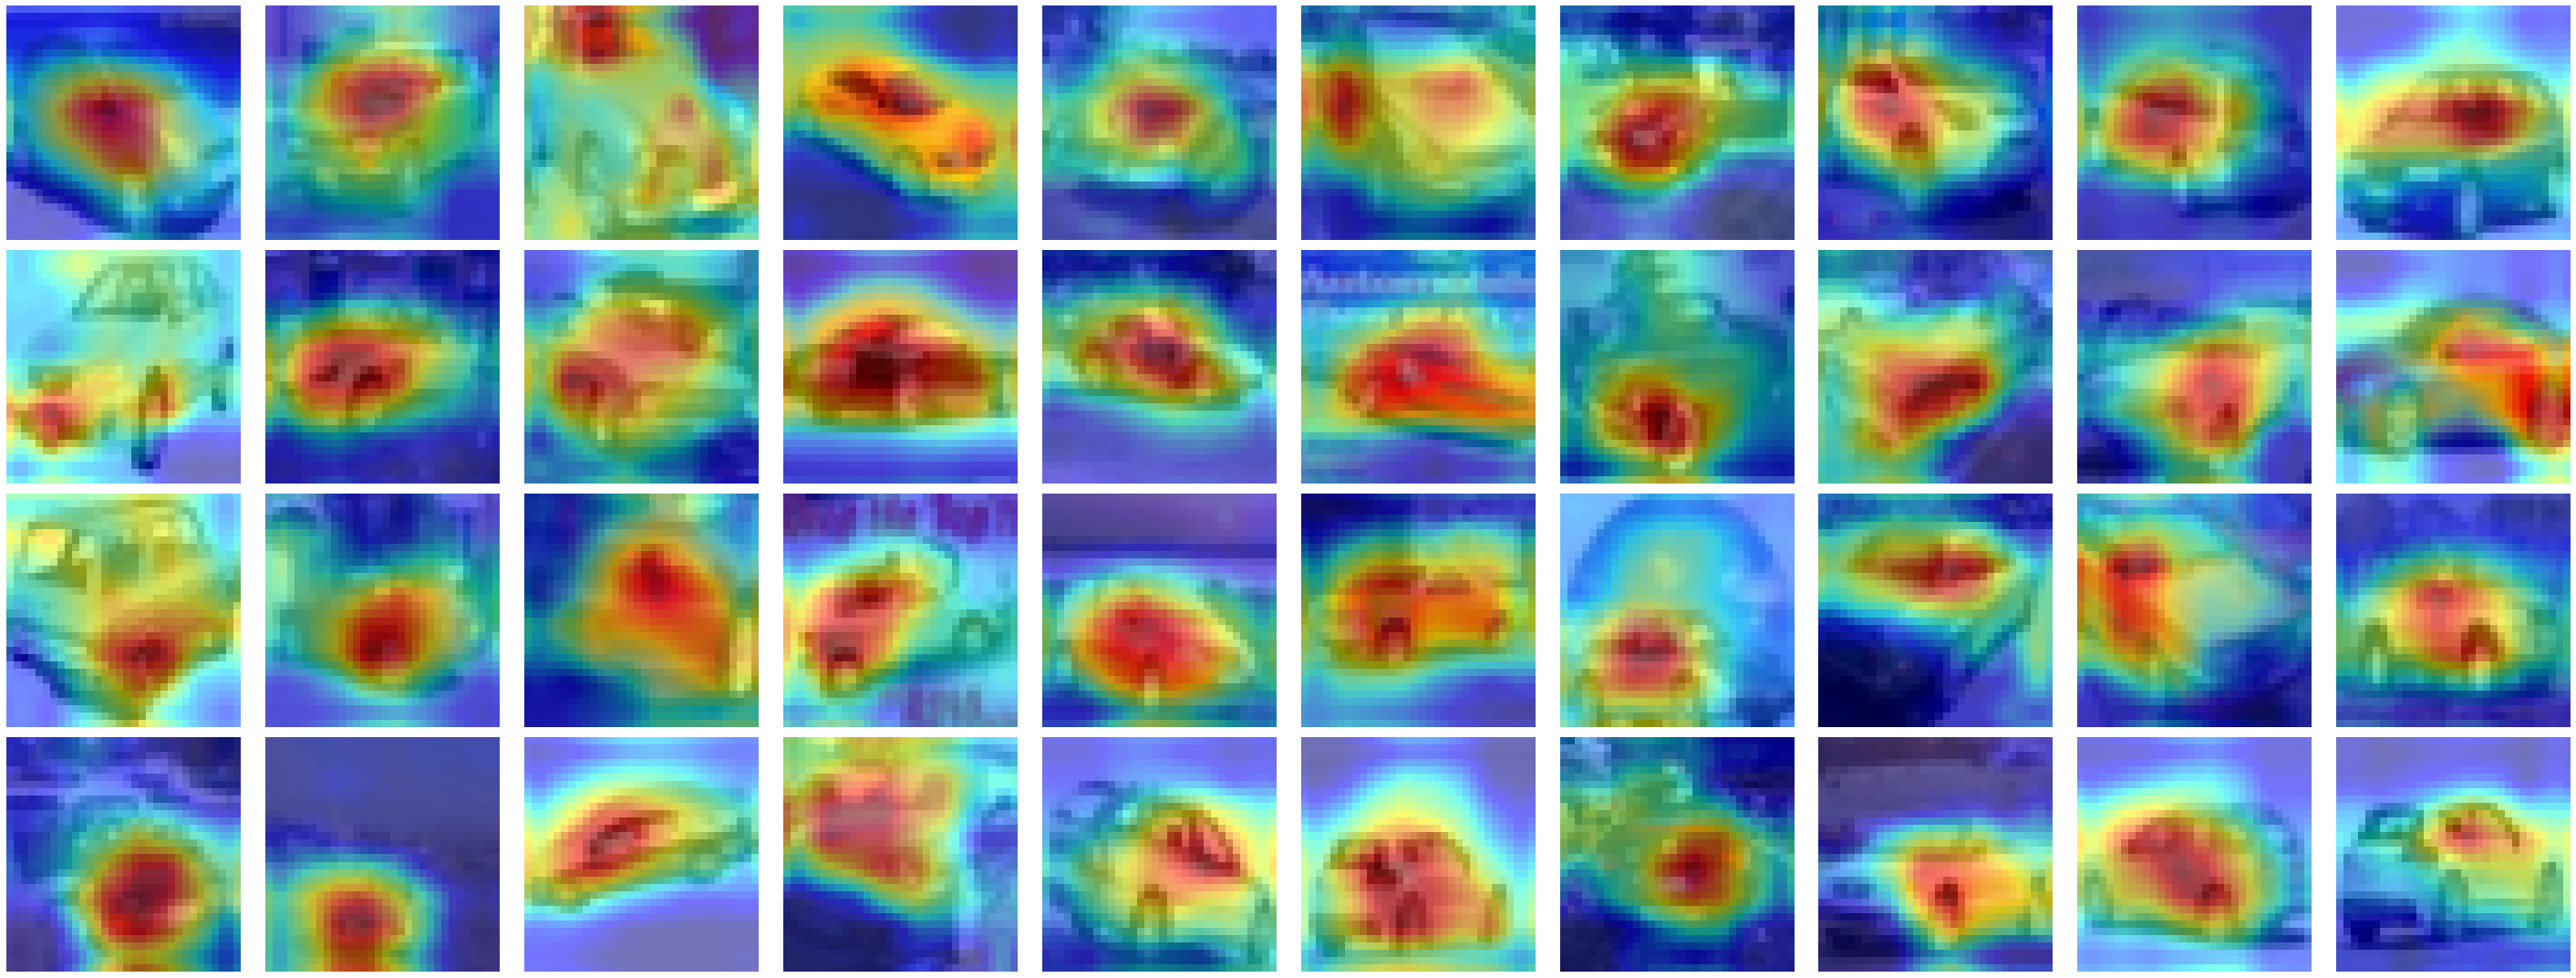

In [ ]:
rows    = 4
cols    = 10
clase   = 1 # Clase 3 gatos, clase 5 perros
imgSize = train_images_shuffled.shape[1:3]
posIni  = 750

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(40,15),tight_layout=True)
indices = buscar_num(clase,rows*cols,train_labels_shuffled,pos=posIni)
heatmapsCifar = []
#for ind in indices:
#  heatmapsCifar.append(grad_cam_plus(train_images_shuffled[indices[n]],model,last_conv_layer,category_id=train_labels_shuffled[indices[n]]))

for i in range(rows):
  for j in range(cols):
    n = i*10+j
    #print(str(n)+'//'+str(indices[n]))
    heatmap = grad_cam_plus(train_images_shuffled[indices[n]],model,last_conv_layer,category_id=np.argmax(train_labels_shuffled[indices[n]]))
    axes[i,j].imshow(train_images_shuffled[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.55,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

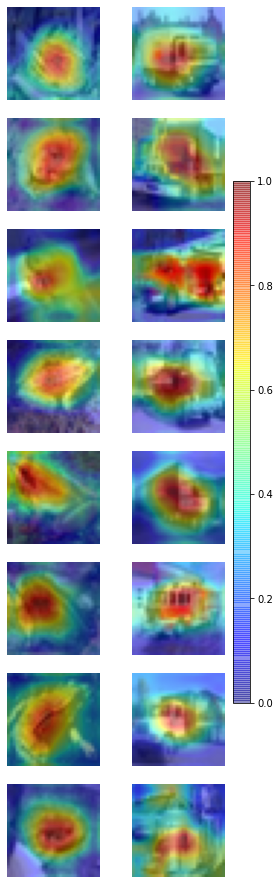

In [ ]:
clase0 = 6
clase1 = 9
imgSize = train_images_shuffled.shape[1:3]
size = 2

rows = 8
cols = 2

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*size+1,rows*size])

for j in range(cols):
  if j == 0:
    indices = buscar_num(clase0,rows*(cols/2)-1,test_labels)
  
  if j == 1:
    indices.extend(buscar_num(clase1,rows*(cols/2)-1,test_labels))

  for i in range(rows):
    n = i+rows*j
    heatmap = grad_cam_plus(test_images[indices[n]],model,last_conv_layer,category_id=np.argmax(test_labels[indices[n]]))
    axes[i,j].imshow(test_images[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=30)
cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(class_names[clase0],class_names[clase1]),bbox_inches='tight')

In [ ]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

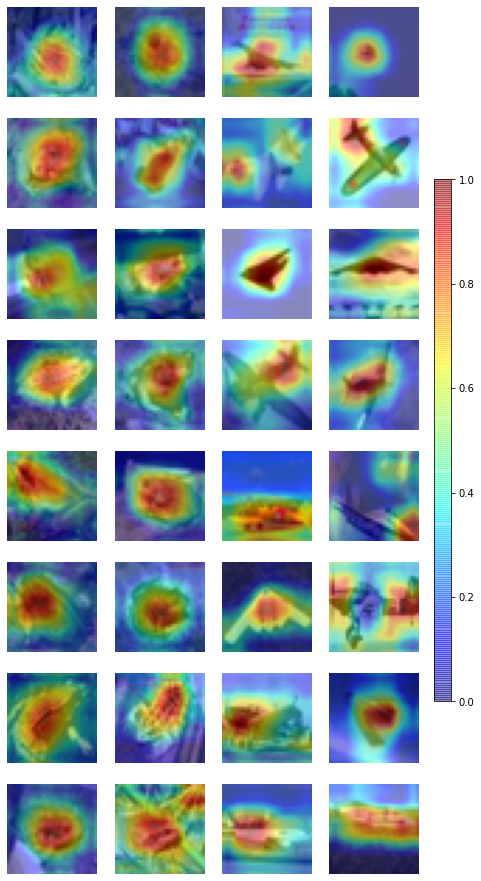

In [ ]:
clase0 = 6
clase1 = 0
imgSize = train_images_shuffled.shape[1:3]
size = 2

rows = 8
cols = 4

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*size+1,rows*size])

for j in range(cols):
  if j == 0:
    indices = buscar_num(clase0,rows*(cols/2)-1,test_labels)
  
  if j == 2:
    indices.extend(buscar_num(clase1,rows*(cols/2)-1,test_labels))

  for i in range(rows):
    n = i+rows*j
    heatmap = grad_cam_plus(test_images[indices[n]],model,last_conv_layer,category_id=np.argmax(test_labels[indices[n]]))
    axes[i,j].imshow(test_images[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=30)
cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(class_names[clase0],class_names[clase1]),bbox_inches='tight')
plt.savefig('Consistency_{}_{}.png'.format(class_names[clase0],class_names[clase1]),bbox_inches='tight',dpi=200)

## FMNIST, MNIST y Cifar10gray


In [ ]:
  cifar = tf.keras.datasets.cifar10
  (od_train_images, od_train_labels), (cifar_images, cifar_labels) = cifar.load_data()
  # Damos el formato correspondiente a las imagenes
  cifar_images = cifar_images.reshape(10000, 32, 32, 3)
  cifar_images = cifar_images.astype('float32') / 255
  cifar_images = np.expand_dims(color.rgb2gray(cifar_images),axis=3)
  cifar_images = resize(cifar_images,(10000, 28, 28, 1))

170508288/170498071 [==============================] - 11s 0us/step


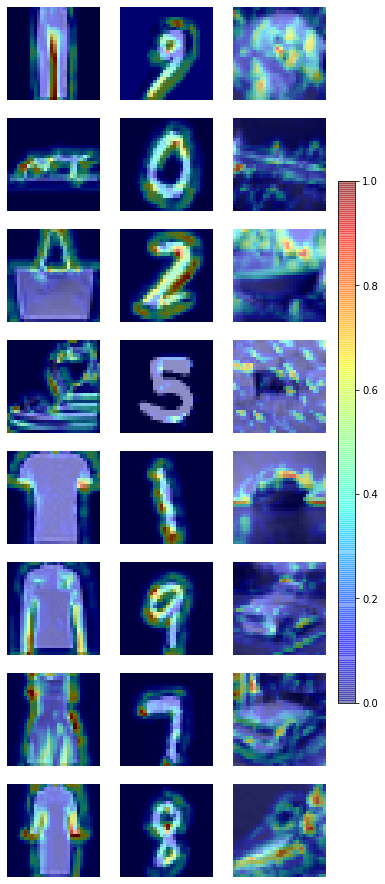

In [ ]:
imgSize = train_images_shuffled.shape[1:3]
size = 2

rows = 8
cols = 3

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*size+1,rows*size])

for j in range(cols):

  if j == 0:
    n = 1500
    images = train_images_shuffled[n:(n+rows)] 
    labels = train_labels_shuffled[n:(n+rows)]

  elif j == 1:
    n = 1000
    images = od_test_images[n:(n+rows)] 
    labels = od_test_labels[n:(n+rows)]

  else:
    n = 1000
    images = cifar_images[n:(n+rows)] 
    labels = cifar_labels[n:(n+rows)]

  for i in range(rows):
    heatmap = grad_cam_plus(images[i],model,last_conv_layer,category_id=np.argmax(labels[i]))
    axes[i,j].imshow(images[i].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=30)
cbar.ax.tick_params(labelsize=10)

plt.savefig('Heatmaps_FMNIST_MNIST_Cifar.pdf'.format(),bbox_inches='tight')
plt.savefig('Heatmaps_FMNIST_MNIST_Cifar.png'.format(),bbox_inches='tight',dpi=200)

## FMNIST image

In [ ]:
for loc,i in enumerate(class_names):
  print(i,end=' ')
  print(loc,end=' // ')

T-shirt/top 0 // Trouser 1 // Pullover 2 // Dress 3 // Coat 4 // Sandal 5 // Shirt 6 // Sneaker 7 // Bag 8 // Ankle boot 9 // 

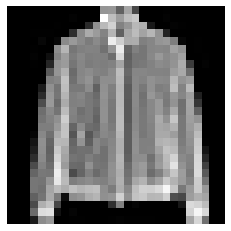

In [ ]:
initPos = 50
classNumber = 4
imgIndex = buscar_num(classNumber,1,train_labels,initPos)
plt.imshow(train_images[imgIndex[0],:,:,0],vmin=0,vmax=1,cmap='gray')
plt.gca().set_axis_off()
plt.savefig('FMNIST_{}_{}.pdf'.format(class_names[classNumber],initPos),bbox_inches='tight')
plt.savefig('FMNIST_{}_{}.png'.format(class_names[classNumber],initPos),bbox_inches='tight',dpi=200)

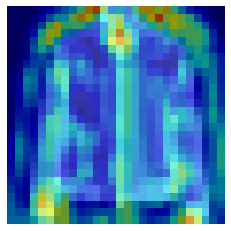

In [ ]:
initPos = 50
classNumber = 4
imgIndex = buscar_num(classNumber,1,train_labels,initPos)
htmap = grad_cam_plus(train_images[imgIndex[0]],model,last_conv_layer,category_id=np.argmax(train_labels[imgIndex]))
plt.imshow(train_images[imgIndex[0],:,:,0],vmin=0,vmax=1,cmap='gray')
plt.imshow(resize(htmap,(28,28)),vmin=0,vmax=1,cmap='jet',alpha=0.6)
plt.gca().set_axis_off()
plt.savefig('FMNIST_{}_{}_htmap.pdf'.format(class_names[classNumber],initPos),bbox_inches='tight')
plt.savefig('FMNIST_{}_{}_htmap.png'.format(class_names[classNumber],initPos),bbox_inches='tight',dpi=200)

# Codigo de pruebas


In [ ]:
from skimage import color

In [ ]:
rgbImage = np.tile(test_images,3)

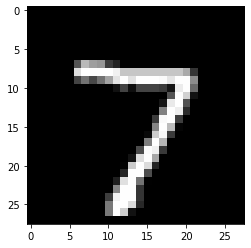

In [ ]:
plt.imshow(rgbImage[0])

In [ ]:
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(od_test_images[0], rgb_weights)

In [ ]:
grayscale_image1 = np.expand_dims(color.rgb2gray(od_test_images),axis=3)

In [ ]:
grayscale_image1.shape

(10000, 32, 32, 1)

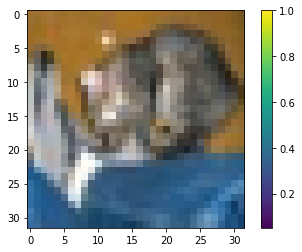

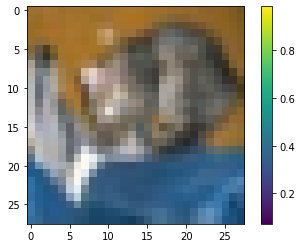

In [ ]:
plt.imshow(od_test_images[0])
plt.colorbar()
plt.show()
plt.imshow(resize(od_test_images,(10000,28,28,3))[0])
plt.colorbar()
plt.show()

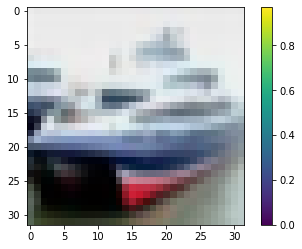

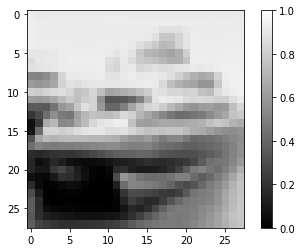

In [ ]:
plt.imshow(od_test_images[1])
plt.colorbar()
plt.show()
plt.imshow(color.rgb2gray(resize(od_test_images,(10000,28,28,3))[1]),cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar()
plt.show()

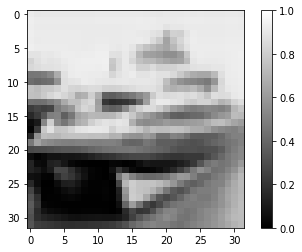

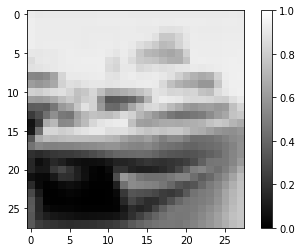

In [ ]:
plt.imshow(od_test_images[1,:,:,0],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar()
plt.show()
plt.imshow(resize(od_test_images,(10000,28,28,1))[1,:,:,0],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar()
plt.show()

In [ ]:
grayscale_image1[0]

array([[[0.45973605],
        [0.45719844],
        [0.47735688],
        ...,
        [0.39086708],
        [0.37047842],
        [0.34446394]],

       [[0.45530155],
        [0.44574708],
        [0.46504942],
        ...,
        [0.38862002],
        [0.3685141 ],
        [0.35566315]],

       [[0.4477263 ],
        [0.44096234],
        [0.4532549 ],
        ...,
        [0.40038472],
        [0.38446826],
        [0.35901922]],

       ...,

       [[0.45459333],
        [0.3573953 ],
        [0.31145254],
        ...,
        [0.34508   ],
        [0.22092119],
        [0.30770865]],

       [[0.42377138],
        [0.3688396 ],
        [0.30495566],
        ...,
        [0.28847373],
        [0.28984272],
        [0.22647177]],

       [[0.39042664],
        [0.38337216],
        [0.32451096],
        ...,
        [0.27108312],
        [0.30046862],
        [0.2365698 ]]], dtype=float32)

In [ ]:
print(grayscale_image[5,3])
print(grayscale_image1[5,3])

0.4538207942724228
0.4517004


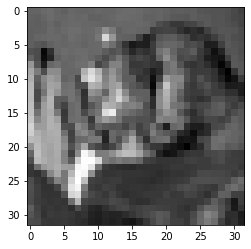

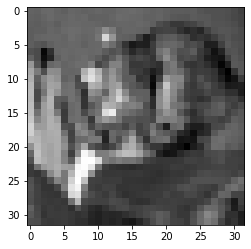

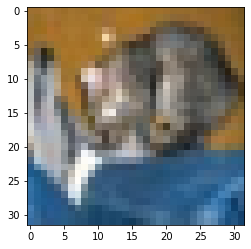

In [ ]:
plt.imshow(grayscale_image,cmap=plt.cm.gray)
plt.show()
plt.imshow(grayscale_image1,cmap=plt.cm.gray)
plt.show()
plt.imshow(od_test_images[0],cmap='binary')

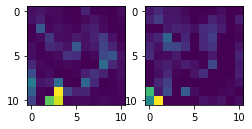

In [ ]:
plt.subplot(131).imshow(grad_cam_plus(resize(grayscale_image,(28,28)),model,last_conv_layer))
plt.subplot(132).imshow(grad_cam_plus(resize(grayscale_image1,(28,28)),model,last_conv_layer))
#plt.subplot(133).imshow(img_2)

In [ ]:
!pip install opencv-python==4.5.2.52
!pip install opencv-contrib-python==4.5.2.52

In [ ]:
import cv2 as cv

In [ ]:
src = test_images[0]
center = (src.shape[1]//2, src.shape[0]//2)
angle = -45
scale = 1
rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
warp_rotate_dst = cv2.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))

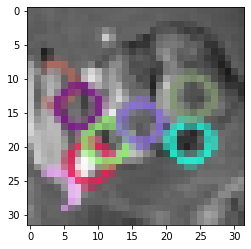

In [ ]:
img = test_images[0]
gray= (cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)*255).astype('uint8')
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,gray)
plt.imshow(img)

SSIM between color images:  0.06096836732598352


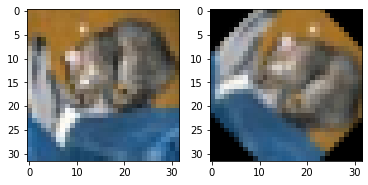

SSIM between grayscale images:  -0.013218551737504532


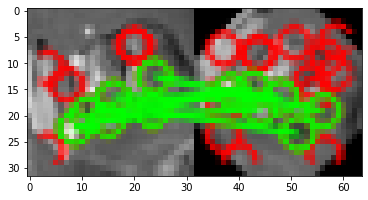

1
9.090909090909092 % similarity
2
18.181818181818183 % similarity
3
27.272727272727273 % similarity
4
36.36363636363637 % similarity
5
45.45454545454545 % similarity
6
54.54545454545455 % similarity
7
63.63636363636363 % similarity


In [ ]:
# Inicializar imagenes
img1 = test_images[0]
img2 = warp_rotate_dst
print('SSIM between color images: ',ssim(img1,img2,multichannel=True))
plt.subplots(1,2)
plt.subplot(121).imshow(img1)
plt.subplot(122).imshow(img2)
plt.show()
img1 = (img1*255).astype('uint8')
img2 = (img2*255).astype('uint8')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
print('SSIM between grayscale images: ',ssim(img1,img2))
#img1 = cv.normalize(img1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
#img2 = cv.normalize(img2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

# Initiate SIFT detector
sift=cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        a=len(good)
        print(a)
        percent=(a*100)/len(kp1) # Esto realmente era sin len(), pero daba fallo. Creo que así se corrige, ya que lo que se buscas es saber el % de buenos que hay frente a el total de descriptores
        print("{} % similarity".format(percent))
        if percent >= 75.00:
            print('Match Found')
            break;

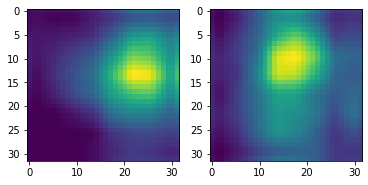

SSIM: 0.2840977633534593


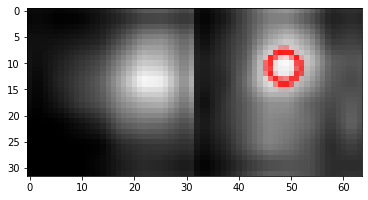

In [ ]:
# Inicializar imagenes
clase = 5
i_1 = 1
i_2 = 859
img1 = resize(array_heatmaps_train_x_clase[clase,i_1],(32,32))
img2 = resize(array_heatmaps_train_x_clase[clase,i_2],(32,32))
plt.subplots(1,2)
plt.subplot(121).imshow(img1)
plt.subplot(122).imshow(img2)
plt.show()
img1 = (img1*255).astype('uint8')
img2 = (img2*255).astype('uint8')
#img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
#img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
print('SSIM:',ssim(img1,img2))
#img1 = cv.normalize(img1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
#img2 = cv.normalize(img2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

# Initiate SIFT detector
sift=cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        a=len(good)
        print(a)
        percent=(a*100)/len(kp1) # Esto realmente era sin len(), pero daba fallo. Creo que así se corrige, ya que lo que se buscas es saber el % de buenos que hay frente a el total de descriptores
        print("{} % similarity".format(percent))
        if percent >= 75.00:
            print('Match Found')
            break;

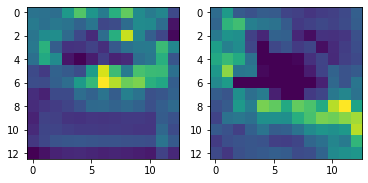

ValueError: ignored

In [ ]:
# Initialize images to grayscale and uint8
'''
img1 = test_images[0]
img2 = warp_rotate_dst
'''
clase = 0
i_1 = 56
i_2 = 898
sizeOfResize = (13,13)
img1 = resize(array_heatmaps_train_x_clase[clase,i_1],sizeOfResize)
img2 = resize(array_heatmaps_train_x_clase[clase,i_2],sizeOfResize)
plt.subplots(1,2)
plt.subplot(121).imshow(img1)
plt.subplot(122).imshow(img2)
plt.show()
img1 = (img1*255).astype('uint8')
img2 = (img2*255).astype('uint8')

# Initiate SURF detector
surf=cv.SIFT_create()

# find the keypoints and descriptors with SURF
kp1, des1 = surf.detectAndCompute(img1,None)
kp2, des2 = surf.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        a=len(good)
        percent=(a*100)/len(kp2)
        print("{} % similarity".format(percent))
        if percent >= 75.00:
            print('Match Found')
        if percent < 75.00:
            print('Match not Found')

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
plt.imshow(img3),plt.show()
print('Score:',len(good)/len(matches))

In [ ]:
test_labels[8]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
print(len(good),len(kp1),len(kp2))

7 11 17


In [ ]:
gray= cv.cvtColor(src,cv.COLOR_BGR2GRAY)
plt.imshow(gray)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)

SSIM: 0.56 / SIFT


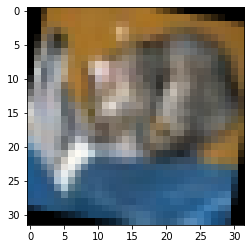

1.0


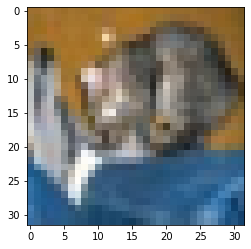

In [ ]:
plt.imshow(warp_rotate_dst)
print('SSIM:',round(ssim(src,warp_rotate_dst,multichannel=True),3),'/ SIFT:',)
plt.show()
plt.imshow(test_images[0])
print(ssim(src,test_images[0],multichannel=True))
plt.show()

Para Javi


In [ ]:
# Creacion de heatmaps clusters para javi
array_labels_de_cada_cluster  = array_labels_agg_x_clase
array_htmaps_x_clase_cluster = np.zeros((num_clases,))
modo_heatmaps                     = 'mediana'
for clase in range(num_clases):

  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(array_labels_de_cada_cluster[clase], return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico
  
  for i_unique,cluster in enumerate(unique):

    with open('/content/drive/MyDrive/Para_Javi/array_heatmaps_clase_{}_cluster_{}.npy'.format(clase,int(cluster)), 'wb') as f:
       
      np.save(f, calculo_htmaps_x_cluster_para_javi(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase]))


In [ ]:
def calculo_htmaps_x_cluster_para_javi(a_indice_clust, a_heatmaps,modo='mediana',cuantiles=[0,0.25,0.50,0.75,1]):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  Devuelve:
  - Htmaps por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  '''

  # Capturamos los indices de los heatmaps que pertenecen a ese cluster
  a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

  # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
  a_aux_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
  for i,i_un_cluster in enumerate(a_indices_un_cluster):
    a_aux_htmaps[i] = a_heatmaps[int(i_un_cluster)]
    
  return a_aux_htmaps

In [ ]:
# Prueba que voy a hacer para comprobar como se guarda el h5
%cd /content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Datasets
model.save('Pruebah5.h5')

/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Datasets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


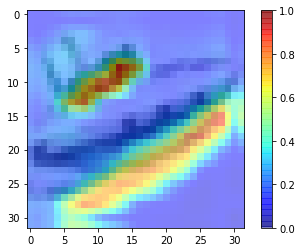

In [ ]:
pos = buscar_num(8,0,train_labels_shuffled,1)
plt.imshow(train_images_shuffled[pos].squeeze(),vmin=0,vmax=1)
plt.imshow(resize(array_heatmaps_train_x_clase[8,1],(32,32)),alpha=0.5,cmap='jet',vmin=0,vmax=1)
plt.colorbar()

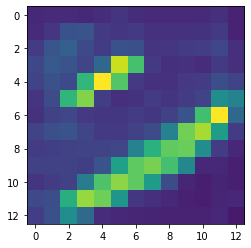

In [ ]:
plt.imshow(array_heatmaps_train_x_clase[8,1],vmin=0,vmax=1)

In [ ]:
batches = test_datagen.flow(test_images,test_labels,shuffle=False,batch_size=100)

In [ ]:
x_batch, y_batch = next(batches)

In [ ]:
x_batch[0]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


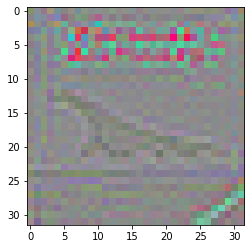

In [ ]:
num = 3
plt.imshow((x_batch[num]-x_batch[num].min())/(x_batch[num].max()-x_batch[num].min()),vmin=0,vmax=1)
print(y_batch[num])

In [ ]:

'''
#Creamos el modelo
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D

indices_0_9 = [545,5848,35,369,803,45,729,34,787,284] # Son los indices de los números (ordenados de 0 a 9)

!nvidia-smi
!/usr/local/cuda/bin/nvcc --version
'''

In [ ]:
model.summary()

In [ ]:
from tf_explain.core import GradCAM

In [ ]:
y_batch[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
img = x_batch[0]
prediccion = np.argmax(model.predict(np.expand_dims(x_batch[0],axis=0)))
data = ([img], None)

explainer = GradCAM()
grid = explainer.explain(data, model,class_index=prediccion) 

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
htmap = tf.keras.preprocessing.image.load_img('grad_cam.png', target_size=(32, 32))

In [ ]:
tf.keras.preprocessing.image.img_to_array(htmap)

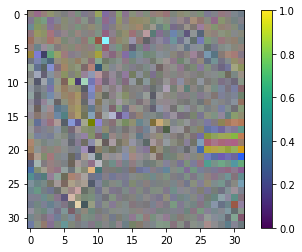

In [ ]:
im = (x_batch[0] - x_batch[0].min()) / (x_batch[0].max() - x_batch[0].min())
plt.imshow(im)
#plt.imshow(htmap,alpha=0.6,cmap='jet')
plt.colorbar()


In [ ]:
pip install tf-explain

     |████████████████████████████████| 51kB 6.4MB/s 


In [ ]:
batches = test_datagen.flow(test_images,test_labels,shuffle=False,batch_size=100)

In [ ]:
x_batch, y_batch = next(batches)

In [ ]:
pos = 85
htmap = grad_cam_plus(x_batch[pos],model,last_conv_layer,label_name=class_names)
htmap

airplane


<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.02346151, 0.2913969 ,
        0.19012512, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2848295 , 0.5044494 ,
        0.36826512, 0.        , 0.        ],
       [0.        , 0.        , 0.22496039, 0.48455703, 0.3748333 ,
        0.15374744, 0.        , 0.        ],
       [0.        , 0.11813726, 0.6800064 , 1.        , 0.6160714 ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5068885 , 0.90220207, 0.65907735,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]], dtype=float32)>

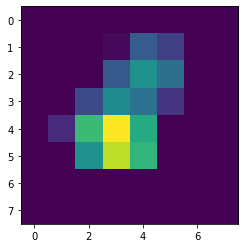

In [ ]:
plt.imshow(htmap,vmin=0,vmax=1)

dog


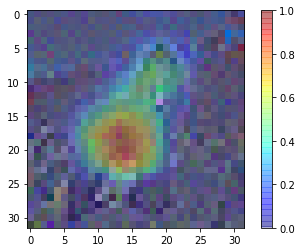

In [ ]:
im = (x_batch[pos] - x_batch[pos].min()) / (x_batch[pos].max() - x_batch[pos].min())
plt.imshow(im)
plt.imshow(resize(htmap,(32,32)),alpha=0.3,cmap='jet',vmin=0,vmax=1)
plt.colorbar()
print(class_names[np.argmax(y_batch[pos])])

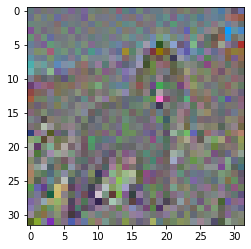

In [ ]:
im = (x_batch[pos] - x_batch[pos].min()) / (x_batch[pos].max() - x_batch[pos].min())
plt.imshow(im)

In [ ]:
pos = 85
htmap = grad_cam_plus(train_images[pos],model,last_conv_layer,label_name=class_names)
htmap

horse


<tf.Tensor: shape=(13, 13), dtype=float32, numpy=
array([[2.12490615e-02, 2.36936081e-02, 9.84172001e-02, 2.93629020e-01,
        2.52758503e-01, 0.00000000e+00, 2.37738952e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [5.92969507e-02, 0.00000000e+00, 2.71537825e-02, 3.93132985e-01,
        1.68624103e-01, 1.98734000e-01, 1.37673497e-01, 1.85046196e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [3.83822732e-02, 0.00000000e+00, 6.29518986e-01, 4.61501896e-01,
        1.98234543e-01, 5.15046656e-01, 5.82585692e-01, 3.75542045e-01,
        1.10807531e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.09766254e-01, 1.50724009e-01,
        4.99249995e-02, 4.91228938e-01, 7.51498580e-01, 2.04977900e-01,
        6.91288859e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0

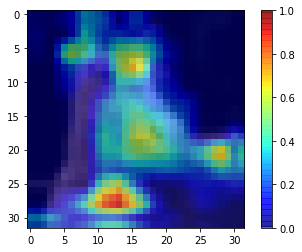

In [ ]:
plt.imshow(train_images[pos],vmin=0,vmax=1)
plt.imshow(resize(htmap,(32,32)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
plt.colorbar()

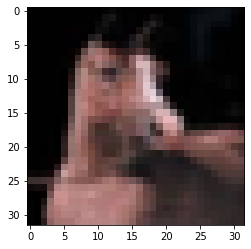

In [ ]:
plt.imshow(train_images[pos],vmin=0,vmax=1)

In [ ]:
plt.imshow(train_images[pos],vmin=0,vmax=1)
plt.imshow(resize(htmap,(32,32)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
plt.colorbar()

In [ ]:
# Hyperparameters
superimposed  = True
reescaled     = True
seed      = 2

fontsize  = 18
cmap      = 'jet'
rows      = 10
cols      = 15
indexes   = random_integers(seed,0,len(test_images),(cols-1),dtype=int)
imagenes_cifar    = np.array([test_images[i] for i in indexes])
pred_imagen_cifar = np.argmax(model.predict(imagenes_cifar),axis=1)

imagenes_od       = np.array([od_test_images[i] for i in indexes])
pred_imagen_od    = np.argmax(model.predict(imagenes_od),axis=1)

In [ ]:
filename        = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/listHeatmapsPerLayerPerClass.pkl'
retrieved_file = open(filename,'rb')
heatmapsPerLayer = pickle.load(retrieved_file)
retrieved_file.close()

In [ ]:
# Code for creating the heatmaps for each class of each layer

# Parameters
num_heatmaps    = 50
num_heatmaps_od = 50
seed            = 7
filename        = '/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/listHeatmapsPerLayerPerClass.pkl'

# Initialization
heatmapsPerLayer = []
imagesPerClass   = []
predsPerClass    = []
prueba           = random_integers(seed,low=0,high=8,size=1,dtype=int)
indexes_od       = random_integers(seed,low=0,high=len(od_test_images),size=num_heatmaps_od,dtype=int)

# Create de lists cotaining the images and predictions per class to then compute the heatmaps
for clase in range(num_clases+1):
# Initialize the images, predictions and the array for the heatmaps

  if clase == num_clases: # As range starts in 0, the OD dataset's index is not with +1
    imagesPerClass.append(np.array([od_test_images[j] for j in indexes]))    
  else:
    indexes = buscar_num(clase,num_heatmaps+1,test_labels,1000*prueba[0])   
    imagesPerClass.append(np.array([test_images[j] for j in indexes]))

  predsPerClass.append(np.argmax(model.predict(imagesPerClass[clase]),axis=1))